Helpful Page: https://www.sdss.org/dr12/algorithms/magnitudes/

# Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings 
warnings.filterwarnings('ignore')

# Load Data

In [2]:
train = pd.read_csv('../dataset/train.csv', index_col = 0)
test = pd.read_csv('../dataset/test.csv', index_col = 0)
sample_submission = pd.read_csv('../dataset/sample_submission.csv', index_col = 0)

# Define Function

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

# Check Dataset
제공된 데이터 셋의 피쳐에 대한 설명은 다음과 같다.

- ID: Unique ID
- type: 천체의 분류
- psfMag(Point Spread Function Magnitudes): 먼 천제를 한 점으로 가정하여 측정한 빛의 밝기.
- fiberMag(Fiber Magnitudes): 광섬유를 통과하는 빛의 밝기. 3인치 지름의 광섬유를 사용하여 광스펙트럼을 측정.
- petroMag(Petrosian Magnitudes): 전체의 위치와 거리에 상관없이 빛의 밝기를 비교하기 위한 수치. 은하처럼 뚜렷한 표변이 없는 천체에서는 빛의 밝기를 측정하기 어렵다.
- modelMag(Model Magnitudes): 천체 중심으로부터 특정 거리의 밝기
- fiberID: 관측에 사용된 광섬유의 구분자

컬럼 뒤에 존재하는 알파벳의 의미는 파장대를 의미하며, 다음과 같다.
- u: Ultraviolet
- g: Green
- r: Red
- i: Near Infrared (근적외선)
- z: Infrared (적외선)

<img src=../image/가시광선파장대.png width="600">

Source: [위키백과: 가시광선](https://ko.wikipedia.org/wiki/%EA%B0%80%EC%8B%9C%EA%B4%91%EC%84%A0)

보통 육안으로 400~700nm 까지의 범위를 감지할 수 있다. 

## Shape

In [4]:
print("Train Data Shape: {}".format(train.shape))
train.head()

Train Data Shape: (199991, 22)


type  fiberID   psfMag_u   psfMag_g   psfMag_r   psfMag_i  \
id                                                                        
0              QSO      601  23.198224  21.431953  21.314148  21.176553   
1              QSO      788  21.431355  20.708104  20.678850  20.703420   
2              QSO      427  17.851451  16.727898  16.679677  16.694640   
3              QSO      864  20.789900  20.040371  19.926909  19.843840   
4   STAR_RED_DWARF      612  26.454969  23.058767  21.471406  19.504961   

     psfMag_z  fiberMag_u  fiberMag_g  fiberMag_r  ...  petroMag_u  \
id                                                 ...               
0   21.171444   22.581309   21.644453   21.657571  ...   22.504317   
1   20.473229   21.868797   21.029773   20.967054  ...   21.360701   
2   16.641788   18.171890   17.033098   16.999682  ...   17.867253   
3   19.463270   21.039030   20.317165   20.217898  ...   20.433907   
4   18.389096   25.700632   23.629122   21.742750  ...   25.859229   

    petroMag_g  petroMag_r  petroMag_i  petroMag_z  modelMag_u  modelMag_g  \
id                                                                           
0    21.431636   21.478312   21.145409   20.422446   22.749241   21.465534   
1    20.778968   20.889705   20.639812   20.646660   21.492955   20.758527   
2    16.738784   16.688874   16.744210   16.808006   17.818063   16.697434   
3    19.993727   19.985531   19.750917   19.455117   20.770711   20.001699   
4    22.426929   21.673551   19.610012   18.376141   24.877052   23.147993   

    modelMag_r  modelMag_i  modelMag_z  
id                                      
0    21.364187   21.020605   21.147340  
1    20.753925   20.693389   20.512314  
2    16.641249   16.660177   16.688928  
3    19.889798   19.758113   19.552855  
4    21.475342   19.487330   18.375655  

[5 rows x 22 columns]

## Check Missing & Unique Value

In [5]:
resumetable(train)

Dataset Shape: (199991, 22)


Name   dtypes  Missing  Uniques
0         type   object        0       19
1      fiberID    int64        0     1000
2     psfMag_u  float64        0   199991
3     psfMag_g  float64        0   199991
4     psfMag_r  float64        0   199991
5     psfMag_i  float64        0   199991
6     psfMag_z  float64        0   199991
7   fiberMag_u  float64        0   199991
8   fiberMag_g  float64        0   199991
9   fiberMag_r  float64        0   199991
10  fiberMag_i  float64        0   199991
11  fiberMag_z  float64        0   199991
12  petroMag_u  float64        0   199991
13  petroMag_g  float64        0   199991
14  petroMag_r  float64        0   199991
15  petroMag_i  float64        0   199991
16  petroMag_z  float64        0   199991
17  modelMag_u  float64        0   199991
18  modelMag_g  float64        0   199991
19  modelMag_r  float64        0   199991
20  modelMag_i  float64        0   199991
21  modelMag_z  float64        0   199991

fiberID(관측에 사용된 광섬유의 구분자)의 고유값 개수가 1,000개라는 것에 주목할 필요가 있다.

## Summary Statistics

In [6]:
train.describe()

fiberID      psfMag_u       psfMag_g       psfMag_r  \
count  199991.000000  1.999910e+05  199991.000000  199991.000000   
mean      360.830152 -6.750146e+00      18.675373      18.401235   
std       225.305890  1.187678e+04     155.423024     127.128078   
min         1.000000 -5.310802e+06  -40022.466071  -27184.795793   
25%       174.000000  1.965259e+01      18.701180      18.048572   
50%       349.000000  2.087136e+01      19.904235      19.454492   
75%       526.000000  2.216043e+01      21.150297      20.515936   
max      1000.000000  1.877392e+04    3538.984910    3048.110913   

            psfMag_i       psfMag_z    fiberMag_u     fiberMag_g  \
count  199991.000000  199991.000000  1.999910e+05  199991.000000   
mean       18.043495      17.663526  1.084986e+01      19.072693   
std       116.622194     123.735298  4.172116e+03     749.256162   
min    -26566.310827  -24878.828280 -1.864766e+06 -215882.917191   
25%        17.747663      17.425523  1.994040e+01      18.902851   
50%        19.043895      18.611799  2.104910e+01      20.069038   
75%        20.073528      19.883760  2.233754e+01      21.385830   
max      4835.218639    9823.740407  4.870154e+03  248077.513380   

          fiberMag_r     fiberMag_i  ...     petroMag_u     petroMag_g  \
count  199991.000000  199991.000000  ...  199991.000000  199991.000000   
mean       19.134483      18.183331  ...      21.837903      18.454136   
std        90.049058     122.378972  ...     789.472333     154.376277   
min    -21802.656144  -20208.516262  ...  -24463.431833  -25958.752324   
25%        18.259352      17.903615  ...      19.247795      18.113933   
50%        19.631419      19.188763  ...      20.366848      19.586559   
75%        20.773911      20.331419  ...      21.797480      21.004397   
max     12084.735440    8059.638535  ...  298771.019041   12139.815877   

          petroMag_r     petroMag_i     petroMag_z     modelMag_u  \
count  199991.000000  199991.000000  199991.000000  199991.000000   
mean       18.481525      17.686617      17.699207      20.110991   
std        97.240448     145.730872     142.691880     122.299062   
min    -23948.588523  -40438.184078  -30070.729379  -26236.578659   
25%        17.479794      17.050294      16.804705      19.266214   
50%        19.182789      18.693370      18.174592      20.406840   
75%        20.457491      20.019112      19.807652      21.992898   
max      7003.136546    9772.190537   17403.789263   14488.251976   

          modelMag_g     modelMag_r     modelMag_i     modelMag_z  
count  199991.000000  199991.000000  199991.000000  199991.000000  
mean       18.544375      18.181544      17.692395      17.189281  
std       161.728183     133.984475     131.183416     133.685138  
min    -36902.402336  -36439.638493  -38969.416822  -26050.710196  
25%        18.076120      17.423425      16.977671      16.705774  
50%        19.547674      19.143156      18.641756      18.100997  
75%        20.962386      20.408140      19.968846      19.819554  
max     10582.058590   12237.951703    4062.499371    7420.534172  

[8 rows x 21 columns]

# Explanatory Data Analysis

## Lable(type)

In [7]:
print("Num of Label Type: {}({})".format(train['type'].unique(), train['type'].nunique()))

Num of Label Type: ['QSO' 'STAR_RED_DWARF' 'SERENDIPITY_BLUE' 'STAR_BHB' 'STAR_CATY_VAR'
 'SERENDIPITY_DISTANT' 'GALAXY' 'SPECTROPHOTO_STD' 'REDDEN_STD' 'ROSAT_D'
 'STAR_WHITE_DWARF' 'SERENDIPITY_RED' 'STAR_CARBON' 'SERENDIPITY_FIRST'
 'STAR_BROWN_DWARF' 'STAR_SUB_DWARF' 'SKY' 'SERENDIPITY_MANUAL' 'STAR_PN'](19)


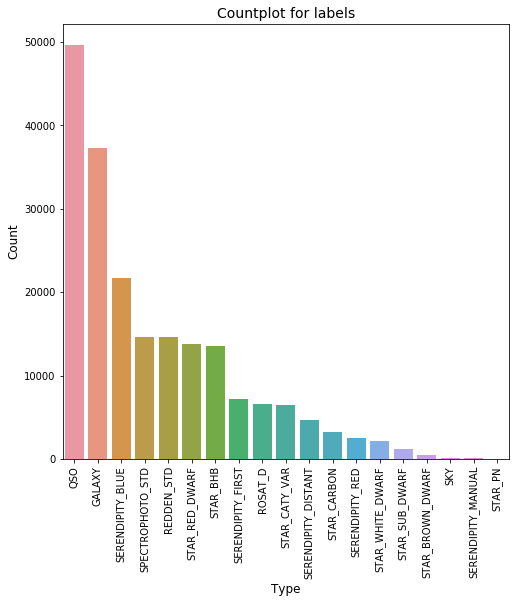

In [8]:
plt.figure(figsize = (8,8))

ax = sns.countplot(train['type'], order = train['type'].value_counts().index)

ax.set_title("Countplot for labels",fontsize = 14)
ax.set_xlabel('Type', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

plt.show()

In [9]:
def VisFeature(data, method = 'hist', scale = None):
    
    
    if method == 'hist':
        data = data.drop(columns = 'type')

        f = plt.figure(figsize = (30,30))
        
        for i, col in enumerate(data.columns):
            f.add_subplot(6,4,i+1)
            sns.distplot(data[col])
            plt.title(col, fontsize = 14)
            plt.xlabel(' ')
            plt.ylabel('Density', fontsize = 12)
    
    if method == 'boxplot':
        df = data.copy()
        df['Type'] = data['type']
        df.drop(columns = 'type',inplace = True)
        
        f = plt.figure(figsize = (15,80))
        
        for i, col in enumerate(df.drop(columns = 'Type').columns):
            f.add_subplot(22, 1, i+1)
            ax = sns.boxplot(x = 'Type', y = col, data = df)
            
            if scale == 'log':
                ax.set_yscale("log")
                ax.set_ylabel("log({})".format(col))
                
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
            f.subplots_adjust(hspace = 0.9)

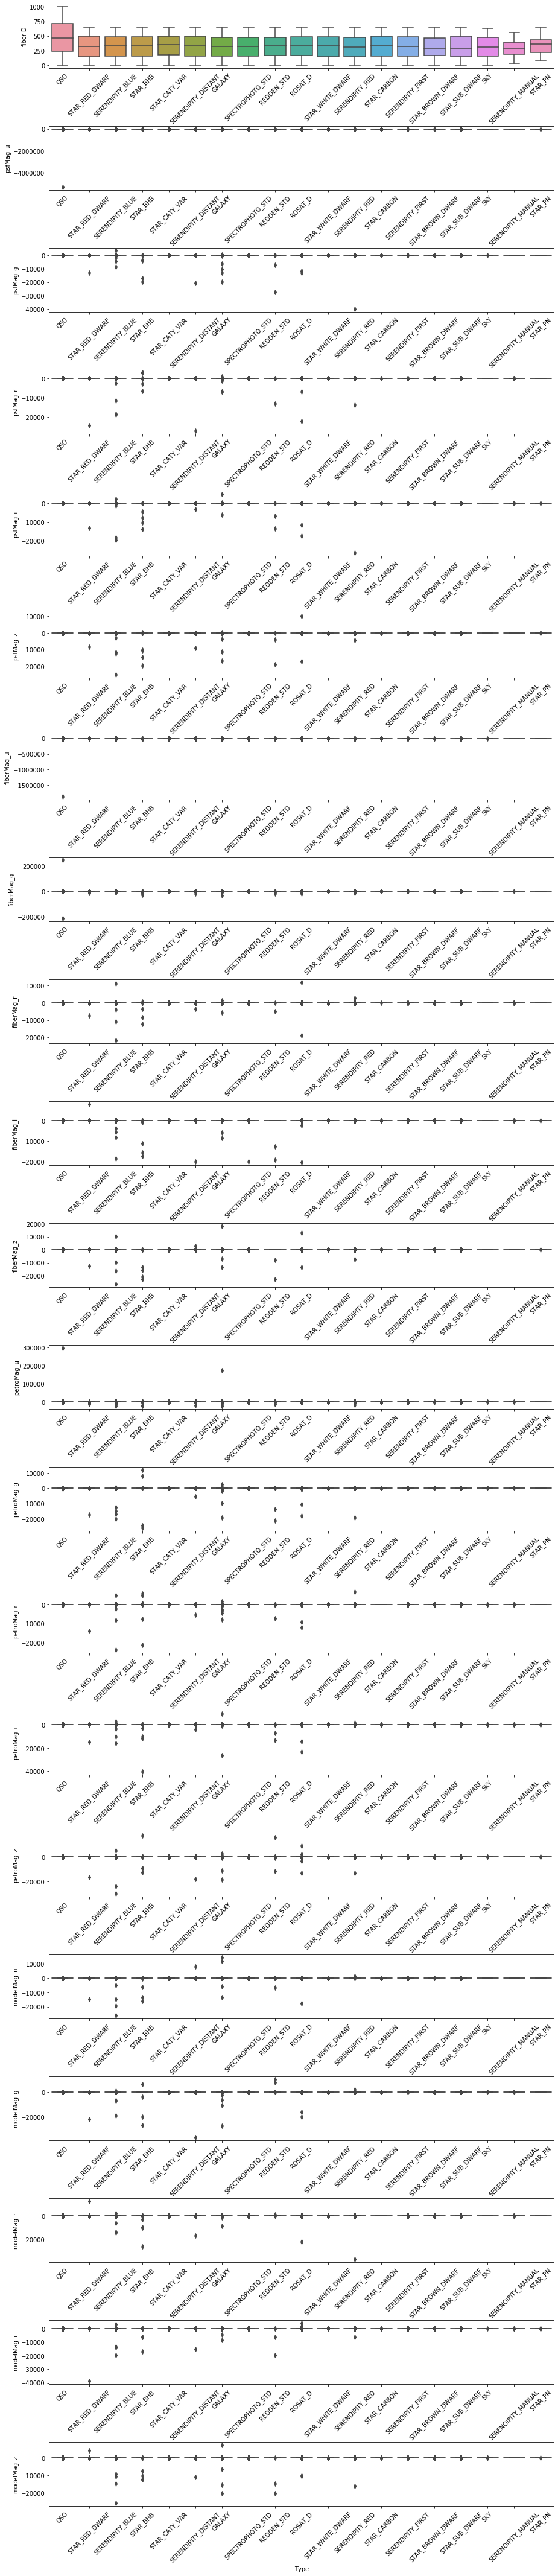

In [10]:
VisFeature(train, method = 'boxplot')

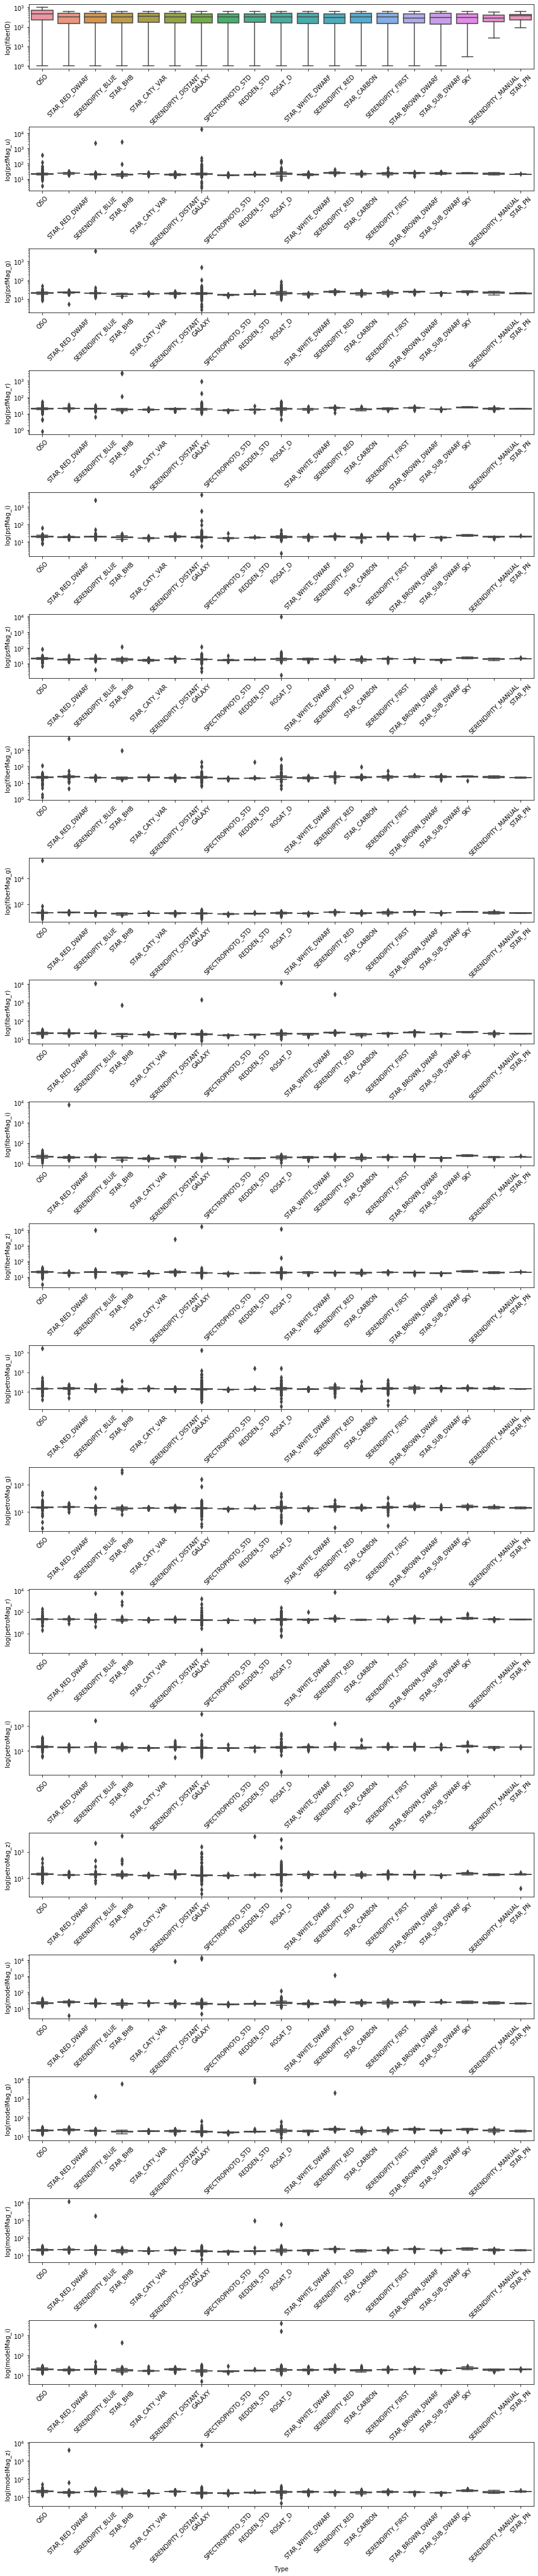

In [11]:
VisFeature(train, method = 'boxplot', scale = "log")

### QSO(Quasar)

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Artist%27s_rendering_ULAS_J1120%2B0641.jpg/450px-Artist%27s_rendering_ULAS_J1120%2B0641.jpg>

'준항성체'라고 불리우며, 블랙홀이 주변 물질을 집어삼키는 에너지에 의해 형성되는 거대 발광체이다.

중심에는 태양의 질량 10억 배나 되는 매우 무거운 블랙홀이 자리를 잡고 있고 그 주위에는 원반이 둘러싸고 있다. 원반의 물질이 회전하며 블랙홀로 떨어지며 물질의 중력 에너지가 빛 에너지로 바뀌변서 거대한 양의 빛이 발생한다.

지금까지 우주에서 발견된 천체들 중 가장 밝고, 강력하며, 활동적인 천체이다. 따라서 지구에서 관측할 수 있는 가장 먼 거리에 있는 천체로, 강한 에너지를 방출하는 <b>활동은하</b>이다. 

매우 큰 <b>적색편이</b>값을 갖는다는 특징을 보인다.

In [12]:
train_qso = train.loc[train['type'] == 'QSO']
print("Num of Quasar Observation : {}".format(train_qso.shape[0]))
print("Pct of Quasar Observation : {}%".format(round(train_qso.shape[0] / train.shape[0] * 100,2)))

Num of Quasar Observation : 49680
Pct of Quasar Observation : 24.84%


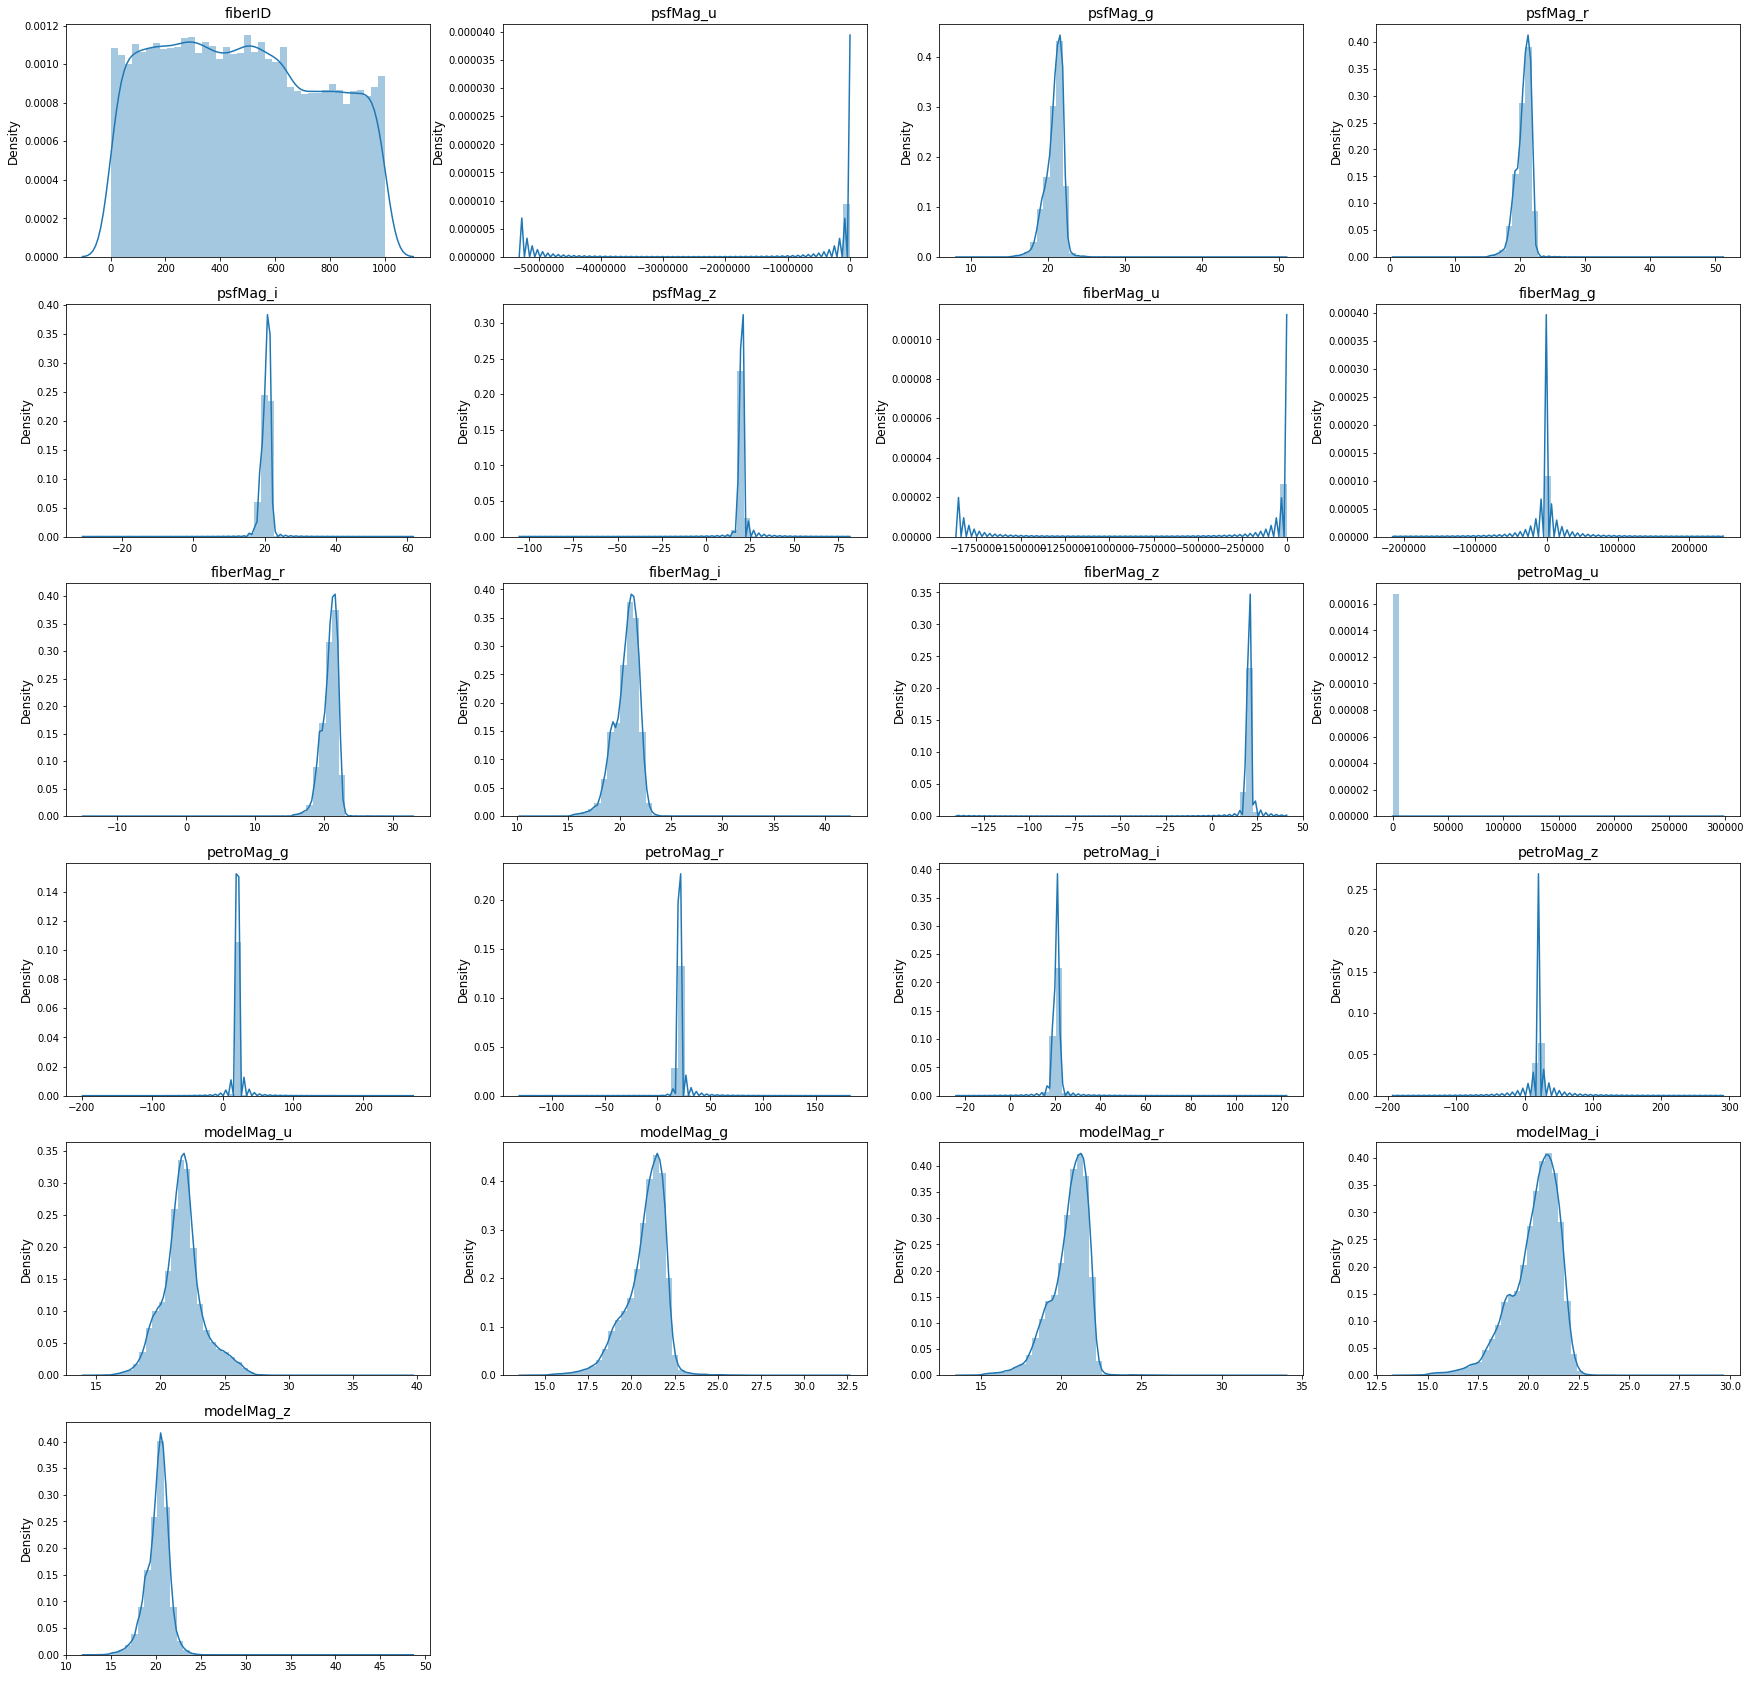

In [13]:
VisFeature(train_qso)

### STAR_RED_DWARF

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/RedDwarfNASA.jpg/450px-RedDwarfNASA.jpg>

'적색왜성'이라고도 불린다. 상대적으로 차가우며 태양의 0.081-0.5배 정도의 가벼운 질량을 지닌 주계열성을 부르는 말이다. 

우주에 존재하는 별들의 약 90퍼센트가 적색왜성으로 알려져있으나, 낮은 광도 때문에 개개의 적색왜성을 관측하기 쉽지않다. 실제로 지구에서 육간으로 관찰할 수 있는 적색왜성은 없으며 태양으로 부터 가장 가까운 별은 '프록시마 센타우리'이다.

적색왜성은 아주 느리게 진화하며 거의 일정한 광도와 등급 형태를 가지고있다. 

In [14]:
train_std = train.loc[train['type'] == 'STAR_RED_DWARF']
print("Num of Star Red Dwarf Observation : {}".format(train_std.shape[0]))
print("Pct of Star Red Dwarf Observation : {}%".format(round(train_std.shape[0] / train.shape[0] * 100,2)))

Num of Star Red Dwarf Observation : 13750
Pct of Star Red Dwarf Observation : 6.88%


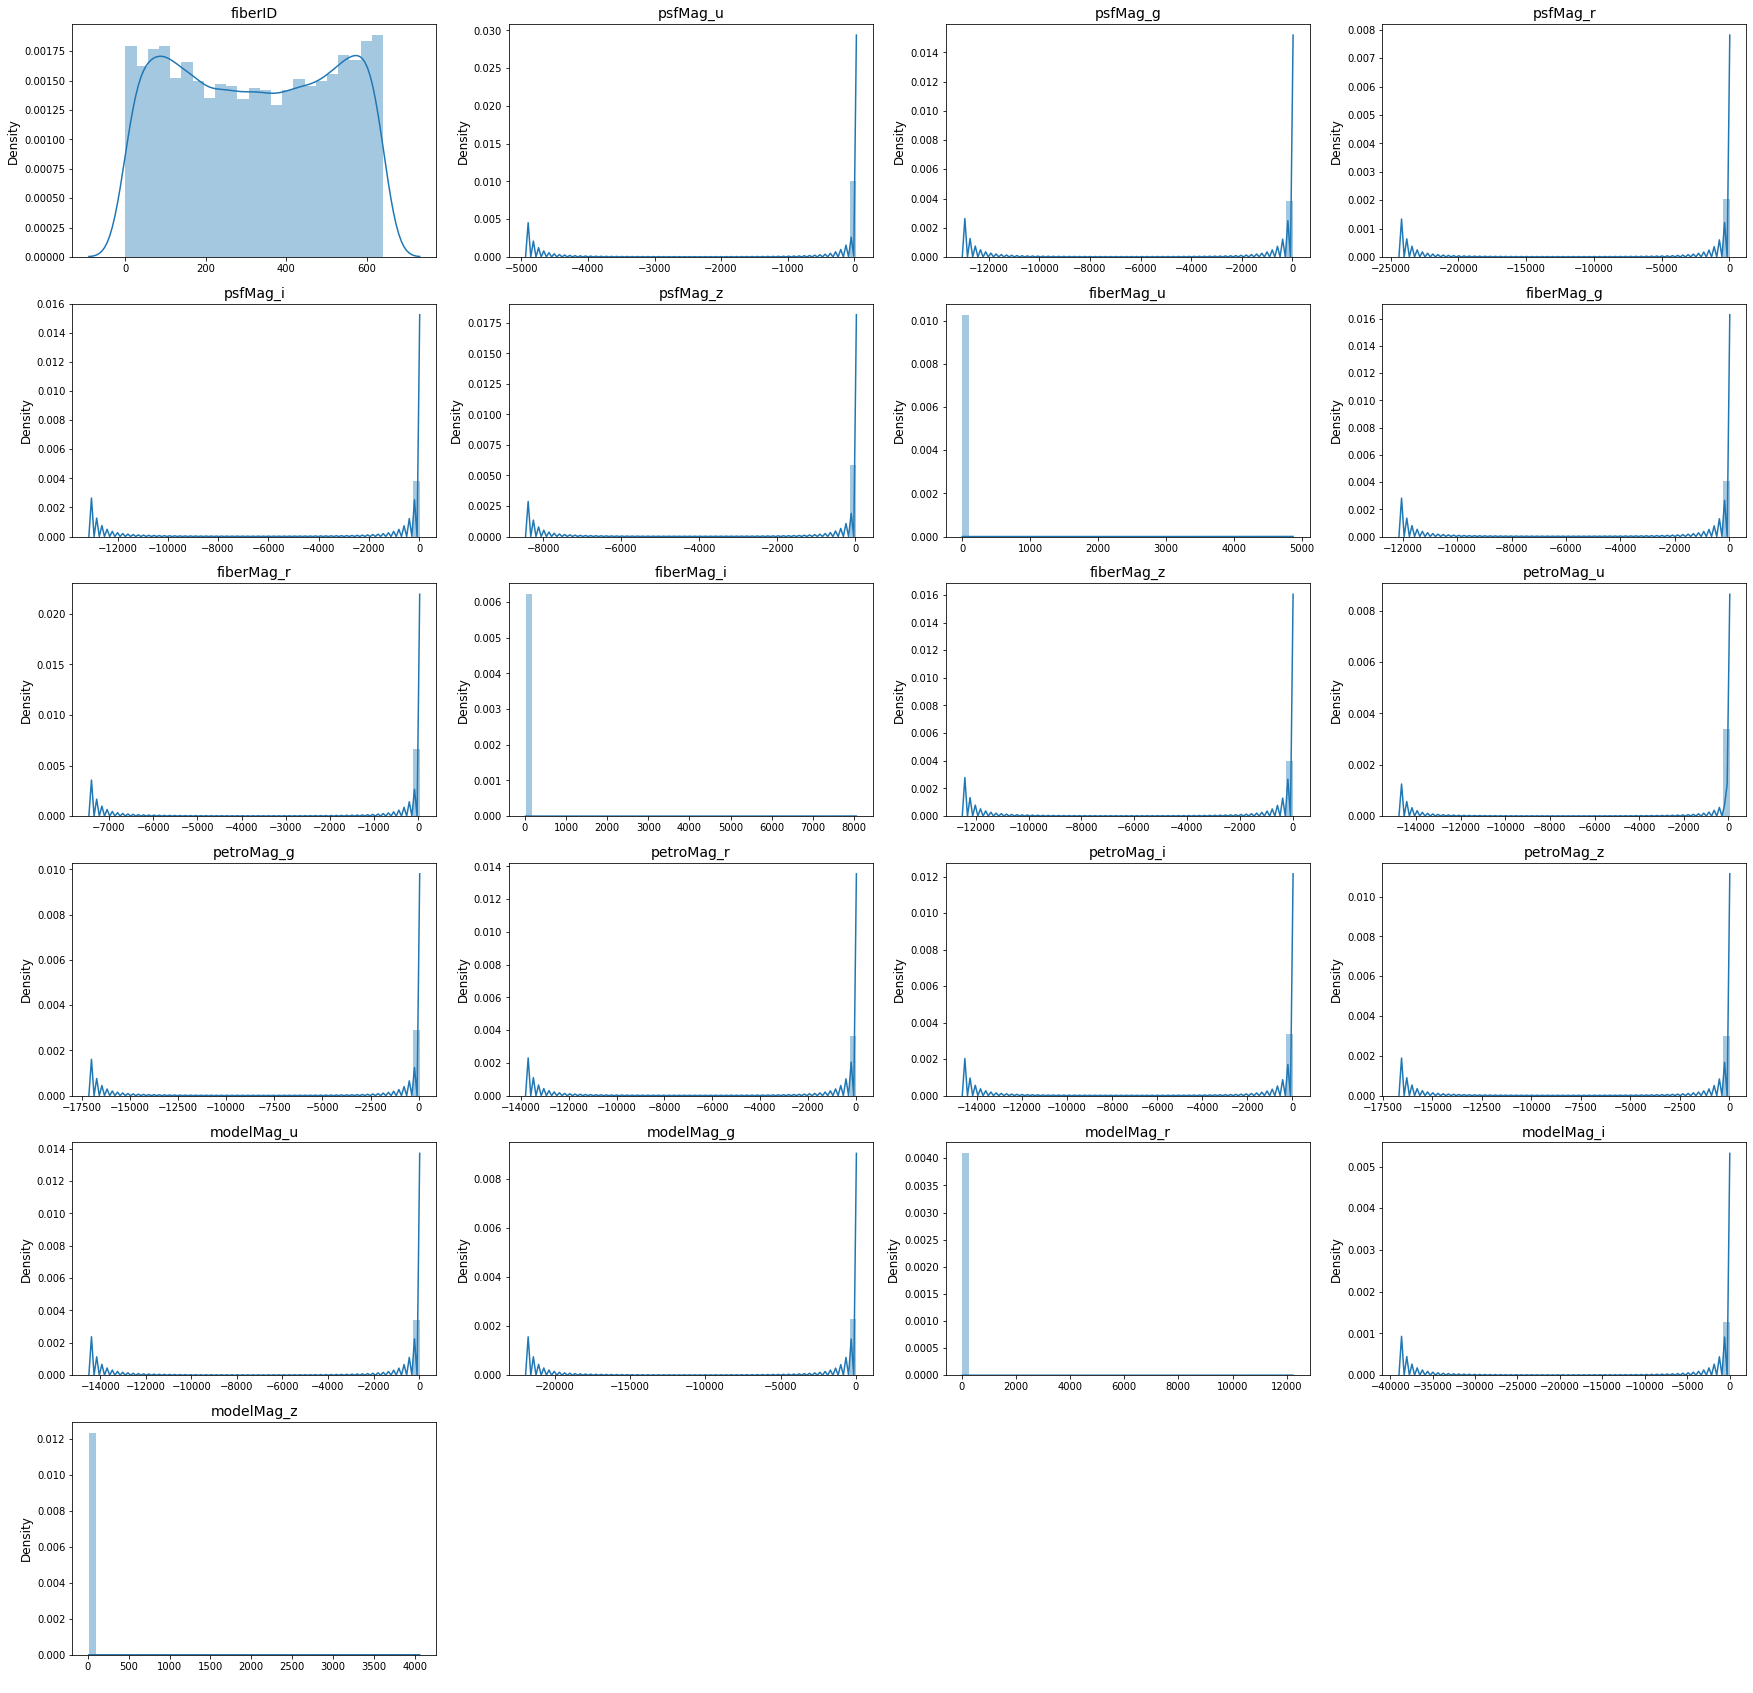

In [15]:
VisFeature(train_std)

### SERENDIPITY_BLUE
알 수 없음. TO-DO

In [16]:
train_sb = train.loc[train['type'] == 'SERENDIPITY_BLUE']
print("Num of SERENDIPTY BLUE Observation : {}".format(train_sb.shape[0]))
print("Pct of SERENDIPTY BLUE Observation : {}%".format(round(train_sb.shape[0] / train.shape[0] * 100,2)))

Num of SERENDIPTY BLUE Observation : 21760
Pct of SERENDIPTY BLUE Observation : 10.88%


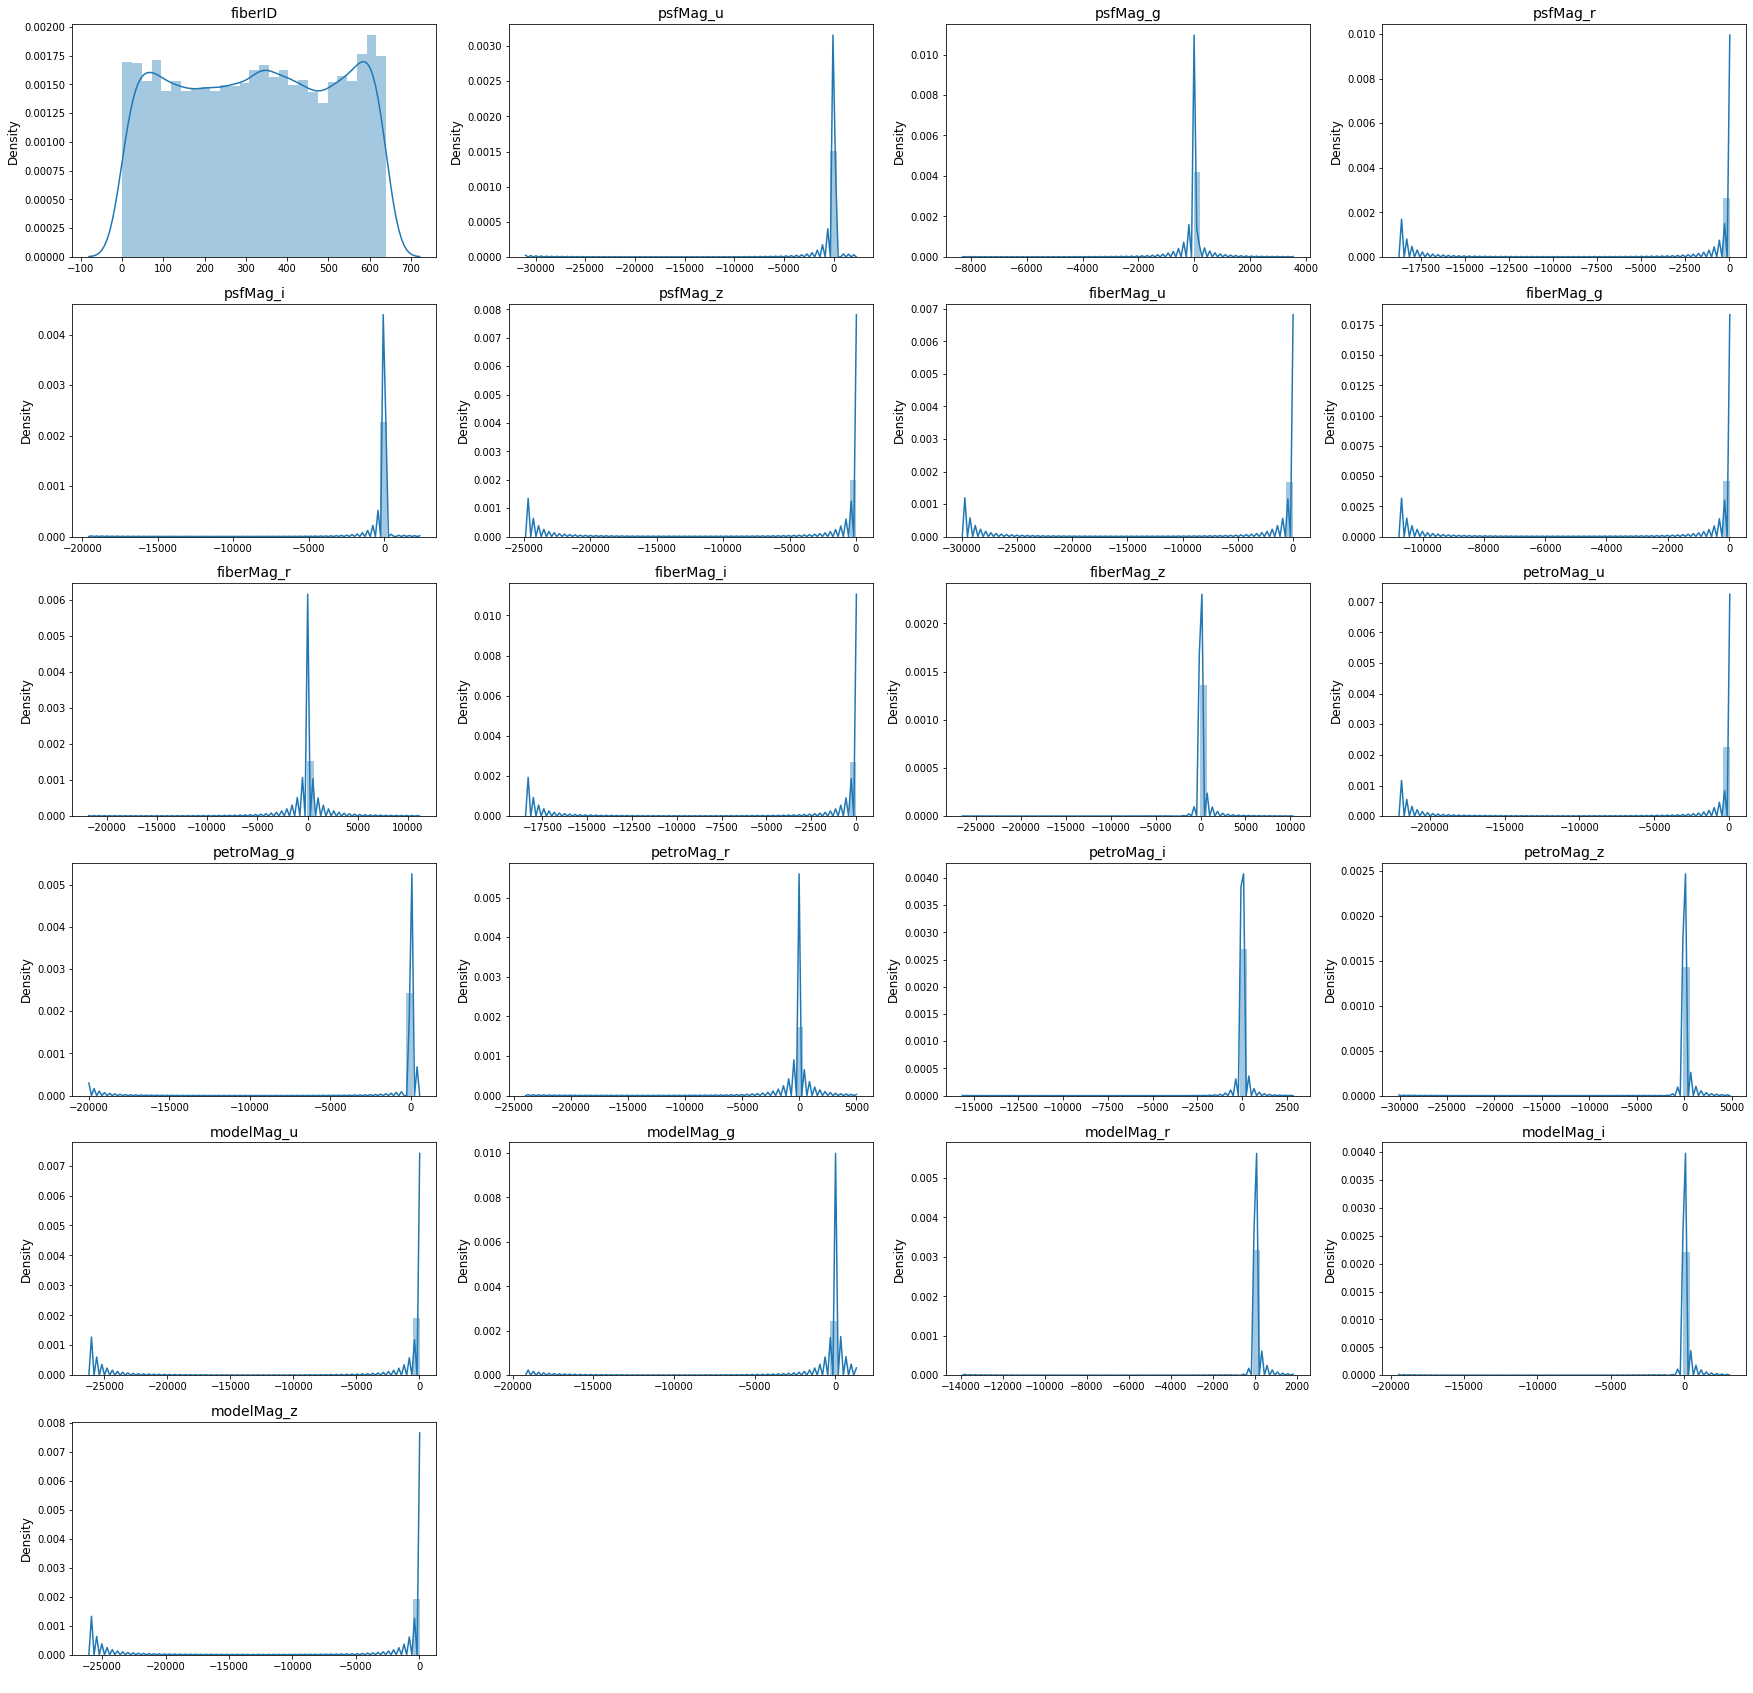

In [17]:
VisFeature(train_sb)

### STAR_BHB(Horizontal Branch)

'수평거성열'이라고 불리며, 태양과 비슷한 질량의 별에서 적색거성가지를 뒤따르는 항성진화의 한 단계이다. 

적색거성가지의 꼭대기에서 발생하는 핼륨핵 섬광은 항성구조의 상당한 변화를 야기한다. 그 결과, 광도의 전반적인 감소와 표면온도의 상승이 이루어진다. 

In [18]:
train_bh = train.loc[train['type'] == 'STAR_BHB']
print("Num of Horizontal Branch Observation : {}".format(train_bh.shape[0]))
print("Pct of Horizontal Branch Observation : {}%".format(round(train_bh.shape[0] / train.shape[0] * 100,2)))

Num of Horizontal Branch Observation : 13500
Pct of Horizontal Branch Observation : 6.75%


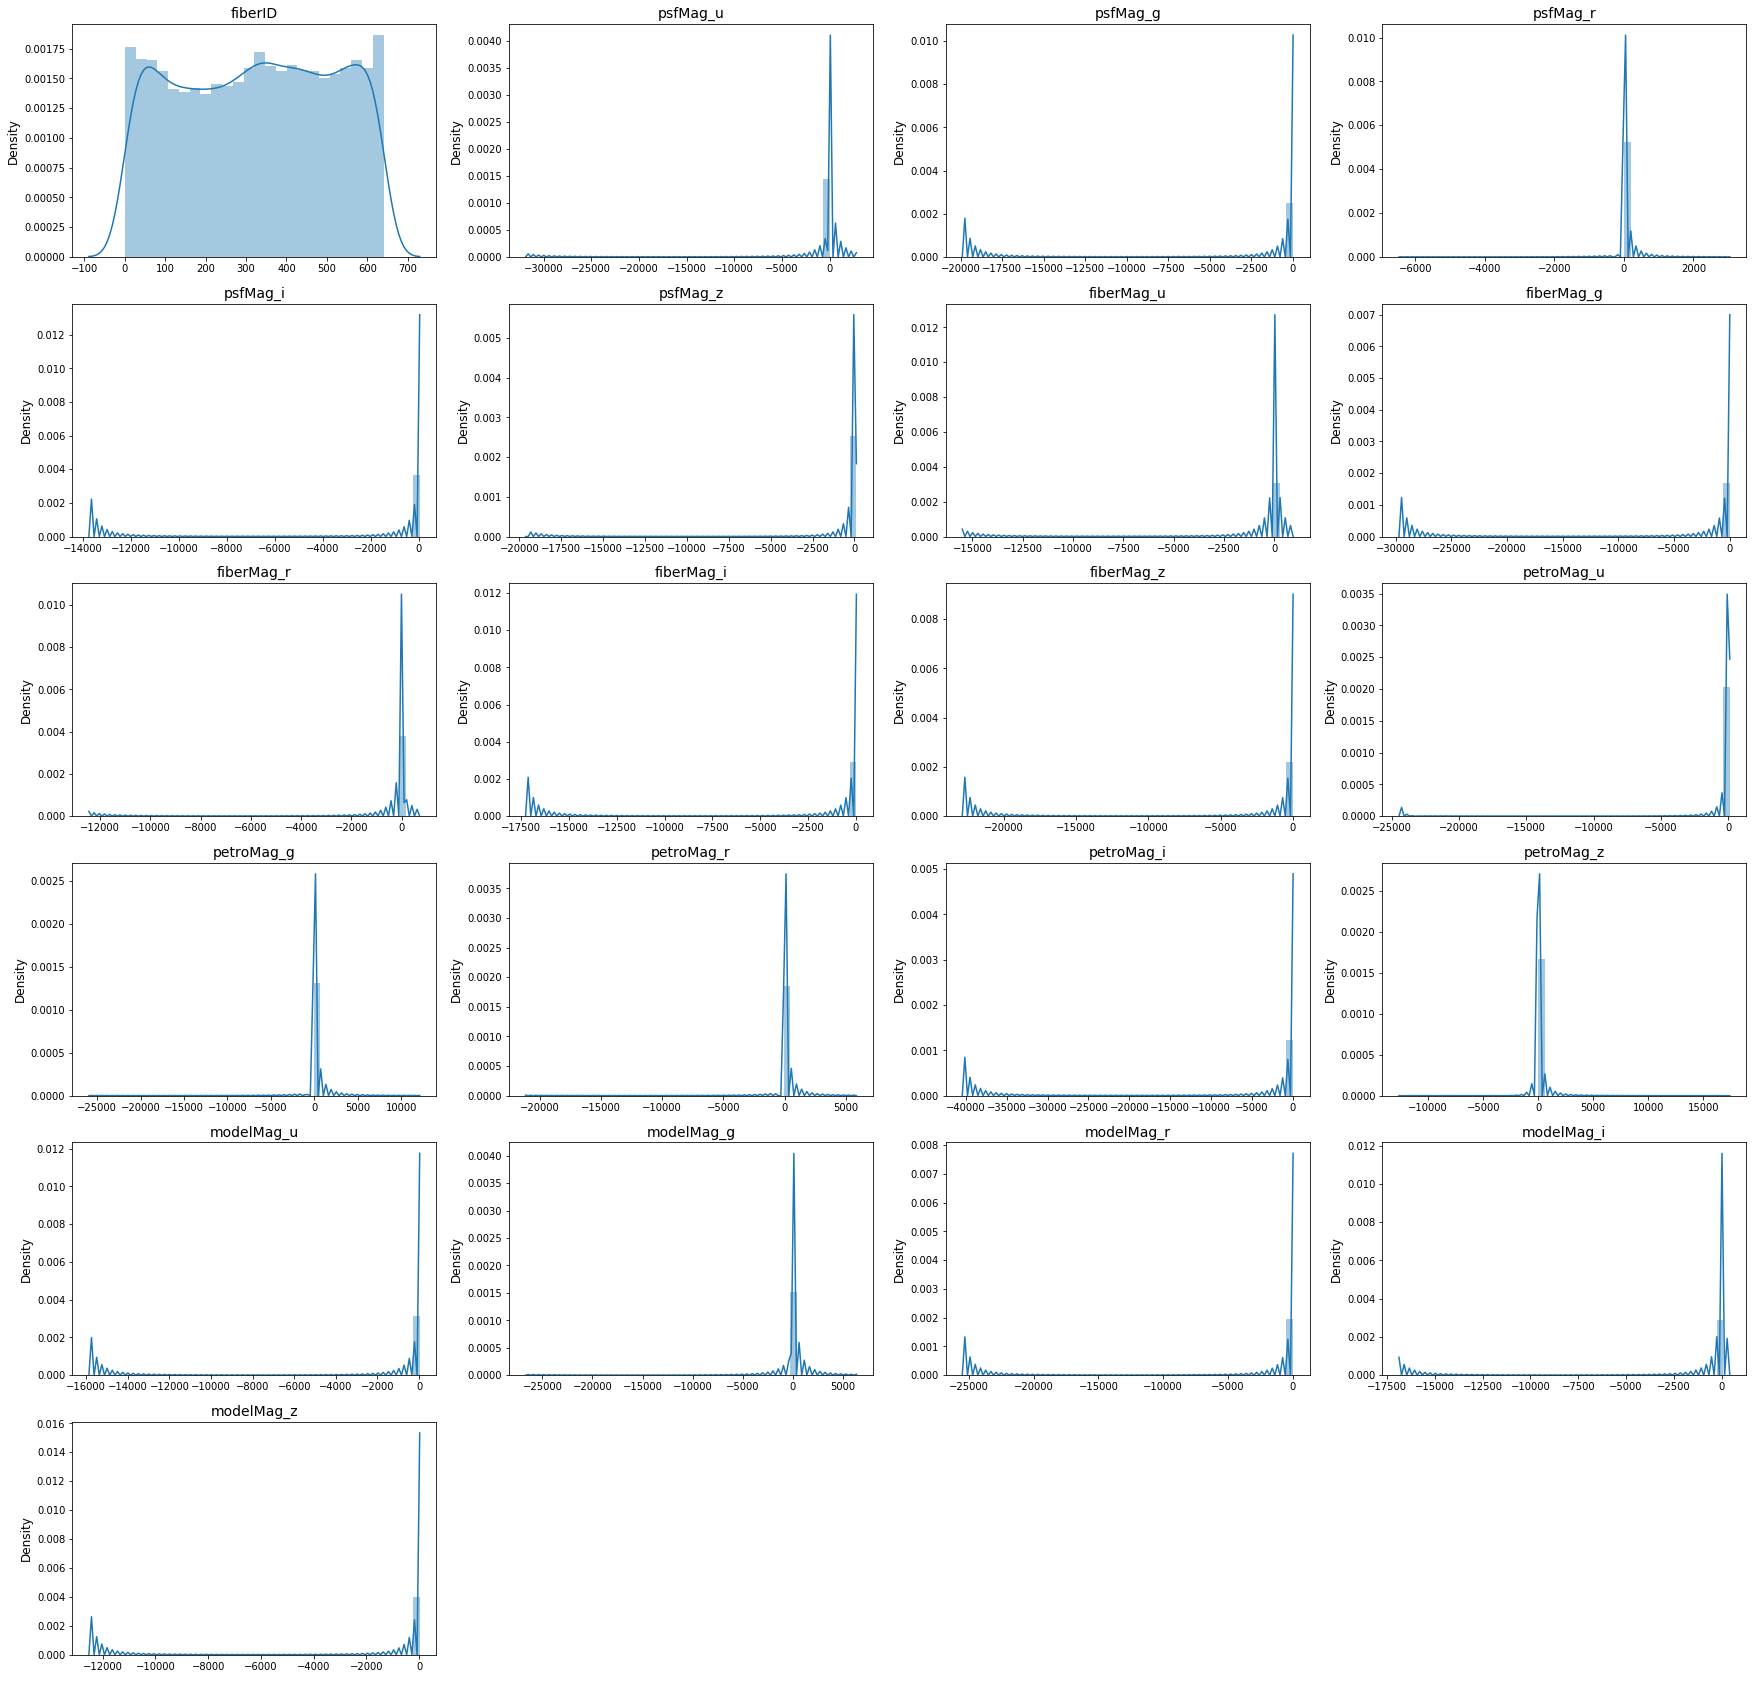

In [19]:
VisFeature(train_bh)

### SERENDIPITY_DISTANT
알 수 없음. TO-DO

In [20]:
train_sd = train.loc[train['type'] == 'SERENDIPITY_DISTANT']
print("Num of SERENDIPITY DISTANT Observation : {}".format(train_sd.shape[0]))
print("Pct of SERENDIPITY DISTANT Observation : {}%".format(round(train_sd.shape[0] / train.shape[0] * 100,2)))

Num of SERENDIPITY DISTANT Observation : 4654
Pct of SERENDIPITY DISTANT Observation : 2.33%


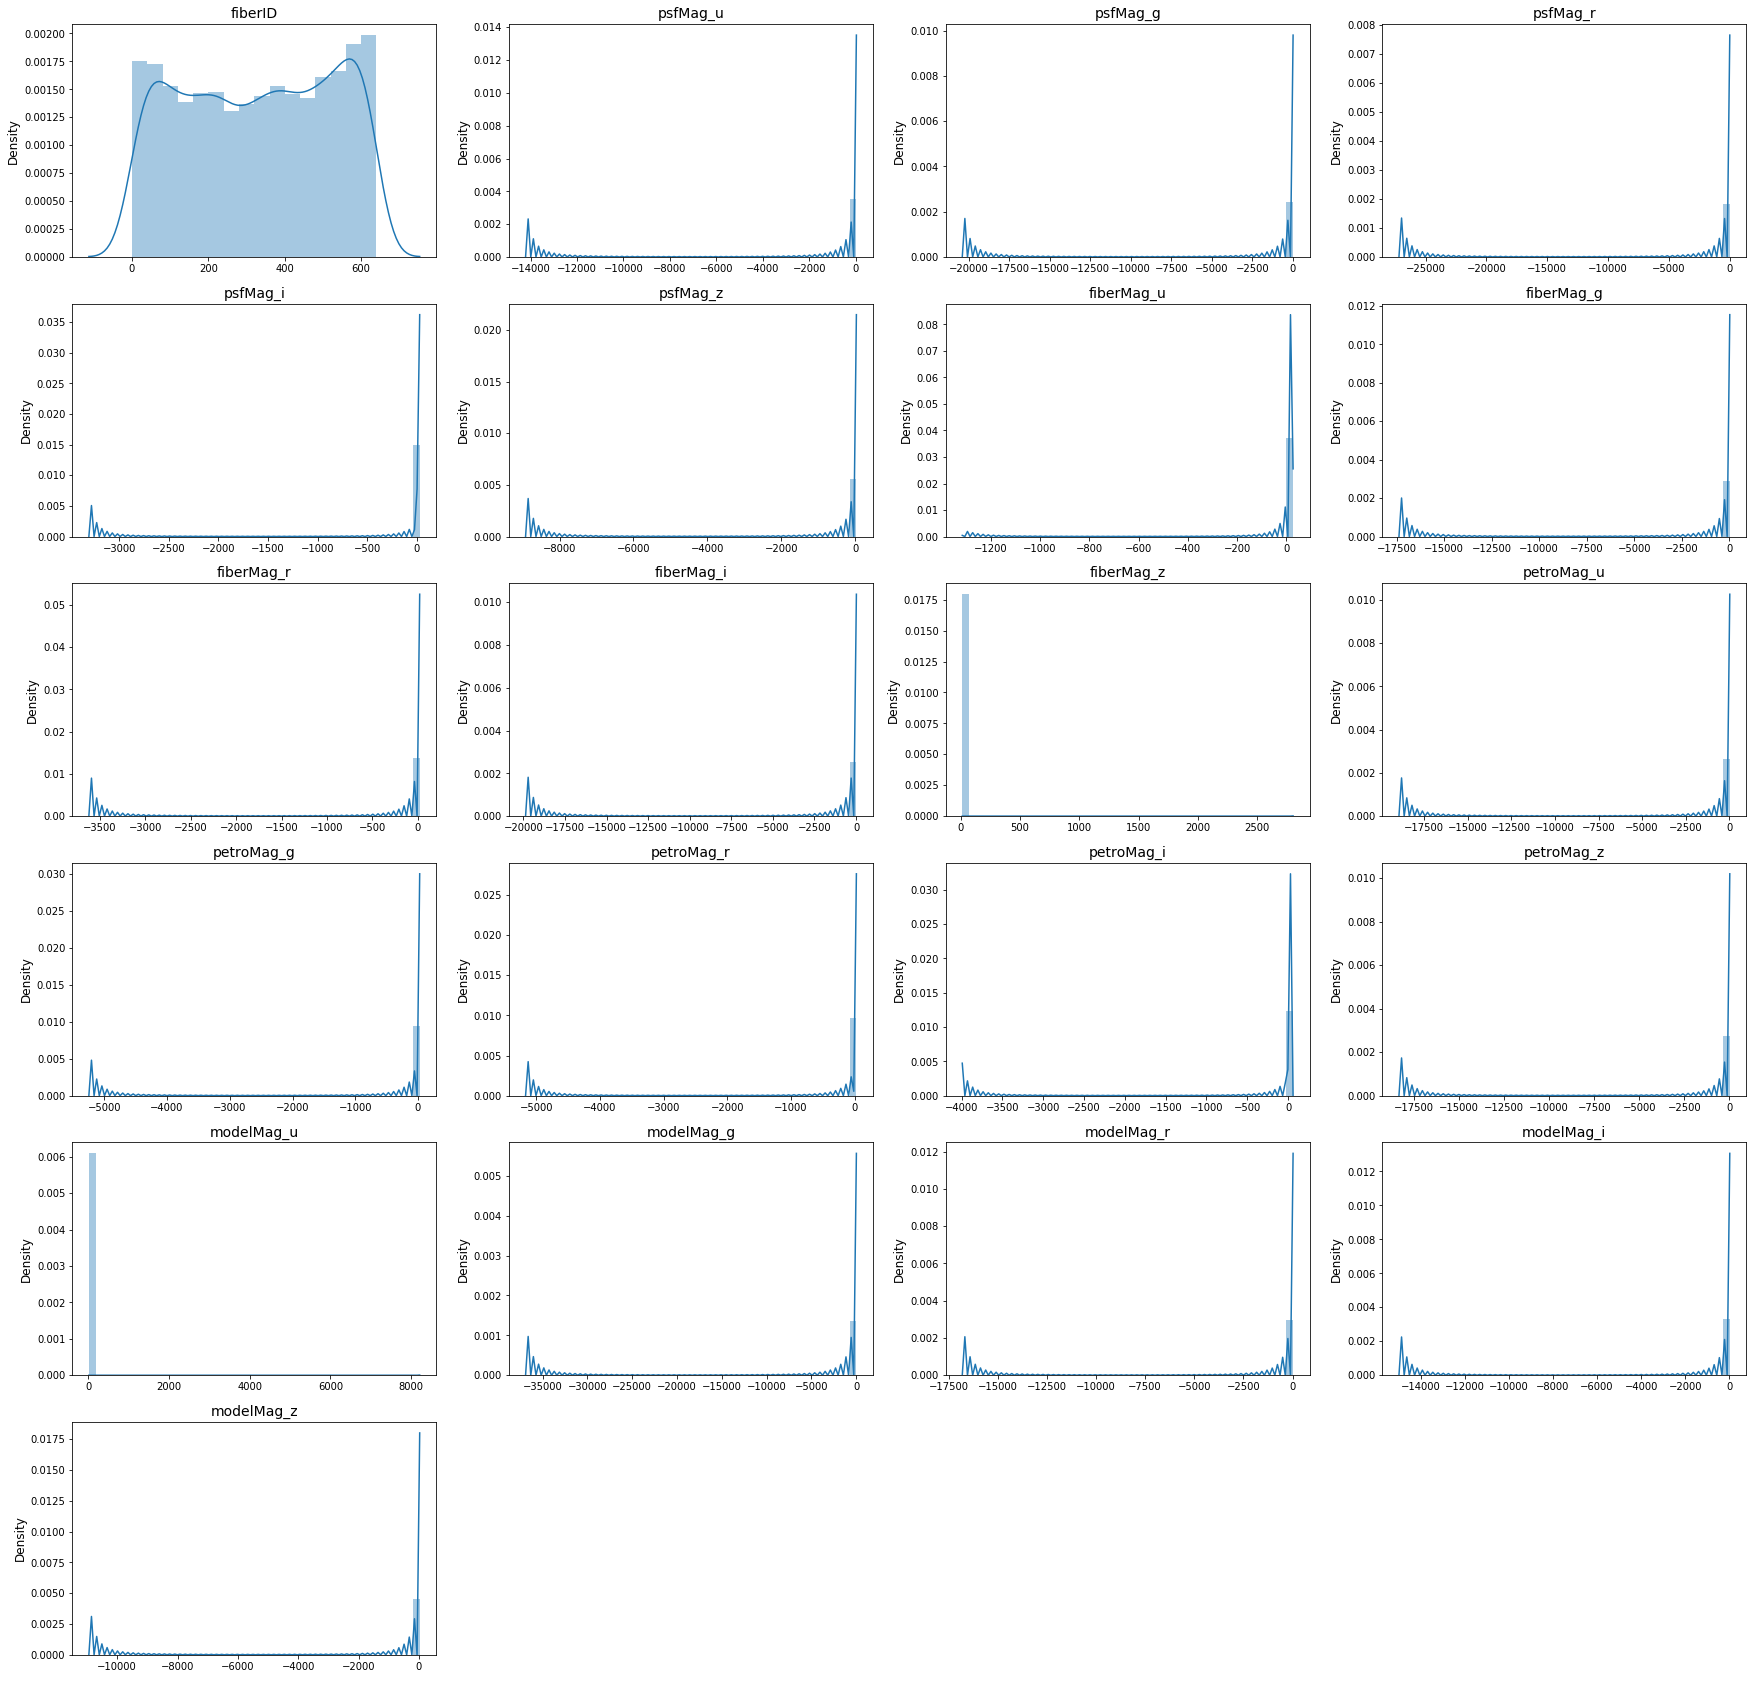

In [21]:
VisFeature(train_sd)

### GALAXY
<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/NGC_4414_%28NASA-med%29.jpg/450px-NGC_4414_%28NASA-med%29.jpg>

'은하'라고 불리며, 항성, 밀집성, 성간 물질, 암흑 물질 등이 중력에 의해 묶여져 이루는 거대한 천체들의 무리이다.

수많은 항성계, 성단, 성간운들이 존재하며, 이 사이 공간은 가스, 먼지, 우주선들로 이루어진 성간물질들로 채워져 있다. 

In [22]:
train_galaxy = train.loc[train['type'] == 'GALAXY']
print("Num of Galaxy Observation : {}".format(train_galaxy.shape[0]))
print("Pct of Galaxy Observation : {}%".format(round(train_galaxy.shape[0] / train.shape[0] * 100,2)))

Num of Galaxy Observation : 37347
Pct of Galaxy Observation : 18.67%


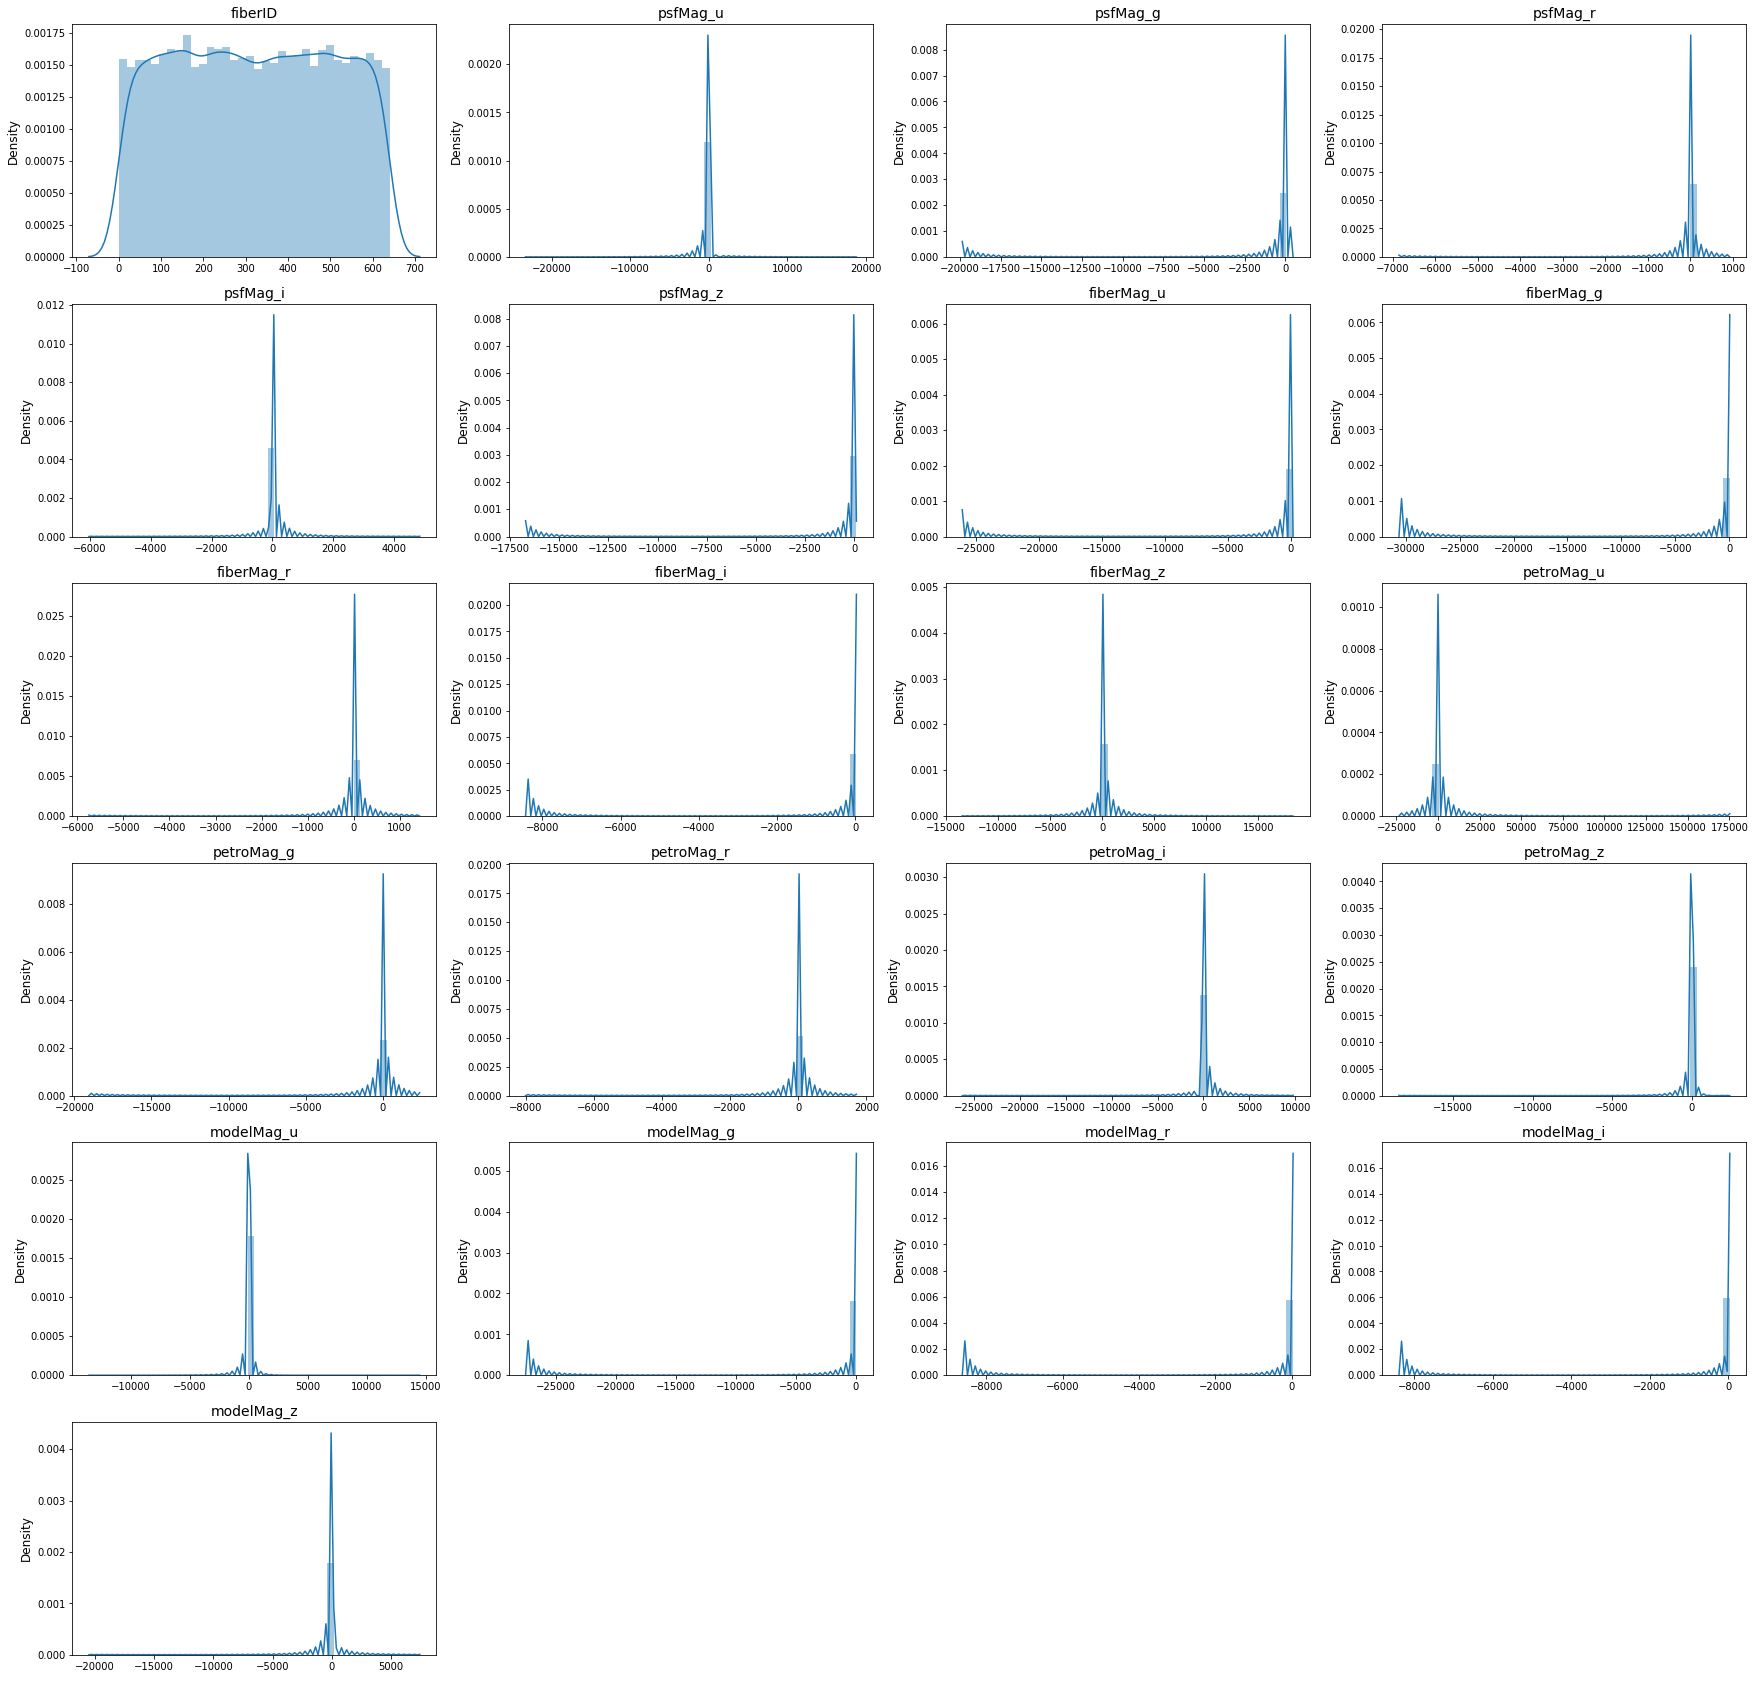

In [23]:
VisFeature(train_galaxy)

### SPECTROPHOTO_STD

<img src=https://www.scienceall.com/nas/image/201303/DP311_23.jpg width="500">

'분광 쌍성'으로 예상되는 라벨이다. 

육안이나 망원경으로 볼 때 마치 하나의 별처럼 보이지만, 실제로는 두 개의 별이 가까이 붙어있는 상성을 말한다. 

분광쌍성의 각 구성원은 질량중심을 따라 공전하며 관측자의 시야에서 멀어졌다가 가까워졌다가를 반복한다. 관측자에게서 멀어지면 붉은 색이, 가까워지면 푸른 색이 나타난다.

In [24]:
train_ss = train.loc[train['type'] == 'SPECTROPHOTO_STD']
print("Num of SPECTROPHOTO STD Observation : {}".format(train_ss.shape[0]))
print("Pct of SPECTROPHOTO STD Observation : {}%".format(round(train_ss.shape[0] / train.shape[0] * 100,2)))

Num of SPECTROPHOTO STD Observation : 14630
Pct of SPECTROPHOTO STD Observation : 7.32%


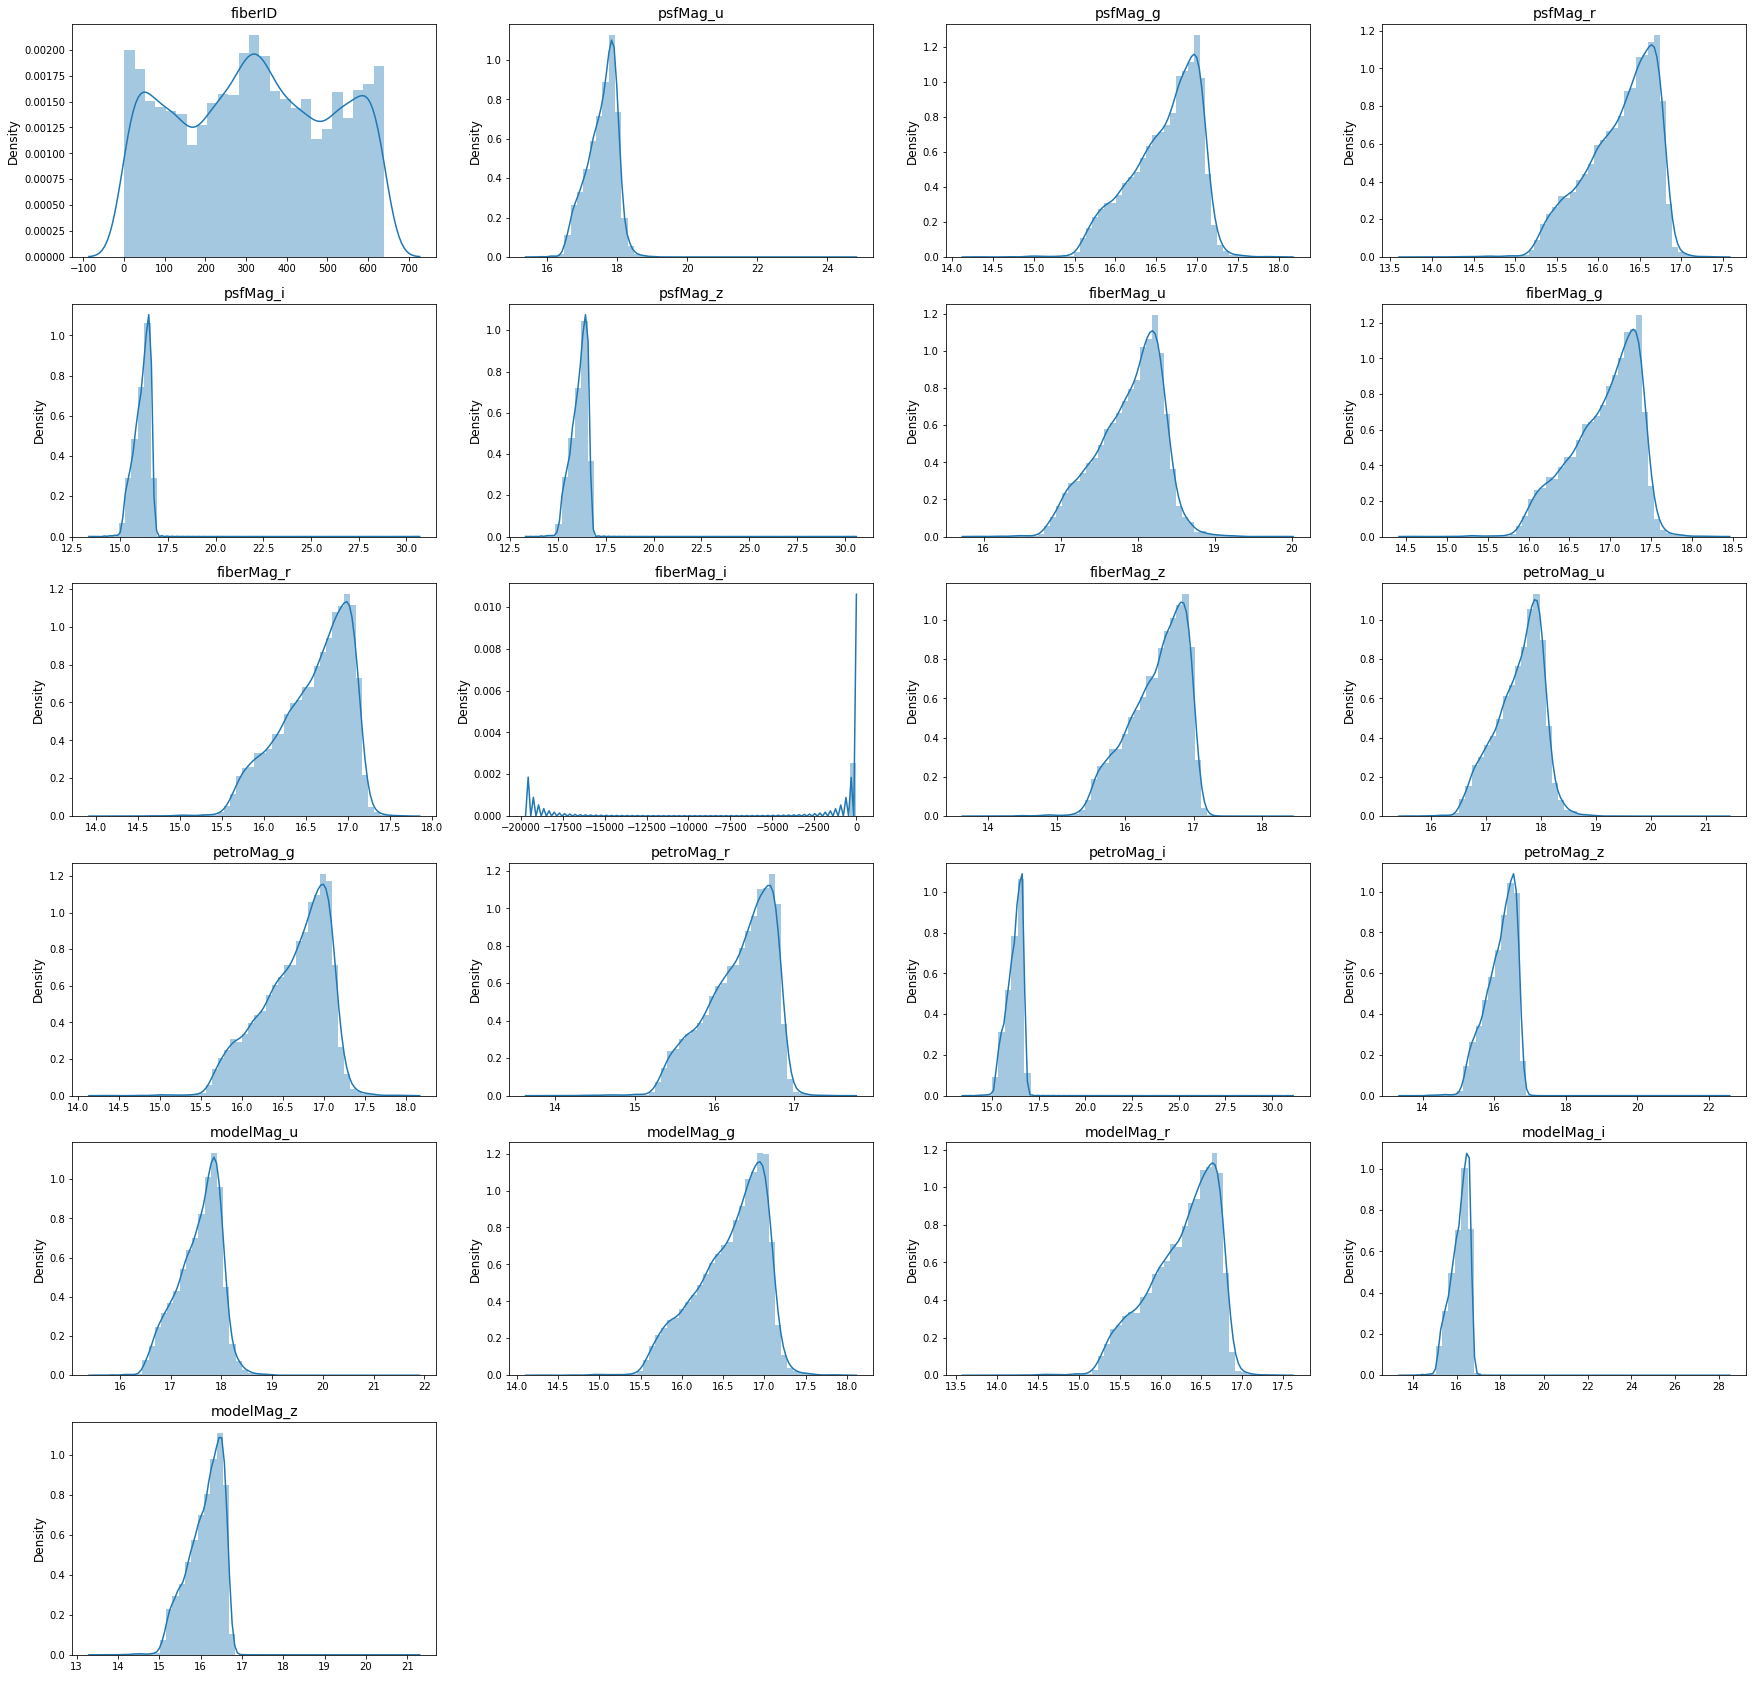

In [25]:
VisFeature(train_ss)

### REDDEN_STD 
알 수 없음. TO-DO

In [26]:
train_rt = train.loc[train['type'] == 'REDDEN_STD']
print("Num of REDDEN STD Observation : {}".format(train_rt.shape[0]))
print("Pct of REDDEN STD Observation : {}%".format(round(train_rt.shape[0] / train.shape[0] * 100,2)))

Num of REDDEN STD Observation : 14618
Pct of REDDEN STD Observation : 7.31%


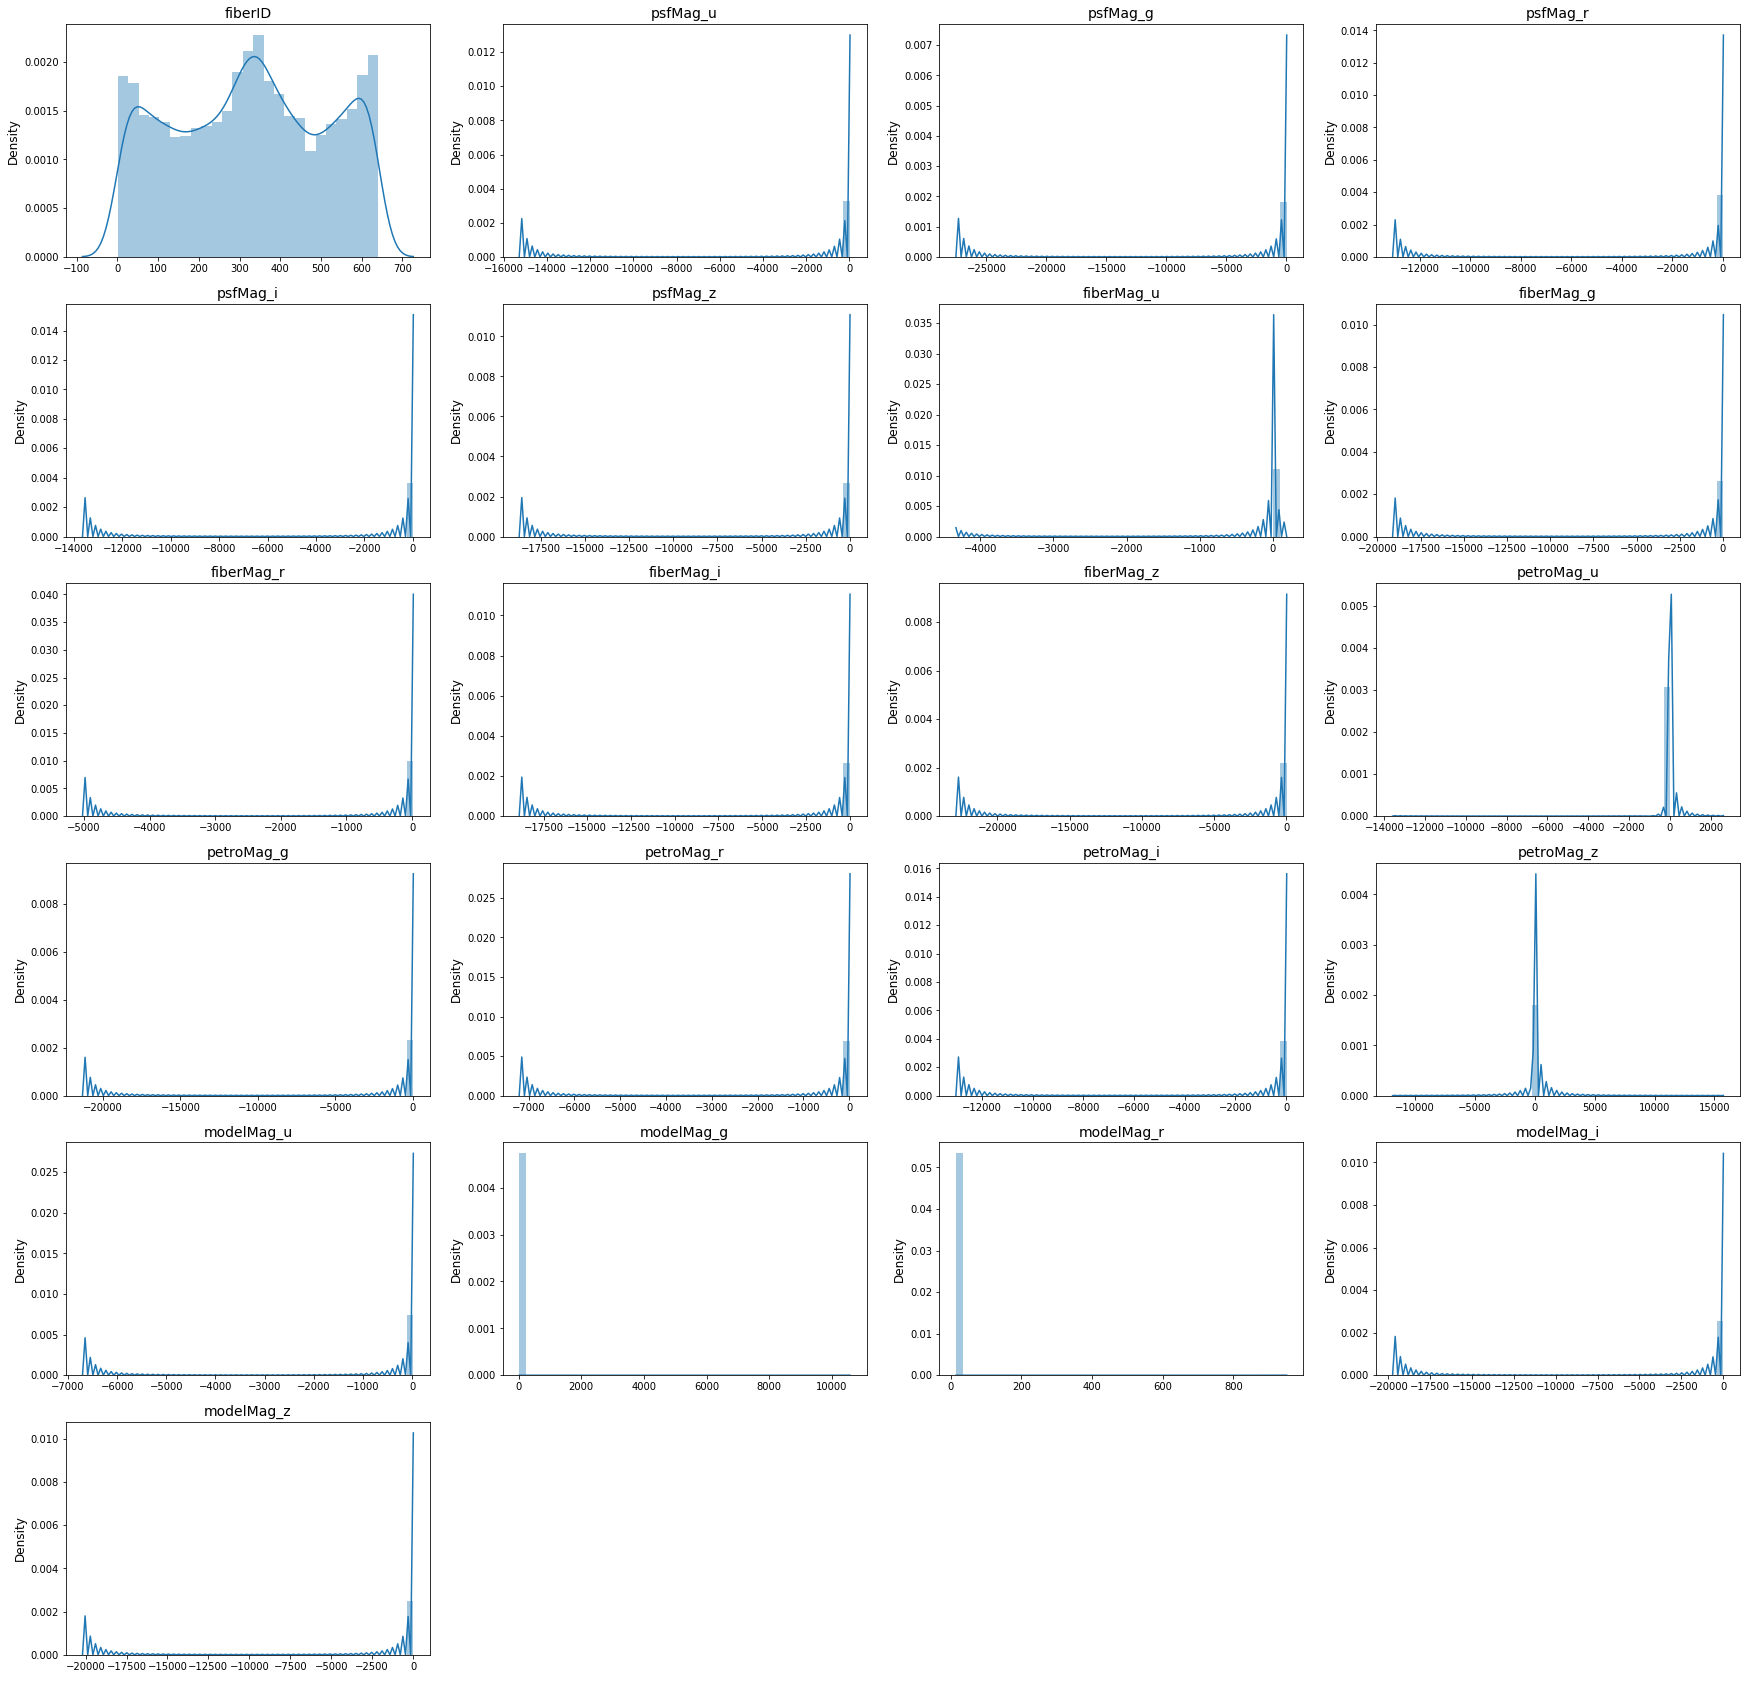

In [27]:
VisFeature(train_rt)

### ROSAT_STD
알 수 없음. TO-DO

In [28]:
train_rd = train.loc[train['type'] == 'ROSAT_D']
print("Num of ROSAT D Observation : {}".format(train_rd.shape[0]))
print("Pct of ROSAT D Observation : {}%".format(round(train_rd.shape[0] / train.shape[0] * 100,2)))

Num of ROSAT D Observation : 6580
Pct of ROSAT D Observation : 3.29%


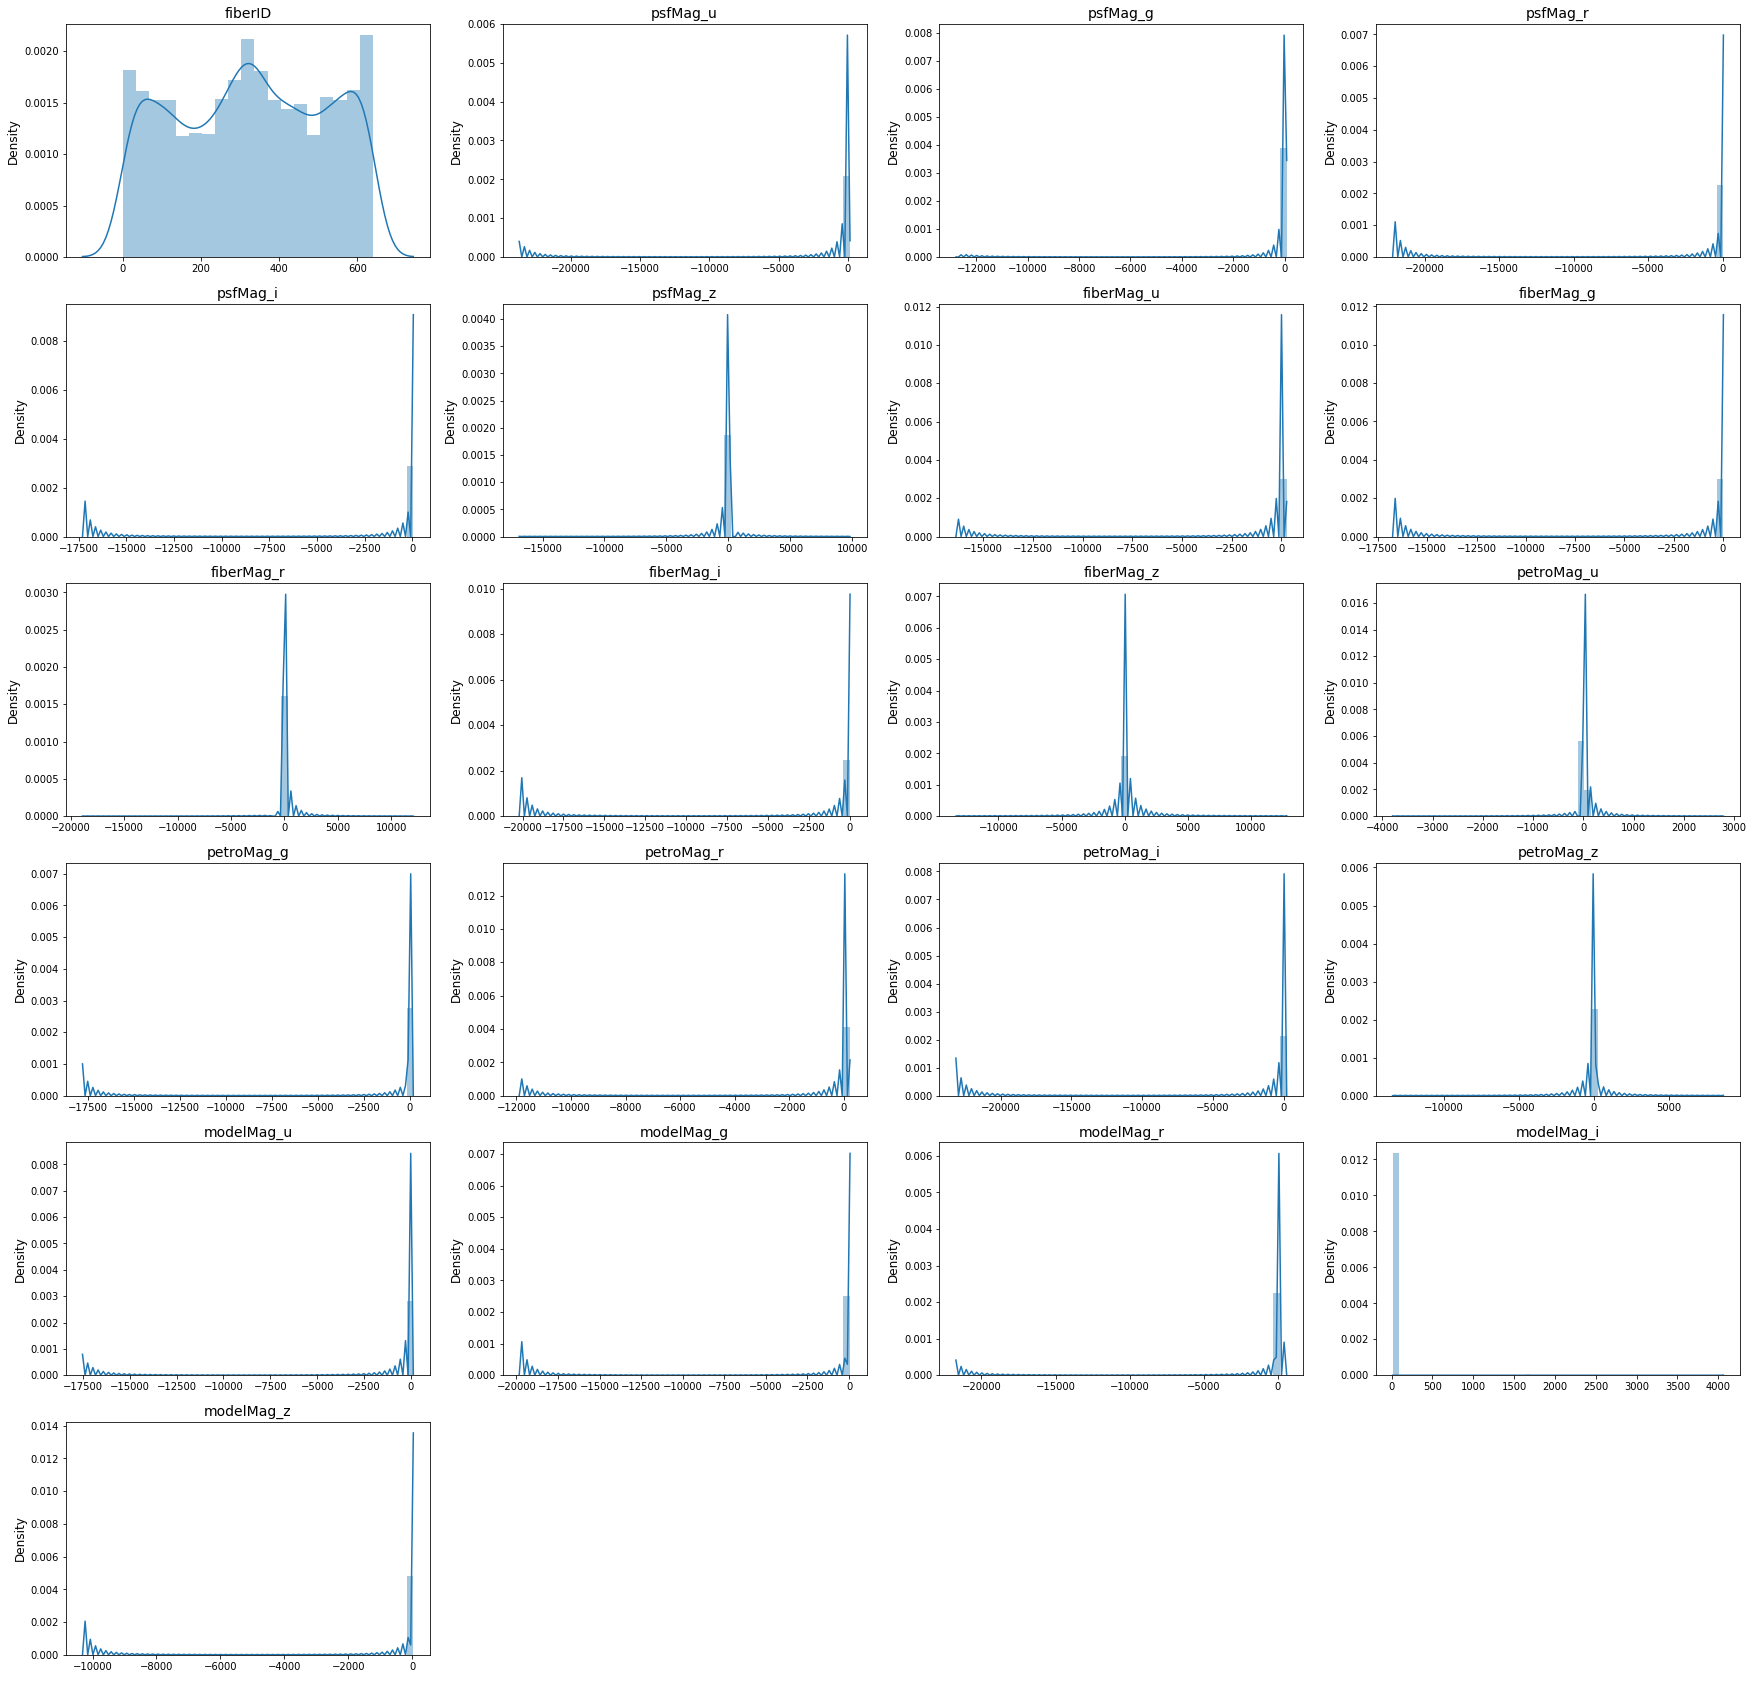

In [29]:
VisFeature(train_rd)

### STAR_WHITE_DWARF
<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Sirius_A_and_B_Hubble_photo.jpg/330px-Sirius_A_and_B_Hubble_photo.jpg>

'백색왜성'이라고 불리며, 중간 이하의 질량을 지닌 항성이 행융합을 마치고 도달하는 천체이다.

상대적으로 가벼운 질량 때문에, 중심핵이 붕괴되어 온도와 압력이 상승하더라도 탄소 핵융합을 일으킬 만큼 충분한 온도에 도달하지 못한다. 

대부분 탄소와 산소로 이루어진 핵만이 남아있다.

더 이상 핵융합이 일어나지 않기 떄문에, 에너지를 생성할 수없다. 따라서 온도가 점차 낮아지며, 핵이 중력에 의해 붕괴하는 것을 막지 못하며, 매우 밀도가 높은 상태가 된다. 

매우 흔한 편이며, 전체 항성 가운데 6% 정도를 차지하고 있다.

In [30]:
train_swd = train.loc[train['type'] == 'STAR_WHITE_DWARF']
print("Num of White Dwarf Observation : {}".format(train_swd.shape[0]))
print("Pct of white Dwarf Observation : {}%".format(round(train_swd.shape[0] / train.shape[0] * 100,2)))

Num of White Dwarf Observation : 2160
Pct of white Dwarf Observation : 1.08%


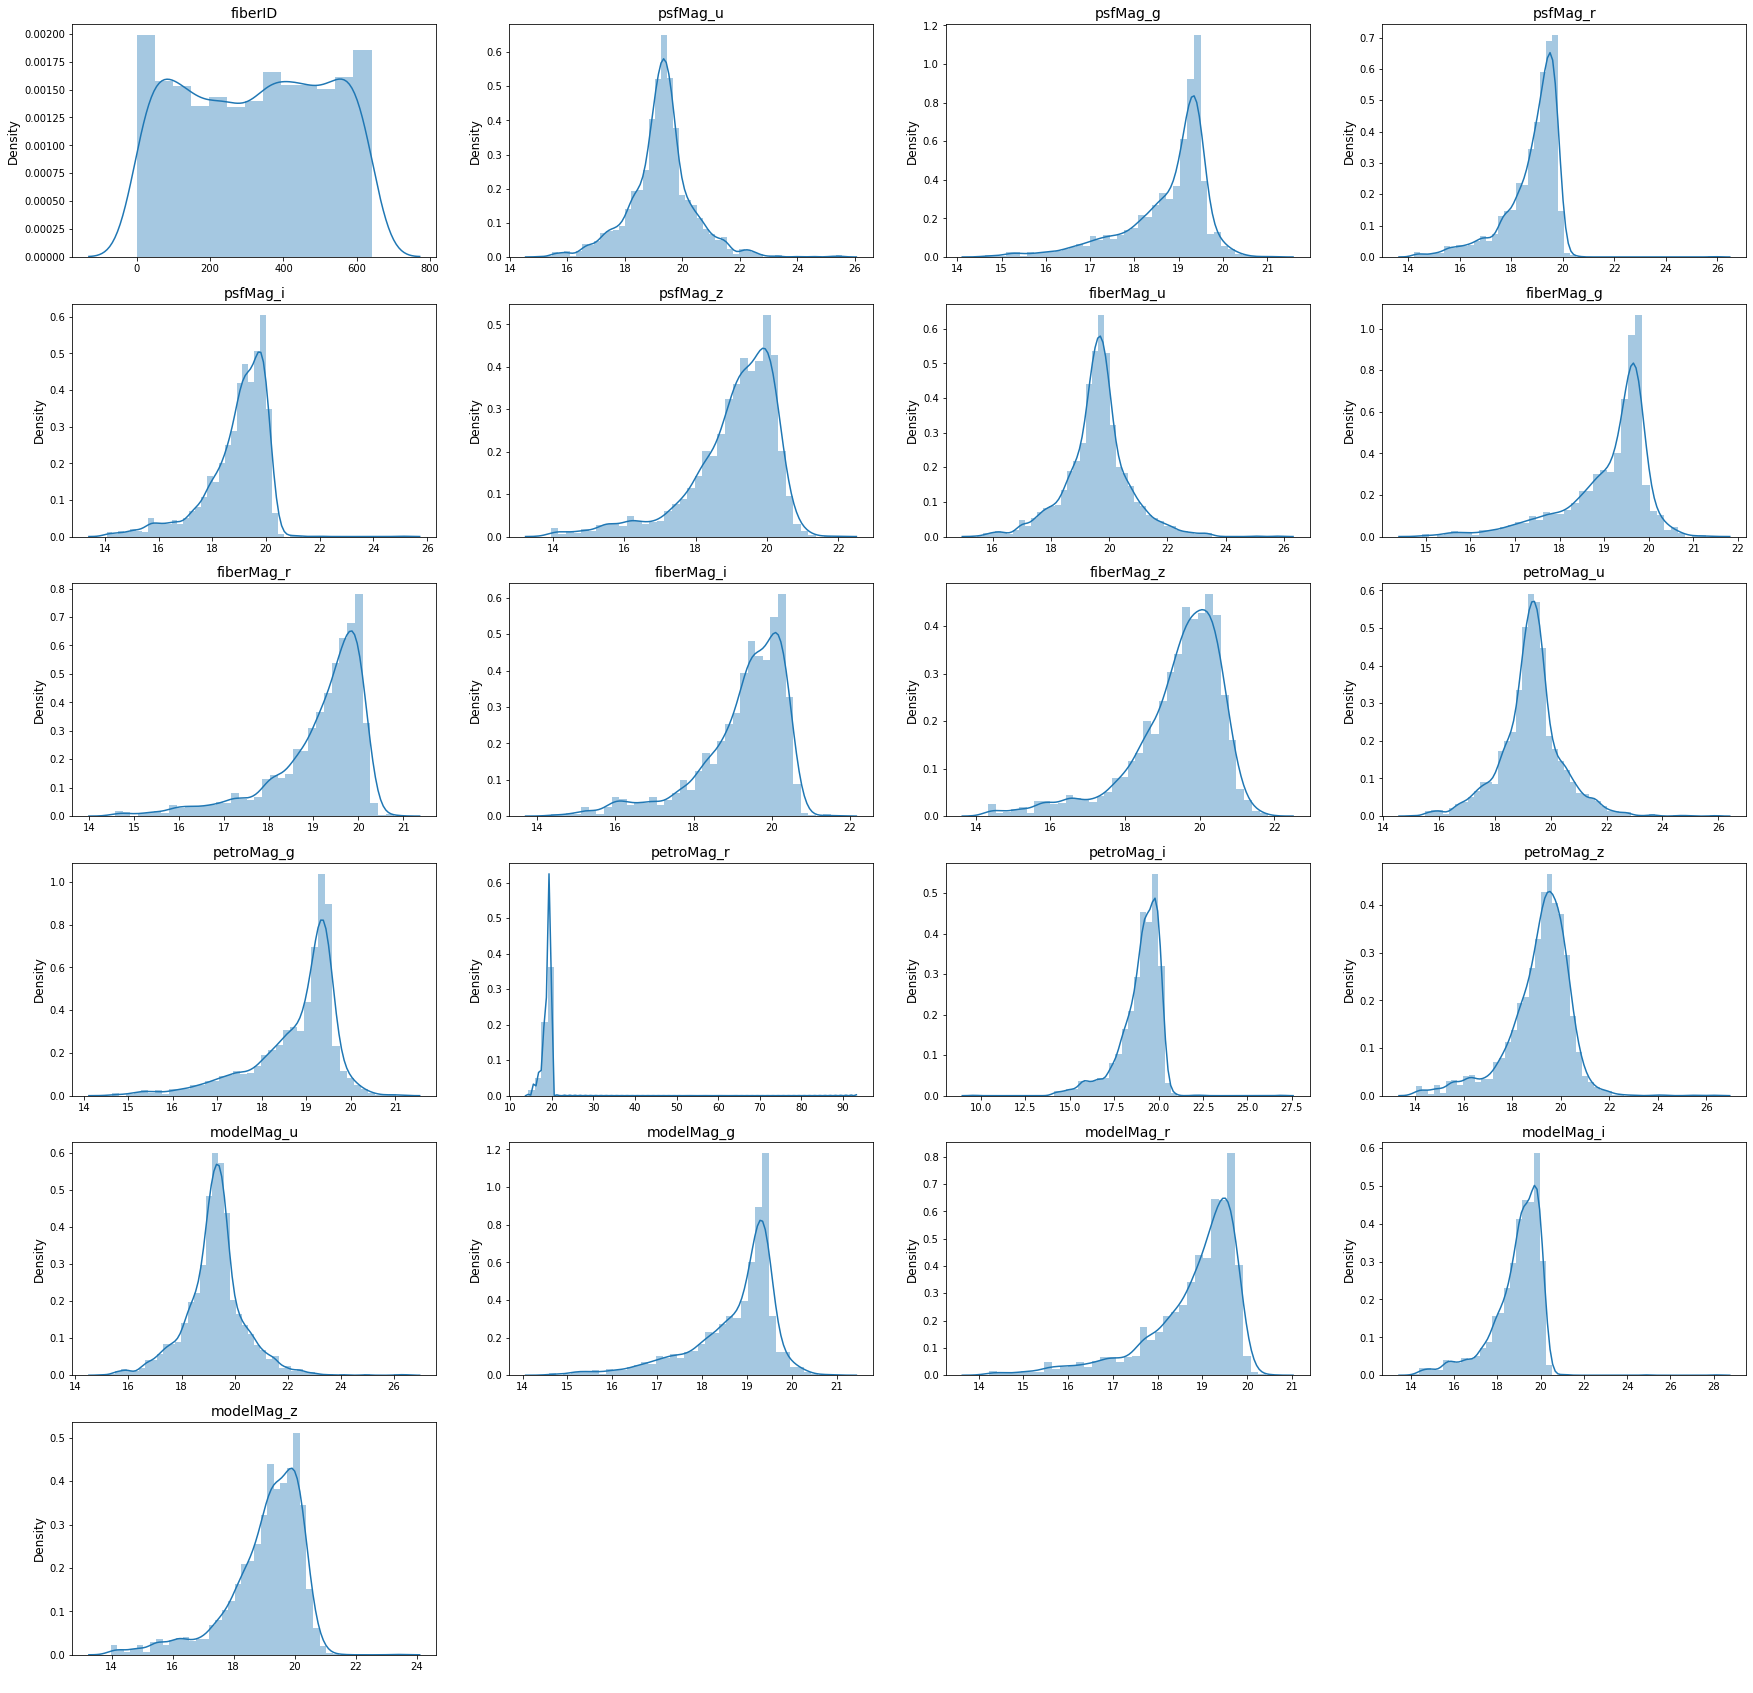

In [31]:
VisFeature(train_swd)

### SERENDIPITY_RED
알 수 없음. TO-DO

In [32]:
train_sr = train.loc[train['type'] == 'SERENDIPITY_RED']
print("Num of SERENDIPITY_RED Observation : {}".format(train_sr.shape[0]))
print("Pct of SERENDIPITY_RED Observation : {}%".format(round(train_sr.shape[0] / train.shape[0] * 100,2)))

Num of SERENDIPITY_RED Observation : 2562
Pct of SERENDIPITY_RED Observation : 1.28%


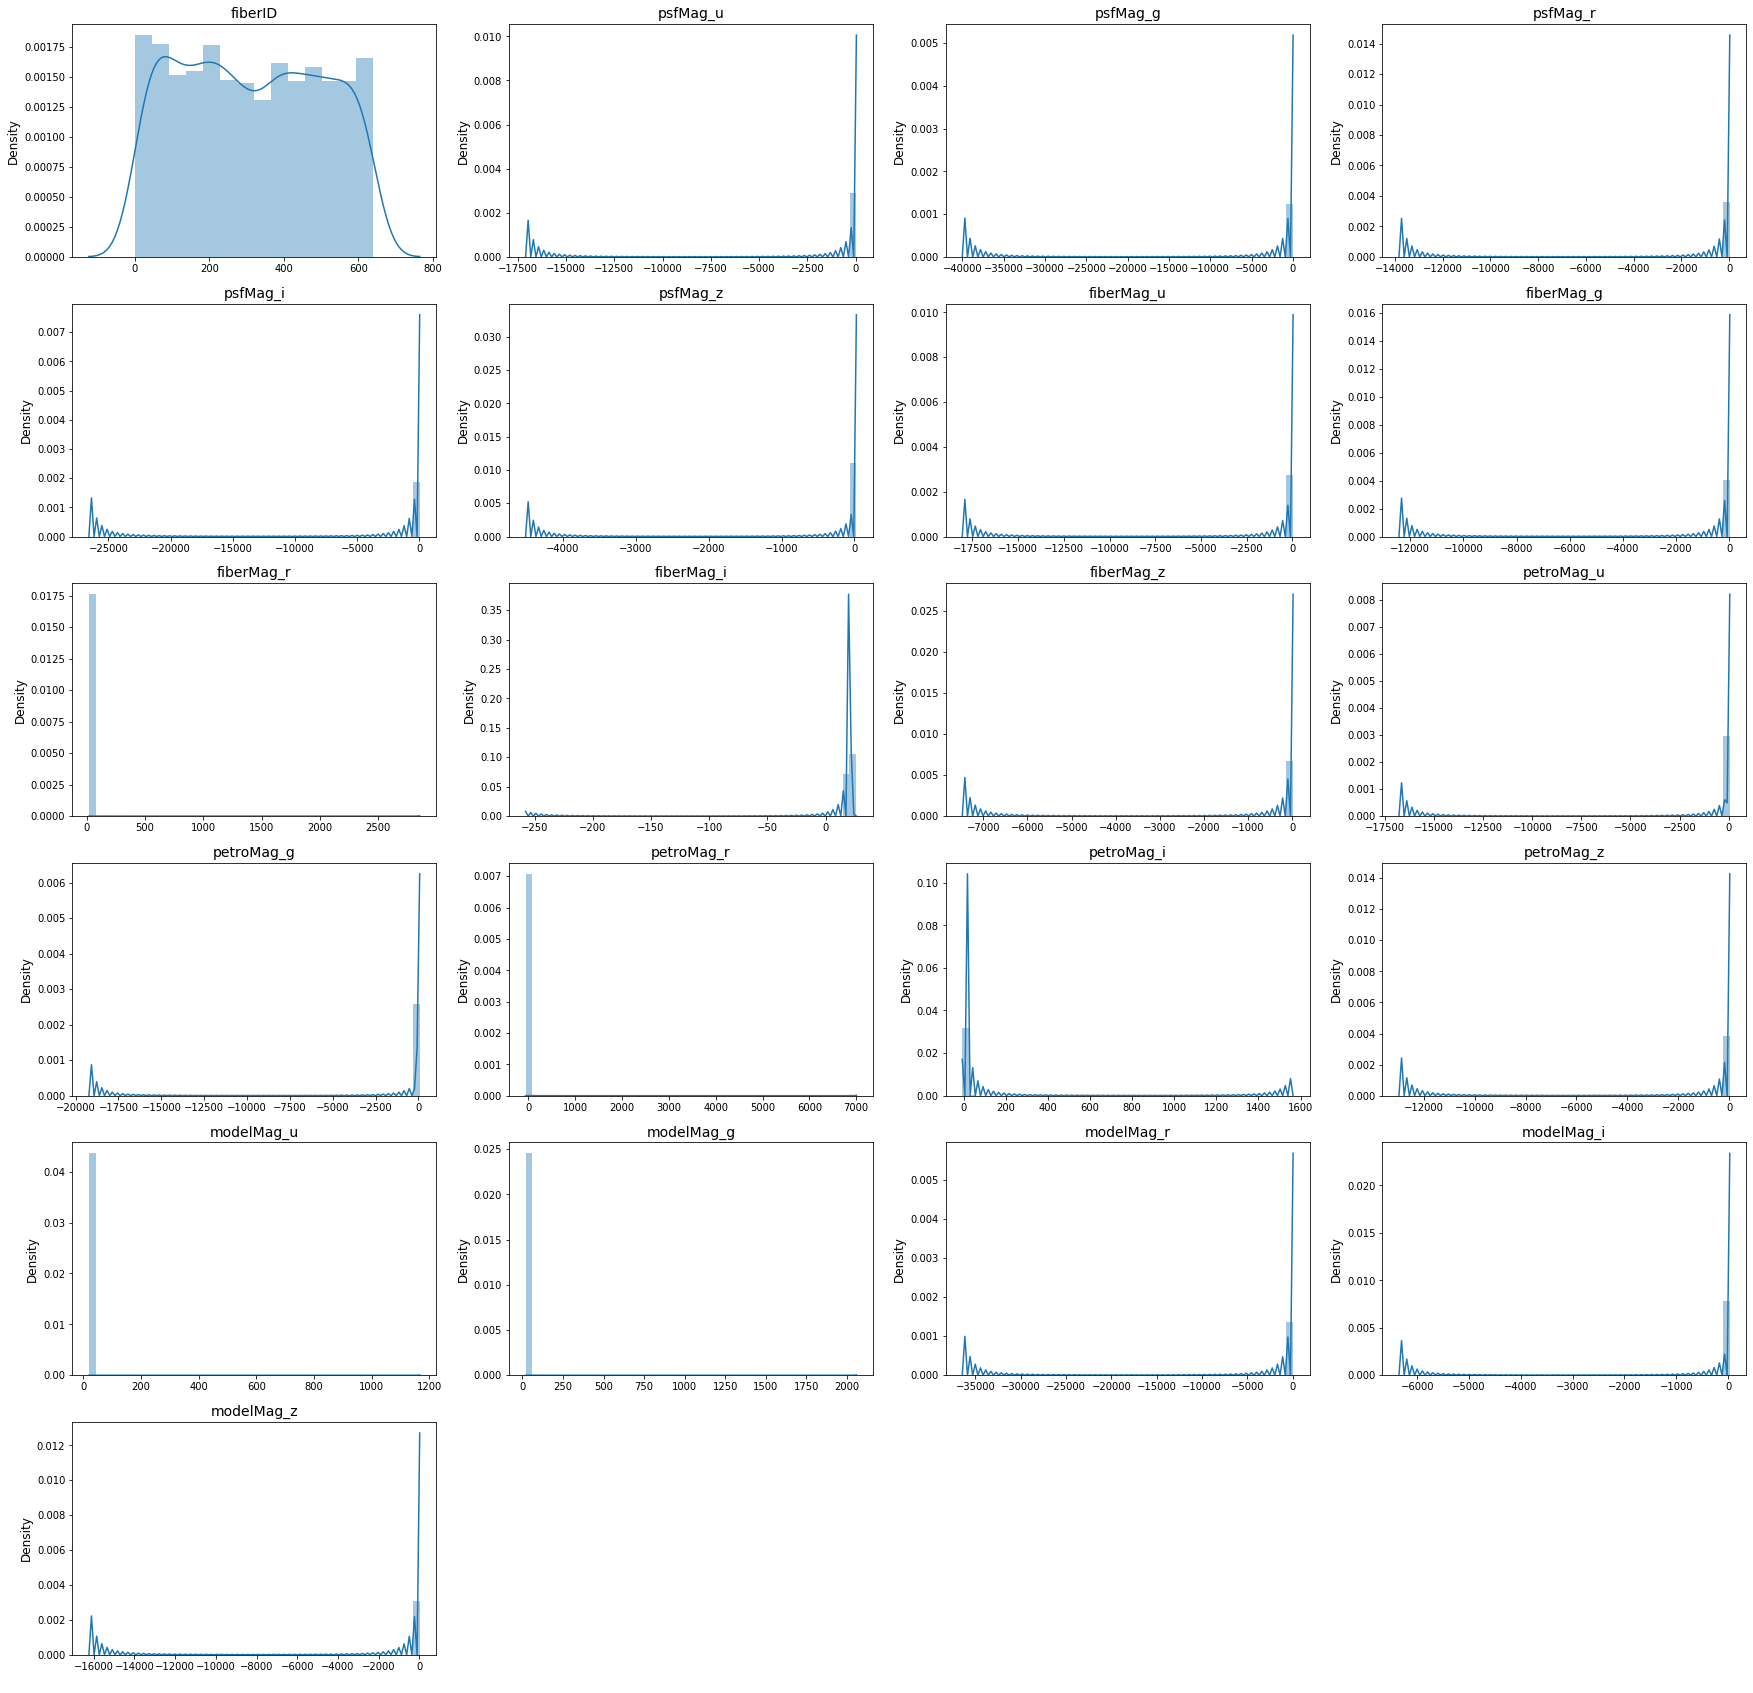

In [33]:
VisFeature(train_sr)

### STAR_CARBON

<img src=https://www.universetoday.com/wp-content/uploads/2009/02/ttcyg.jpg width="350">

대기에 산소보다 탄소를 더 많이 가지고 있는 별이다. 대표적인 예로 사냥개자리 Y가 존재한다.

In [34]:
train_sc = train.loc[train['type'] == 'STAR_CARBON']
print("Num of Star Carbon Observation : {}".format(train_sc.shape[0]))
print("Pct of Star Carbon Observation : {}%".format(round(train_sc.shape[0] / train.shape[0] * 100,2)))

Num of Star Carbon Observation : 3257
Pct of Star Carbon Observation : 1.63%


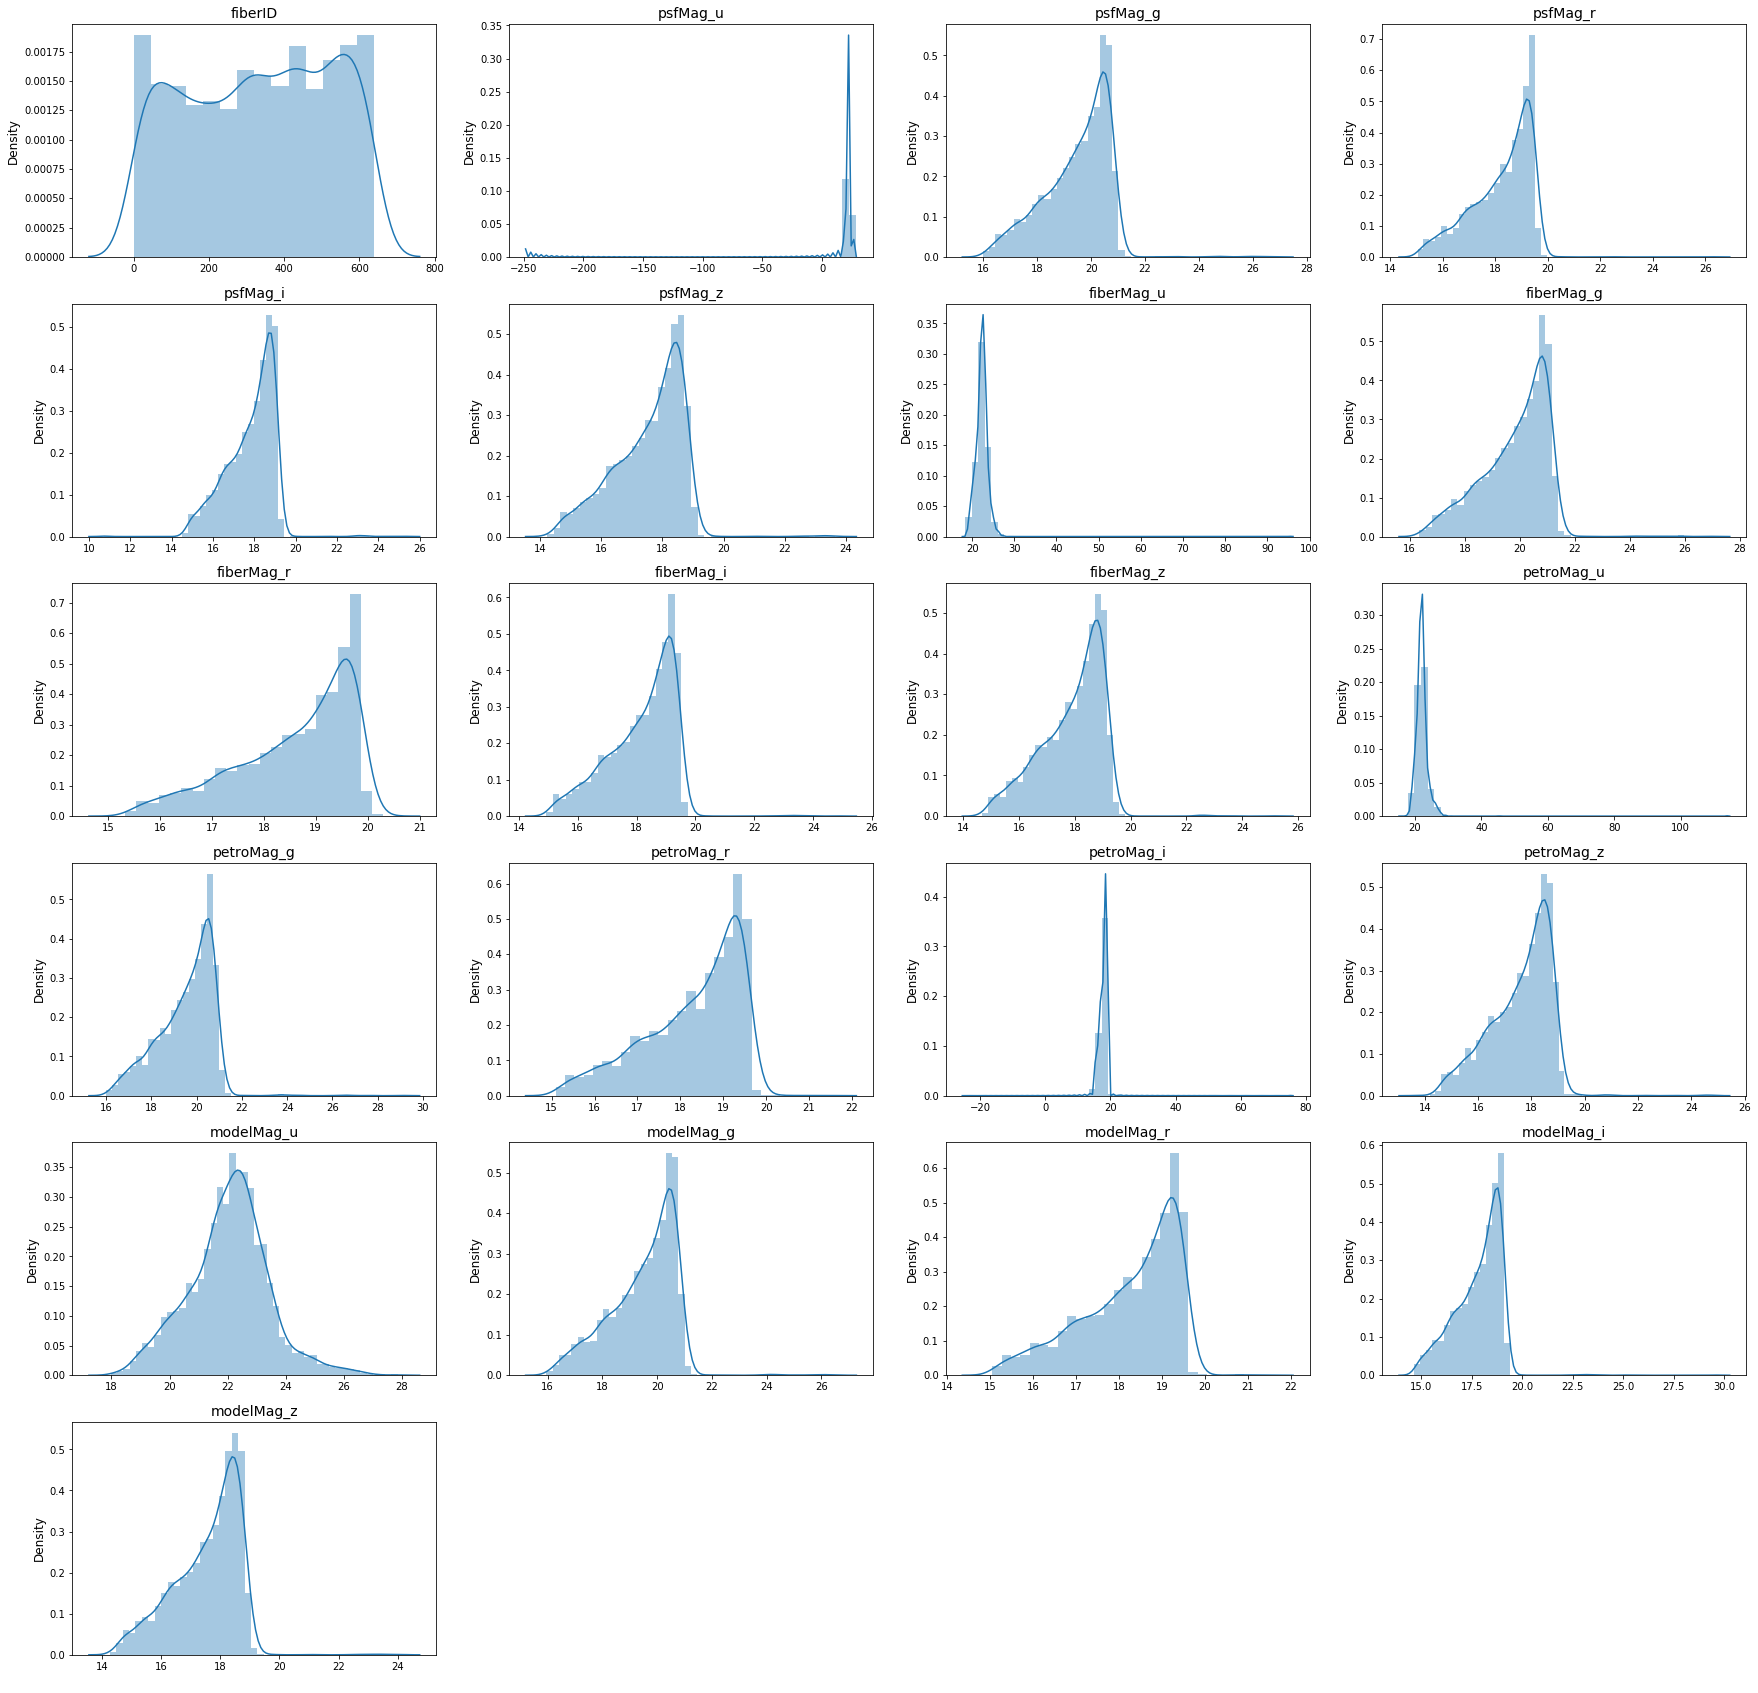

In [35]:
VisFeature(train_sc)

### SERENDIPITY_FIRST
알 수 없음. TO-DO

In [36]:
train_sf = train.loc[train['type'] == 'SERENDIPITY_FIRST']
print("Num of SERENDIPITY FIRST Observation : {}".format(train_sf.shape[0]))
print("Pct of SERENDIPITY FIRST Observation : {}%".format(round(train_sf.shape[0] / train.shape[0] * 100,2)))

Num of SERENDIPITY FIRST Observation : 7132
Pct of SERENDIPITY FIRST Observation : 3.57%


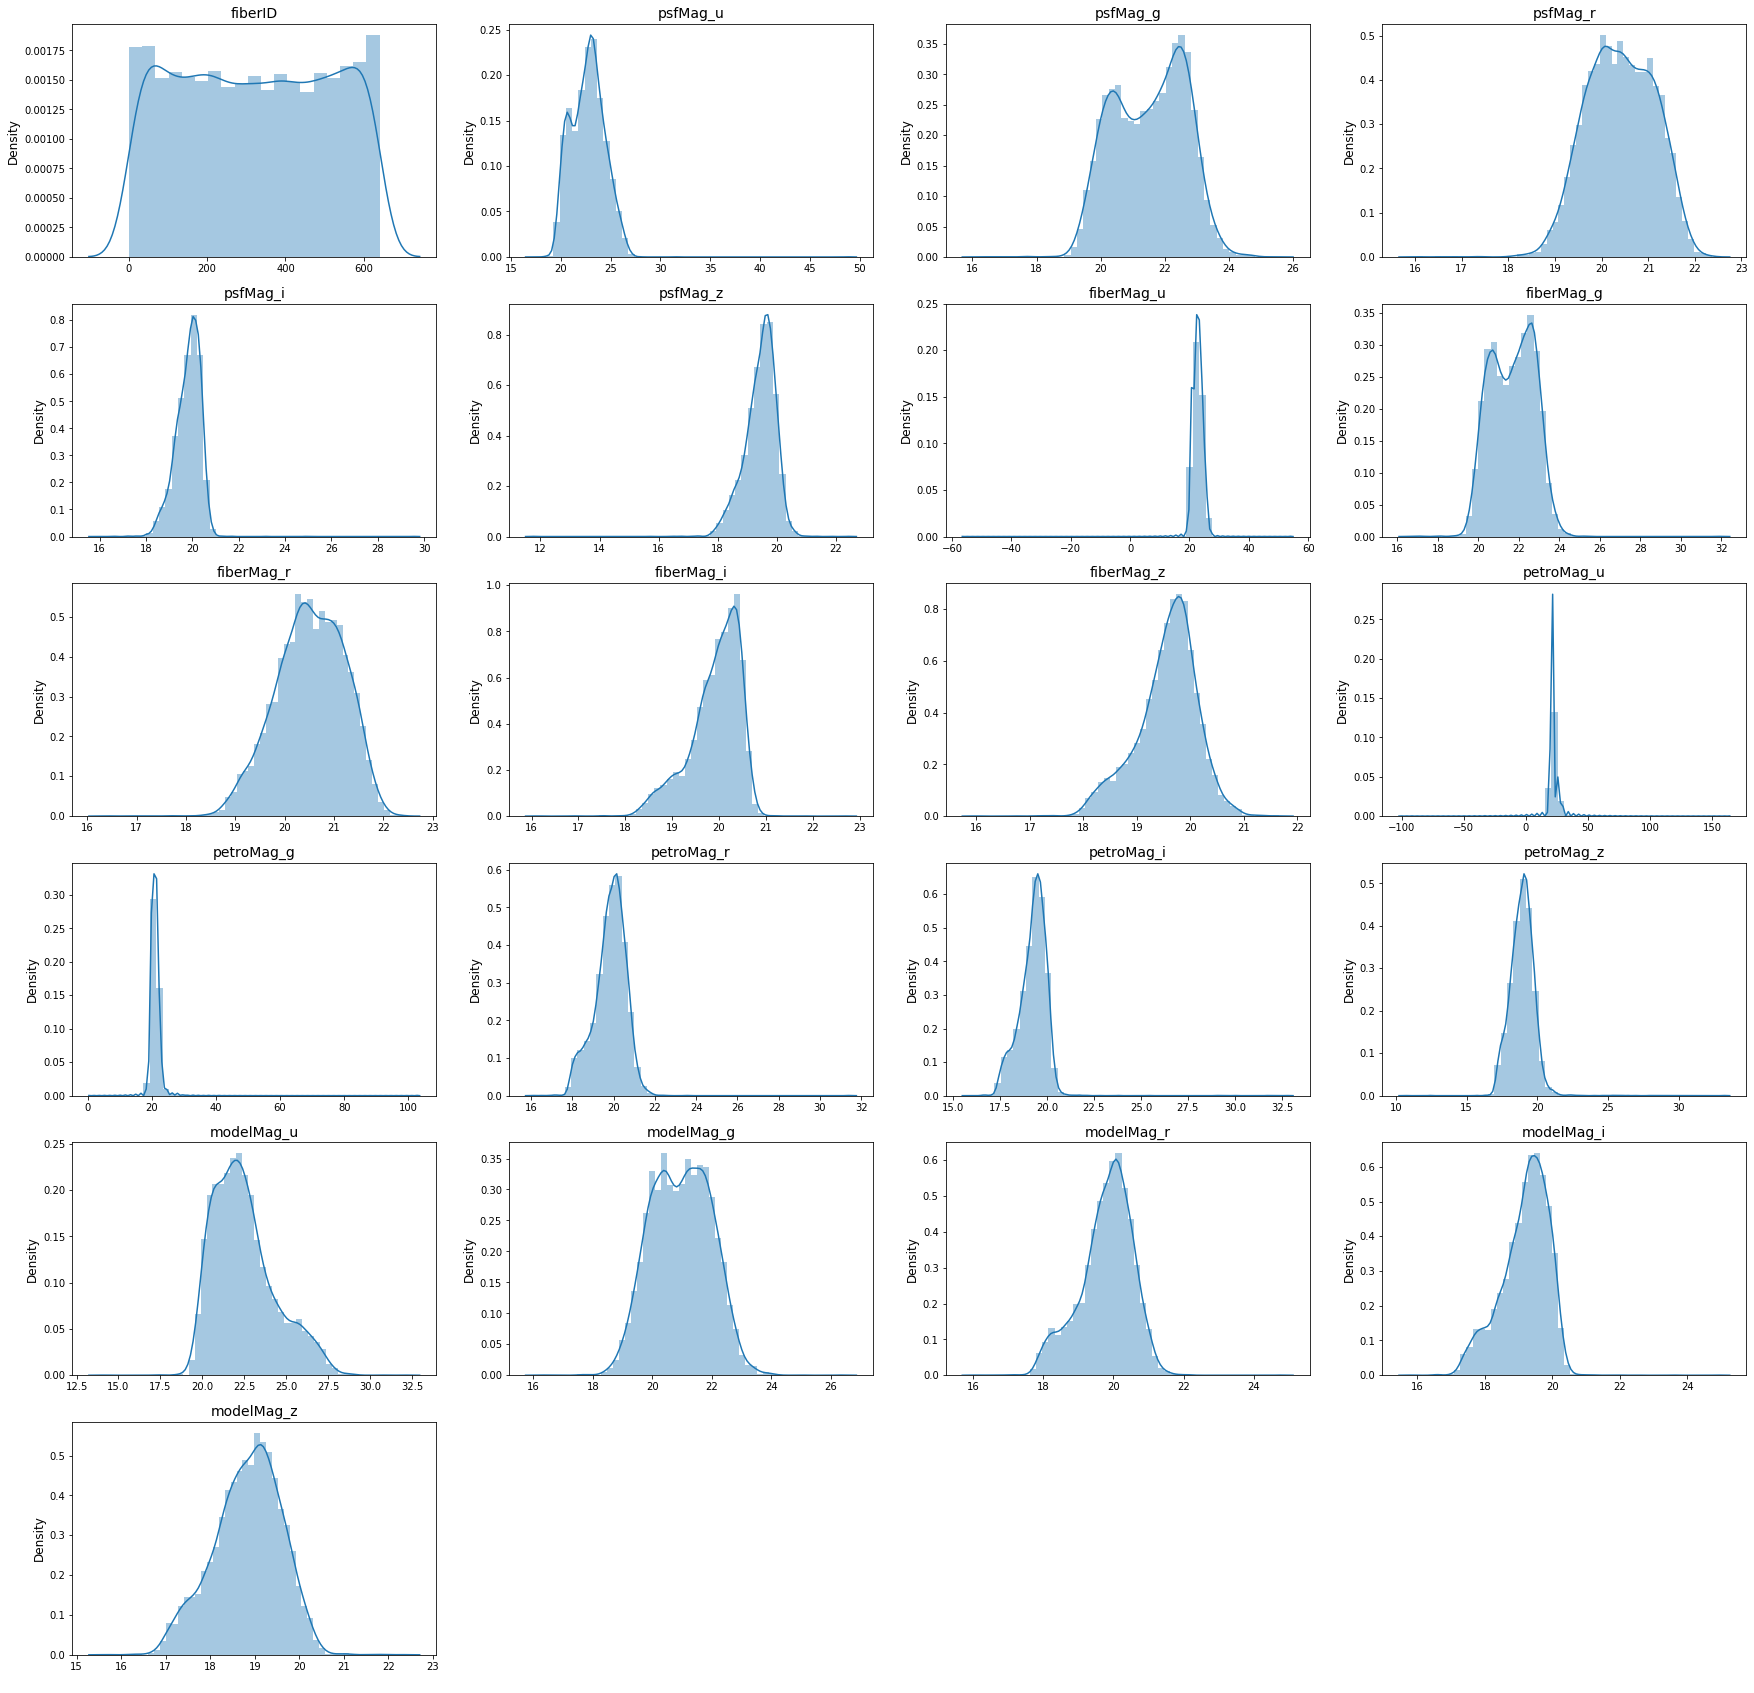

In [37]:
VisFeature(train_sf)

### STAR_BROWN_DWARF
<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Artist%E2%80%99s_conception_of_a_brown_dwarf_like_2MASSJ22282889-431026.jpg/413px-Artist%E2%80%99s_conception_of_a_brown_dwarf_like_2MASSJ22282889-431026.jpg>

'갈색왜성'으로 불리며, 제일 무거운 가스행성과 가장 가벼운 항성 사이 질량 범위에 존재하는 준항성천체이다. 

내부가 화학적으로 분화되거나 여러 층을 이루지 앟고, 전부 대류층으로 되어있을 것이라 추측된다.

질량이 작아서 중심핵에서 일반적인 헬륨으로 핵융합할 수 없다.  

분광형에 따라 색이 다르며, 육안으로 자홍색 또는 오랜지색, 빨간색으로 보인다. 그러나, 가시광선 파장대에서 밝게 보이지 않는다는 특징이 있다.

In [38]:
train_bd = train.loc[train['type'] == 'STAR_BROWN_DWARF']
print("Num of Brown Dwarf Observation : {}".format(train_bd.shape[0]))
print("Pct of Brown Dwarf FIRST Observation : {}%".format(round(train_bd.shape[0] / train.shape[0] * 100,2)))

Num of Brown Dwarf Observation : 500
Pct of Brown Dwarf FIRST Observation : 0.25%


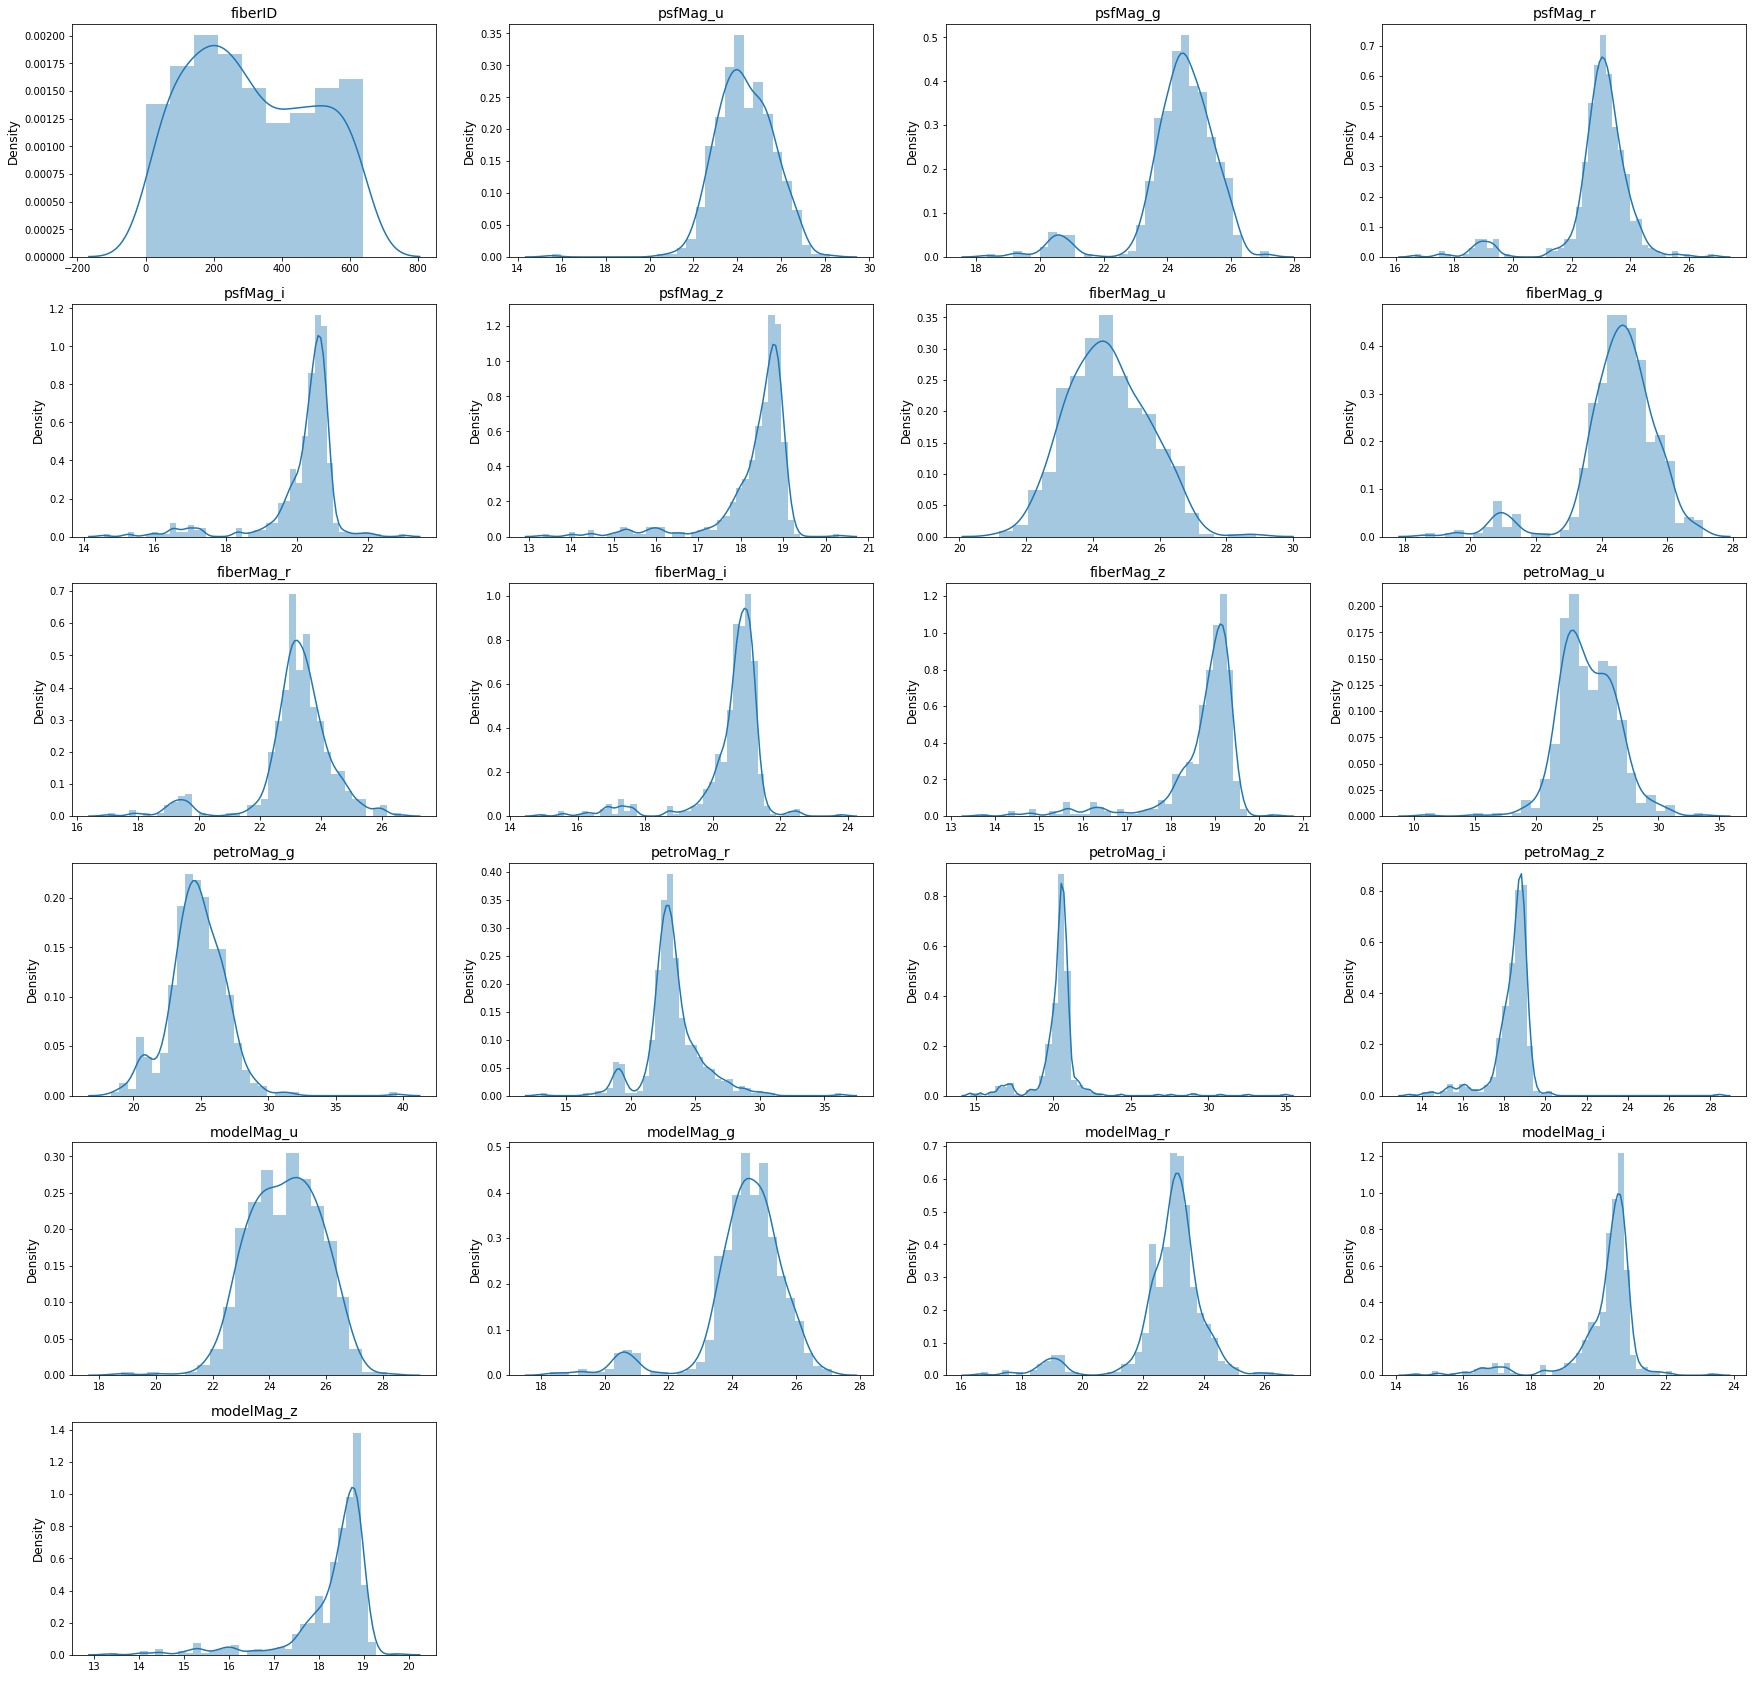

In [39]:
VisFeature(train_bd)

### STAR_SUB_DWARF

<img src=../image/image1.png width="450">

'준왜성'이라고 불리며, 같은 표면온도의 주계열성(왜성)에 비해 밝기가 1.5에서 2등급 정도 낮다는 특징을 보인다. 

In [40]:
train_ssd = train.loc[train['type'] == 'STAR_SUB_DWARF']
print("Num of Sub Dwarf Observation : {}".format(train_ssd.shape[0]))
print("Pct of Sub Dwarf FIRST Observation : {}%".format(round(train_ssd.shape[0] / train.shape[0] * 100,2)))

Num of Sub Dwarf Observation : 1154
Pct of Sub Dwarf FIRST Observation : 0.58%


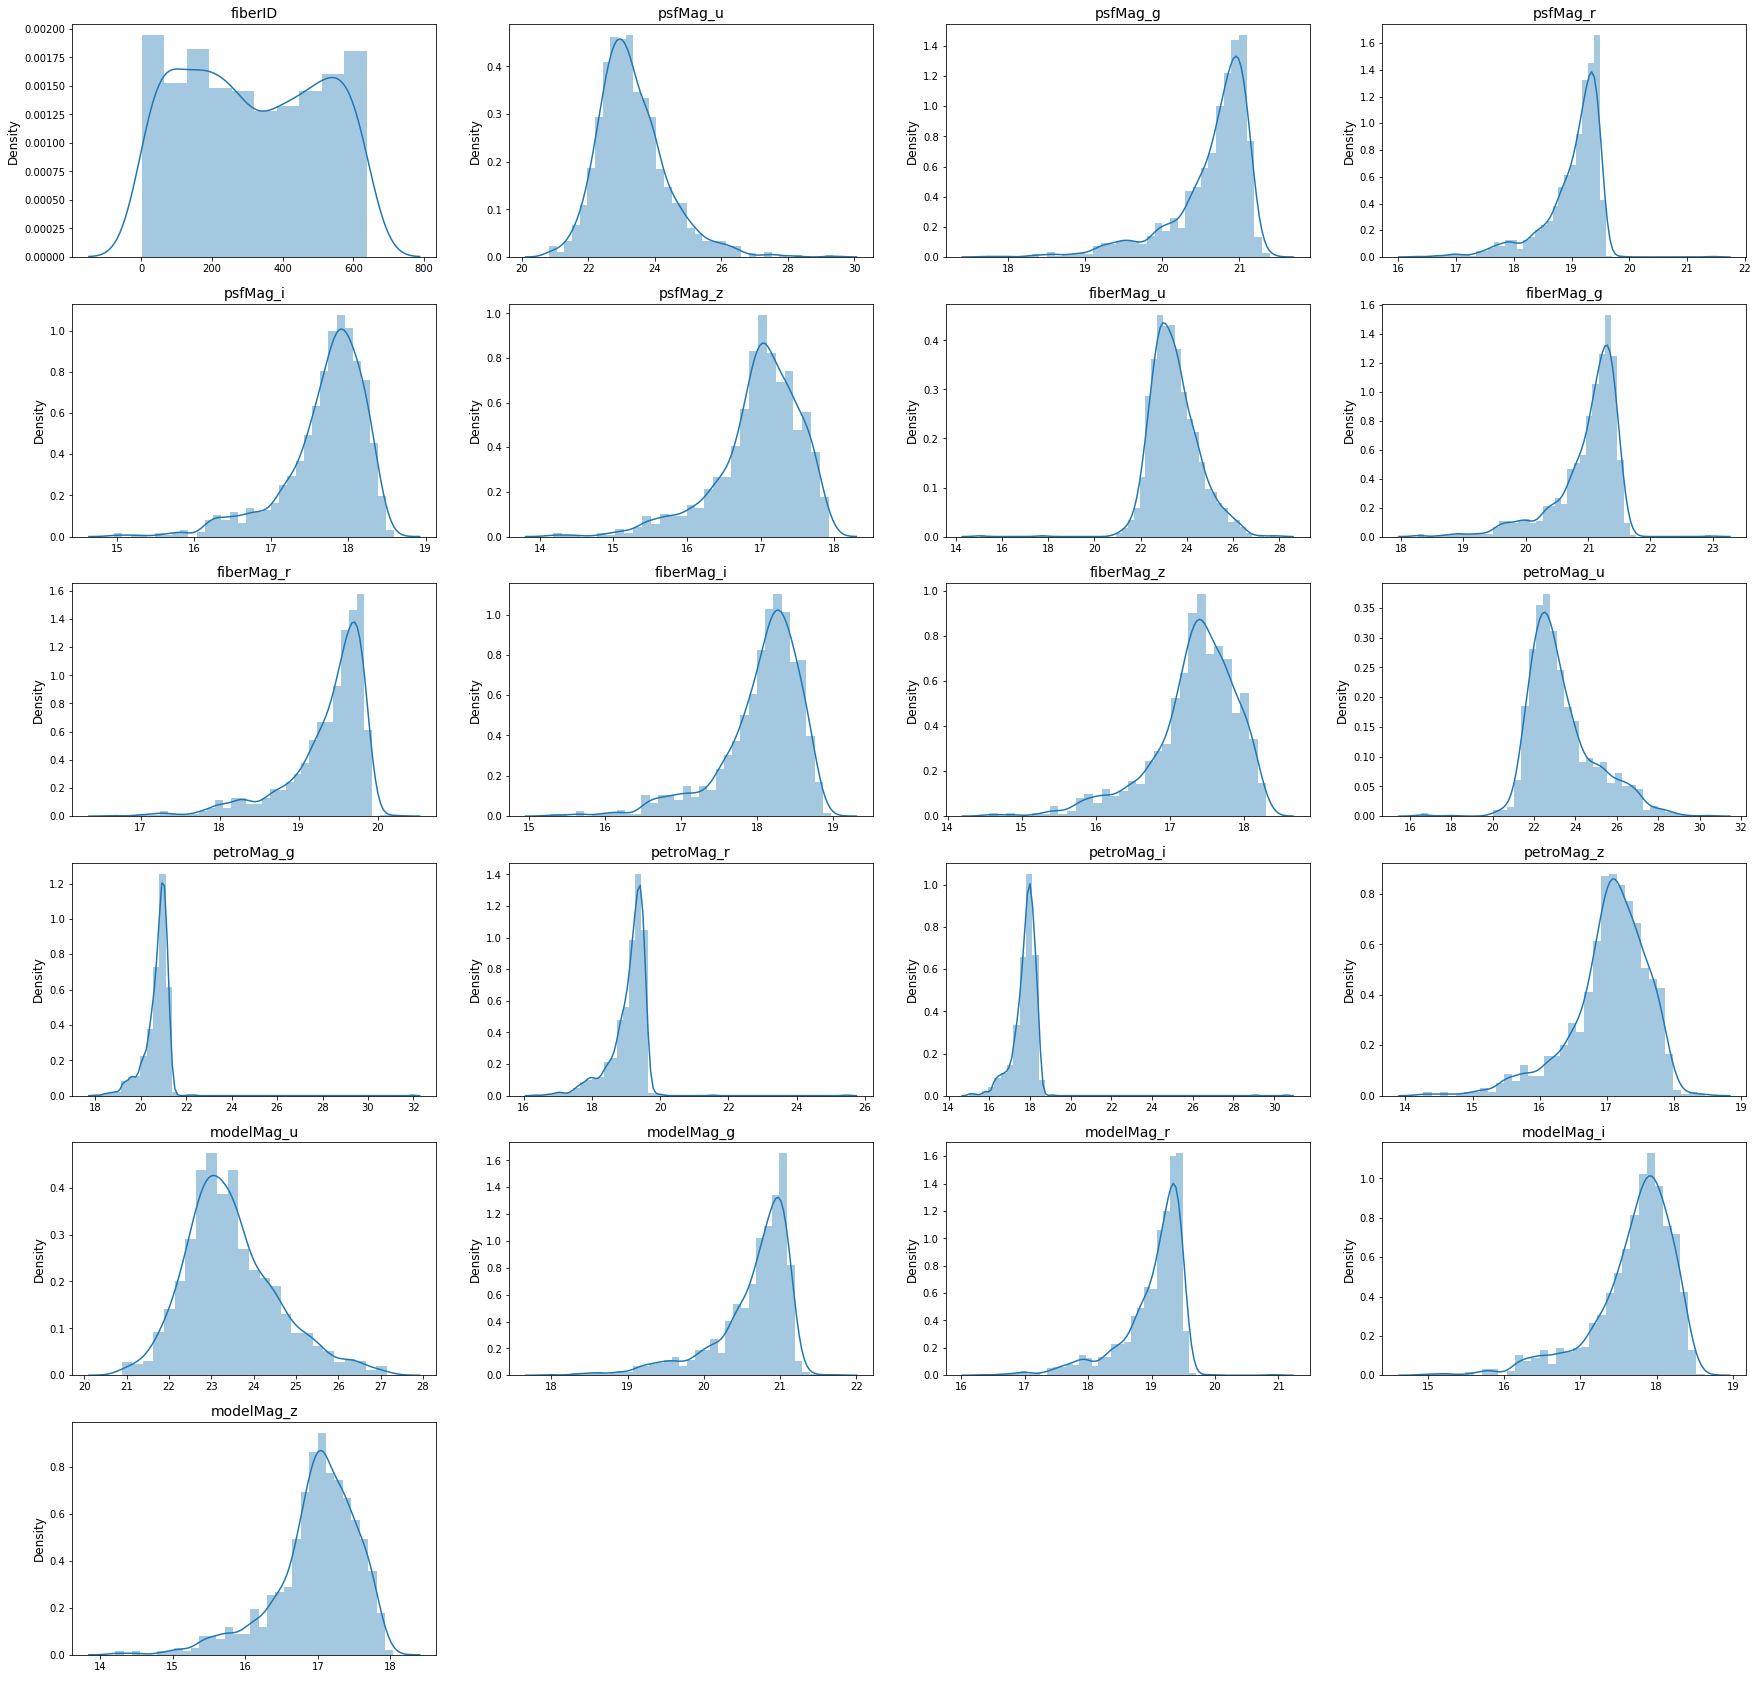

In [41]:
VisFeature(train_ssd)

### SKY

In [42]:
train_sky = train.loc[train['type'] == 'SKY']
print("Num of Sky Observation : {}".format(train_sky.shape[0]))
print("Pct of Sky FIRST Observation : {}%".format(round(train_sky.shape[0] / train.shape[0] * 100,2)))

Num of Sky Observation : 127
Pct of Sky FIRST Observation : 0.06%


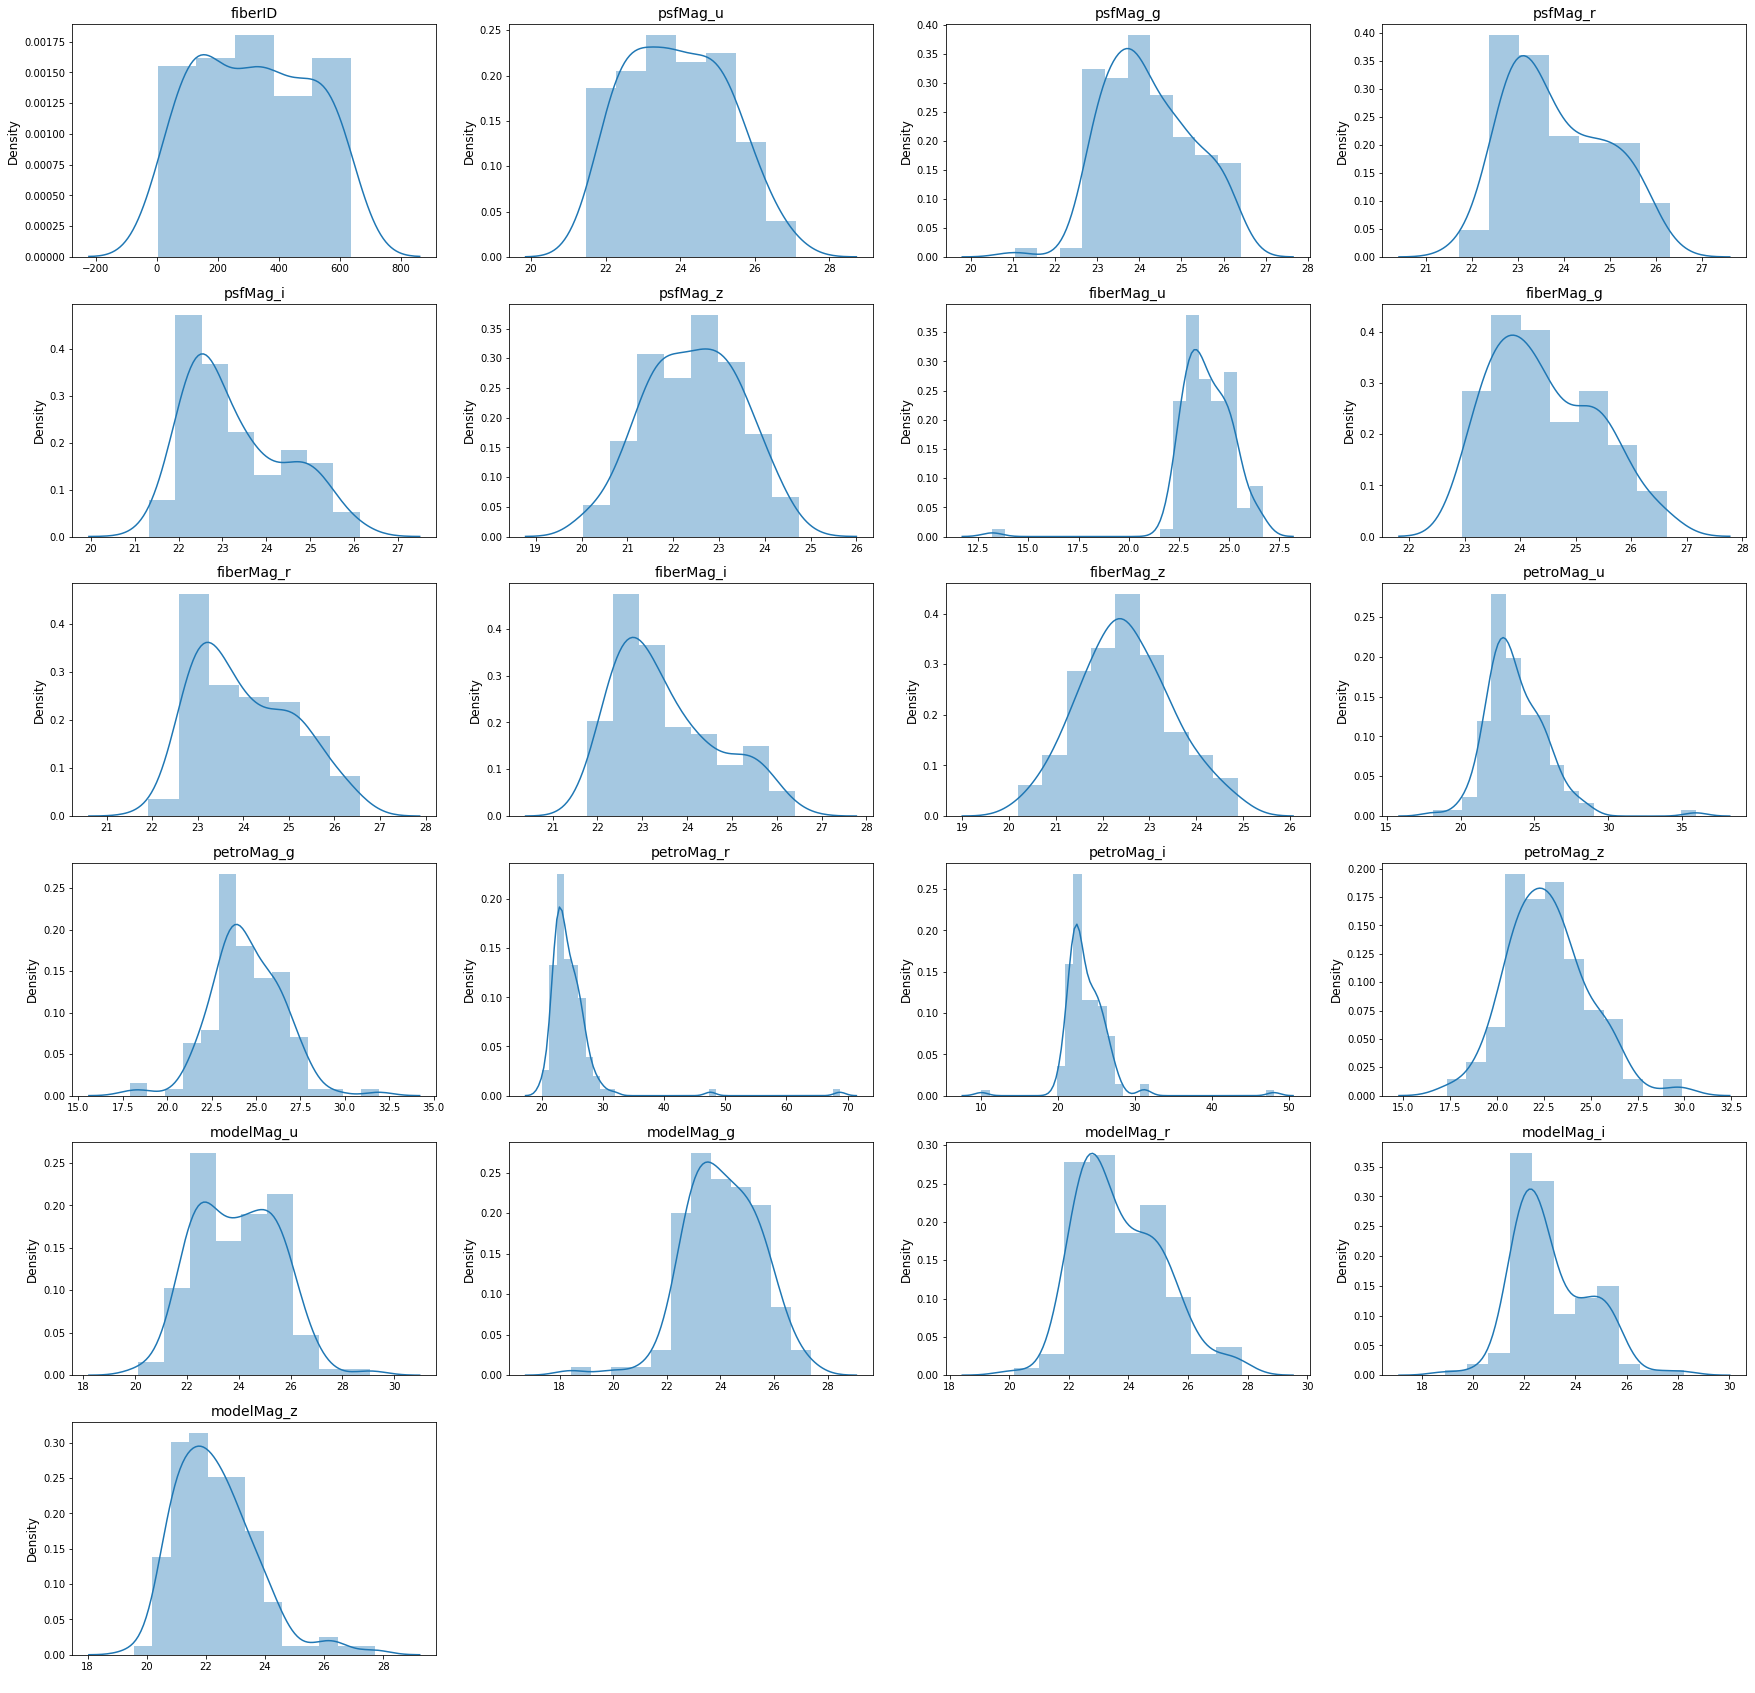

In [43]:
VisFeature(train_sky)

### SERENDIPITY_MANUAL
알 수 없음. TO-DO

In [44]:
train_sm = train.loc[train['type'] == 'SERENDIPITY_MANUAL']
print("Num of SERENDIPITY_MANUAL Observation : {}".format(train_sm.shape[0]))
print("Pct of SERENDIPITY_MANUAL Observation : {}%".format(round(train_sm.shape[0] / train.shape[0] * 100,2)))

Num of SERENDIPITY_MANUAL Observation : 61
Pct of SERENDIPITY_MANUAL Observation : 0.03%


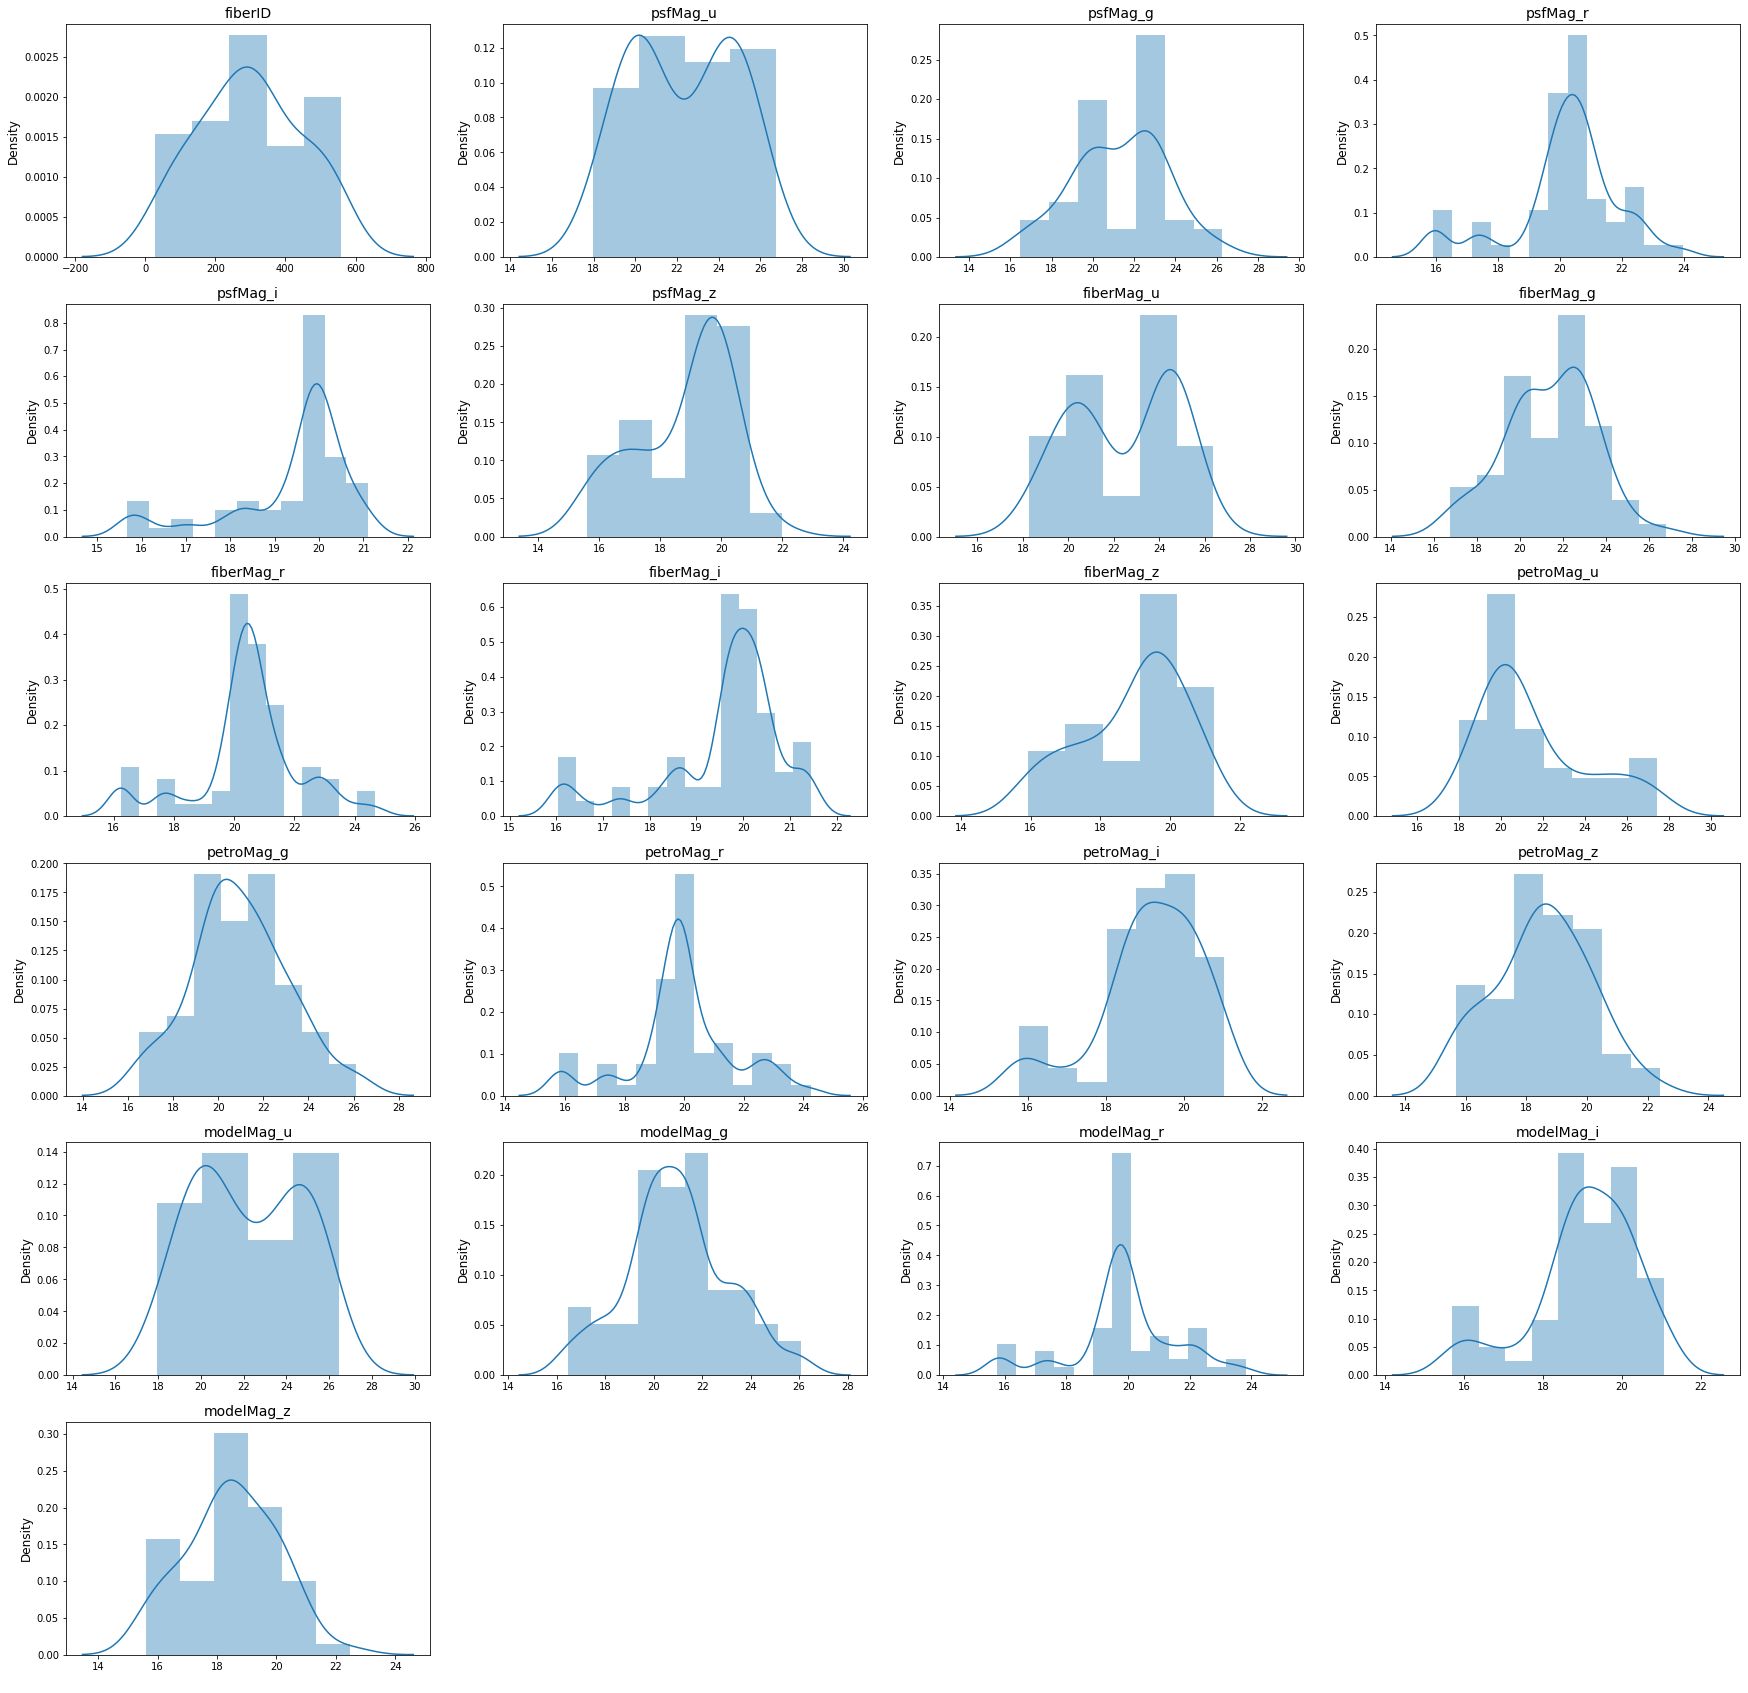

In [45]:
VisFeature(train_sm)

### STAR_PN
알 수 없음. TO-DO

In [46]:
train_sp = train.loc[train['type'] == 'STAR_PN']
print("Num of STAR_PN Observation : {}".format(train_sp.shape[0]))
print("Pct of STAR_PN Observation : {}%".format(round(train_sp.shape[0] / train.shape[0] * 100,2)))

Num of STAR_PN Observation : 13
Pct of STAR_PN Observation : 0.01%


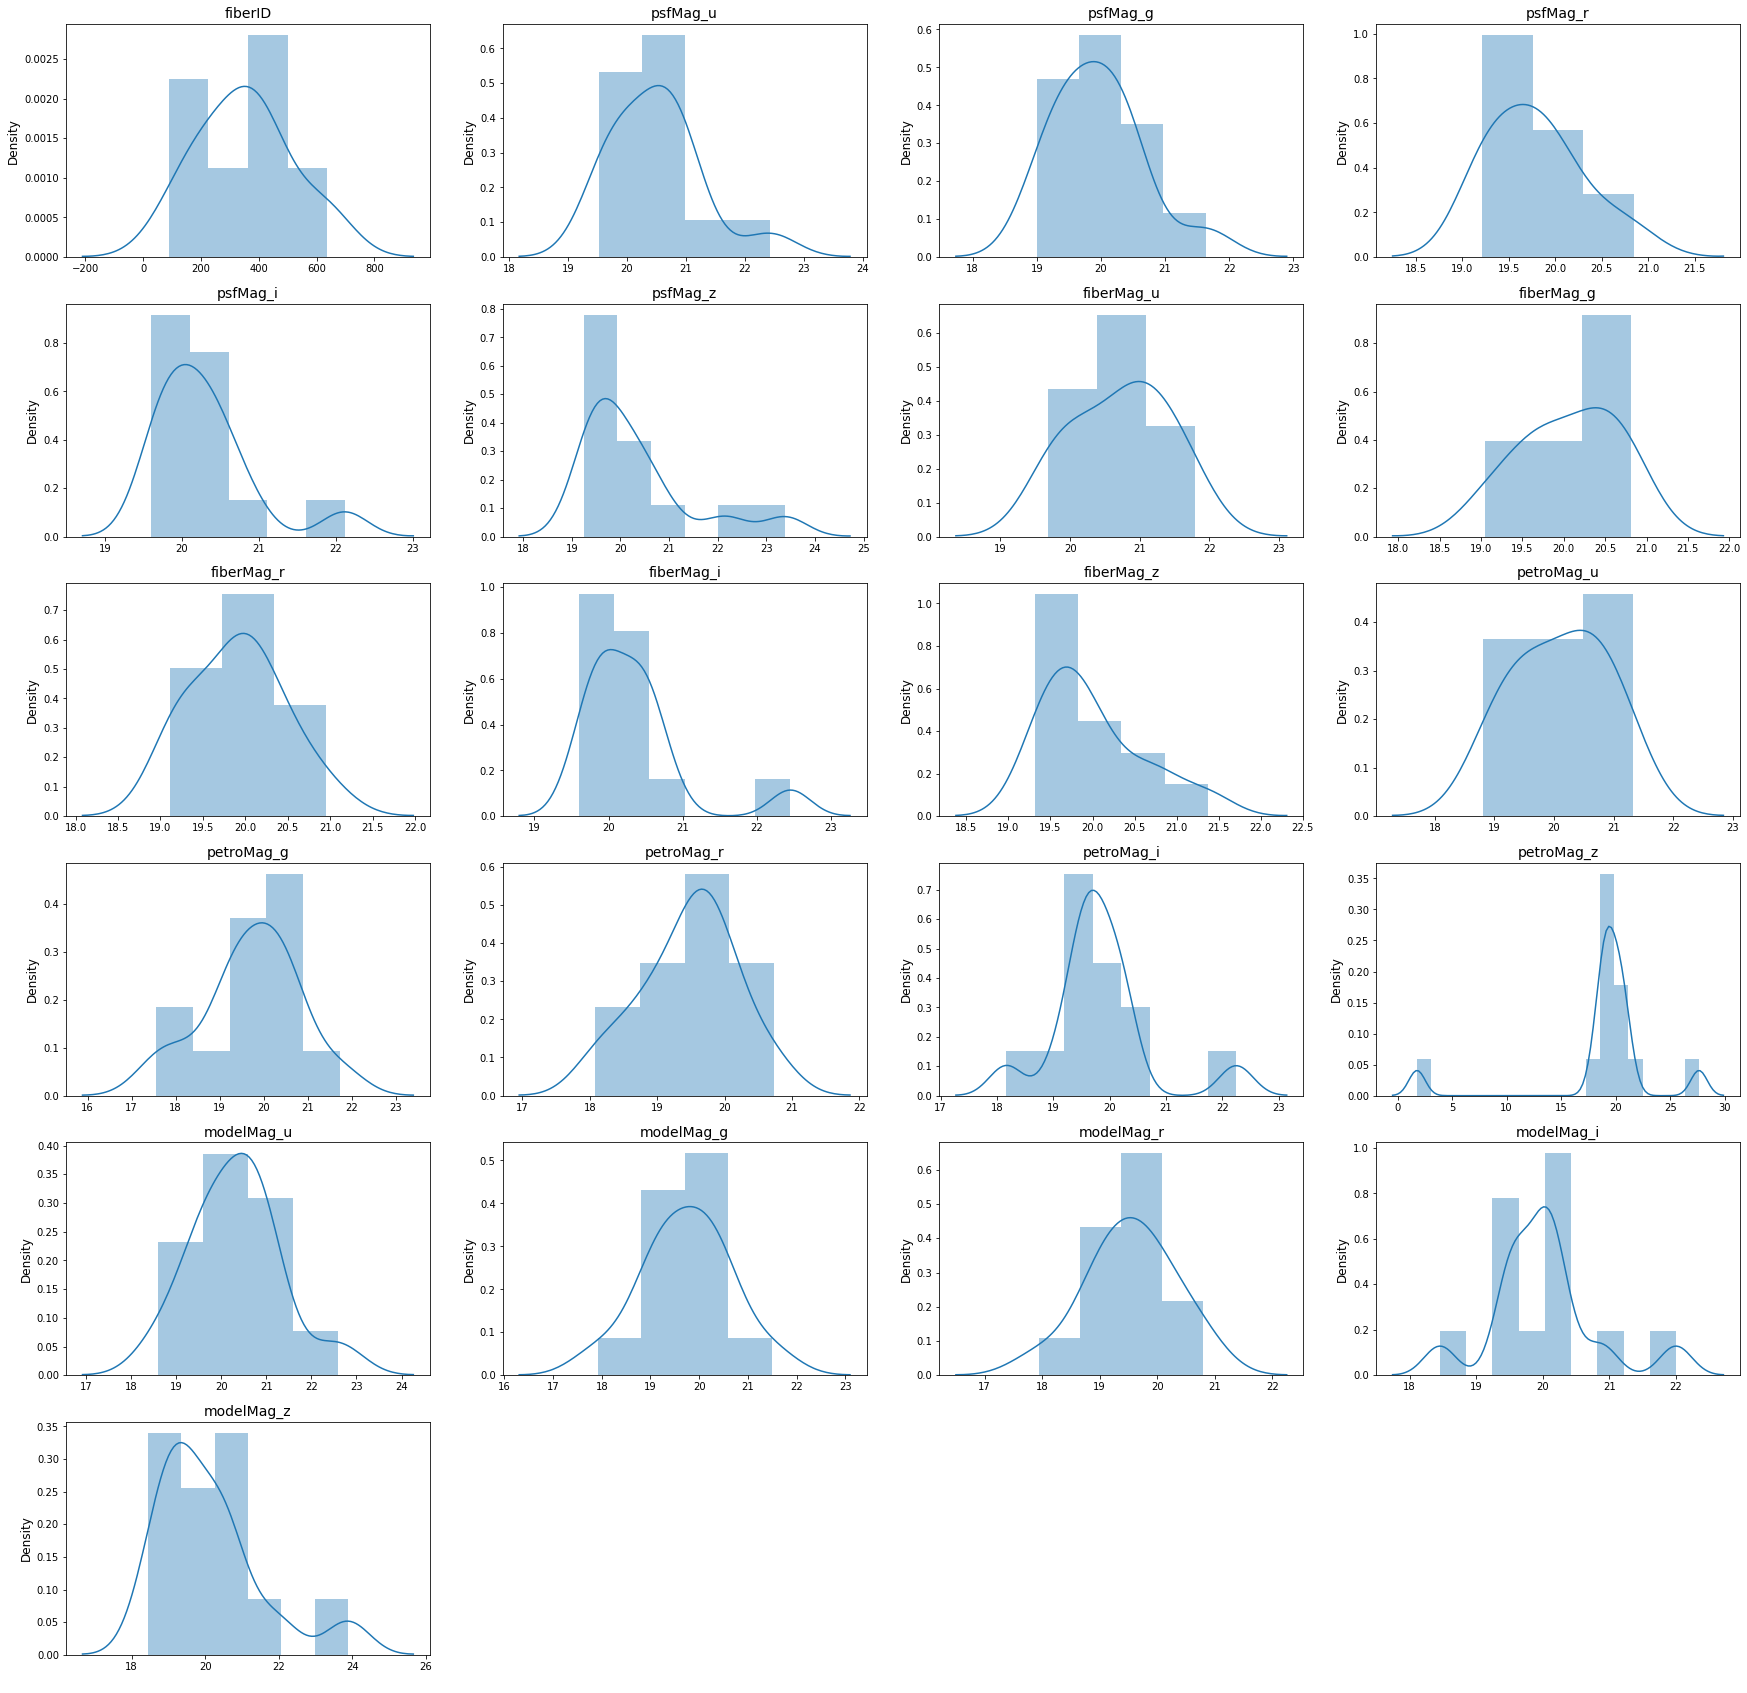

In [47]:
VisFeature(train_sp)

# fiberID

In [48]:
print("Num of Unique Fiber ID:",train['fiberID'].nunique())

Num of Unique Fiber ID: 1000


In [49]:
def FiberGrouping(x):
    if x < 100:
        return 0
    
    elif (x >= 100) & (x < 200):
        return 100
    
    elif (x >= 200) & (x < 300):
        return 200
    
    elif (x >= 300) & (x < 400):
        return 300
    
    elif (x >= 400) & (x < 500):
        return 400
    
    elif (x >= 500) & (x < 600):
        return 500
    
    elif (x >= 600) & (x < 700):
        return 600
    
    elif (x >= 700) & (x < 800):
        return 700
    
    elif (x >= 800) & (x < 900):
        return 800
    
    else:
        return 900

In [50]:
train['fiberID_group'] = train['fiberID'].apply(FiberGrouping)

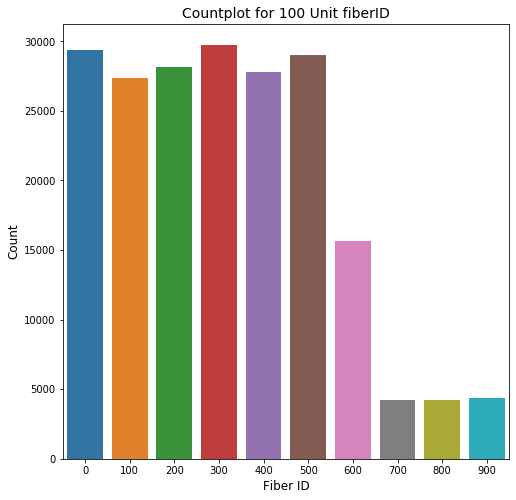

In [51]:
plt.figure(figsize = (8,8))

sns.countplot(train['fiberID_group'])

plt.title('Countplot for 100 Unit fiberID', fontsize = 14)
plt.xlabel('Fiber ID', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

광섬유 구분자의 빈도수는 600 이상부터 절반 가까이 감소한다는 것을 알 수 있다. 또한, 700이상은 더 많이 감소한다는 것을 알 수 있다.

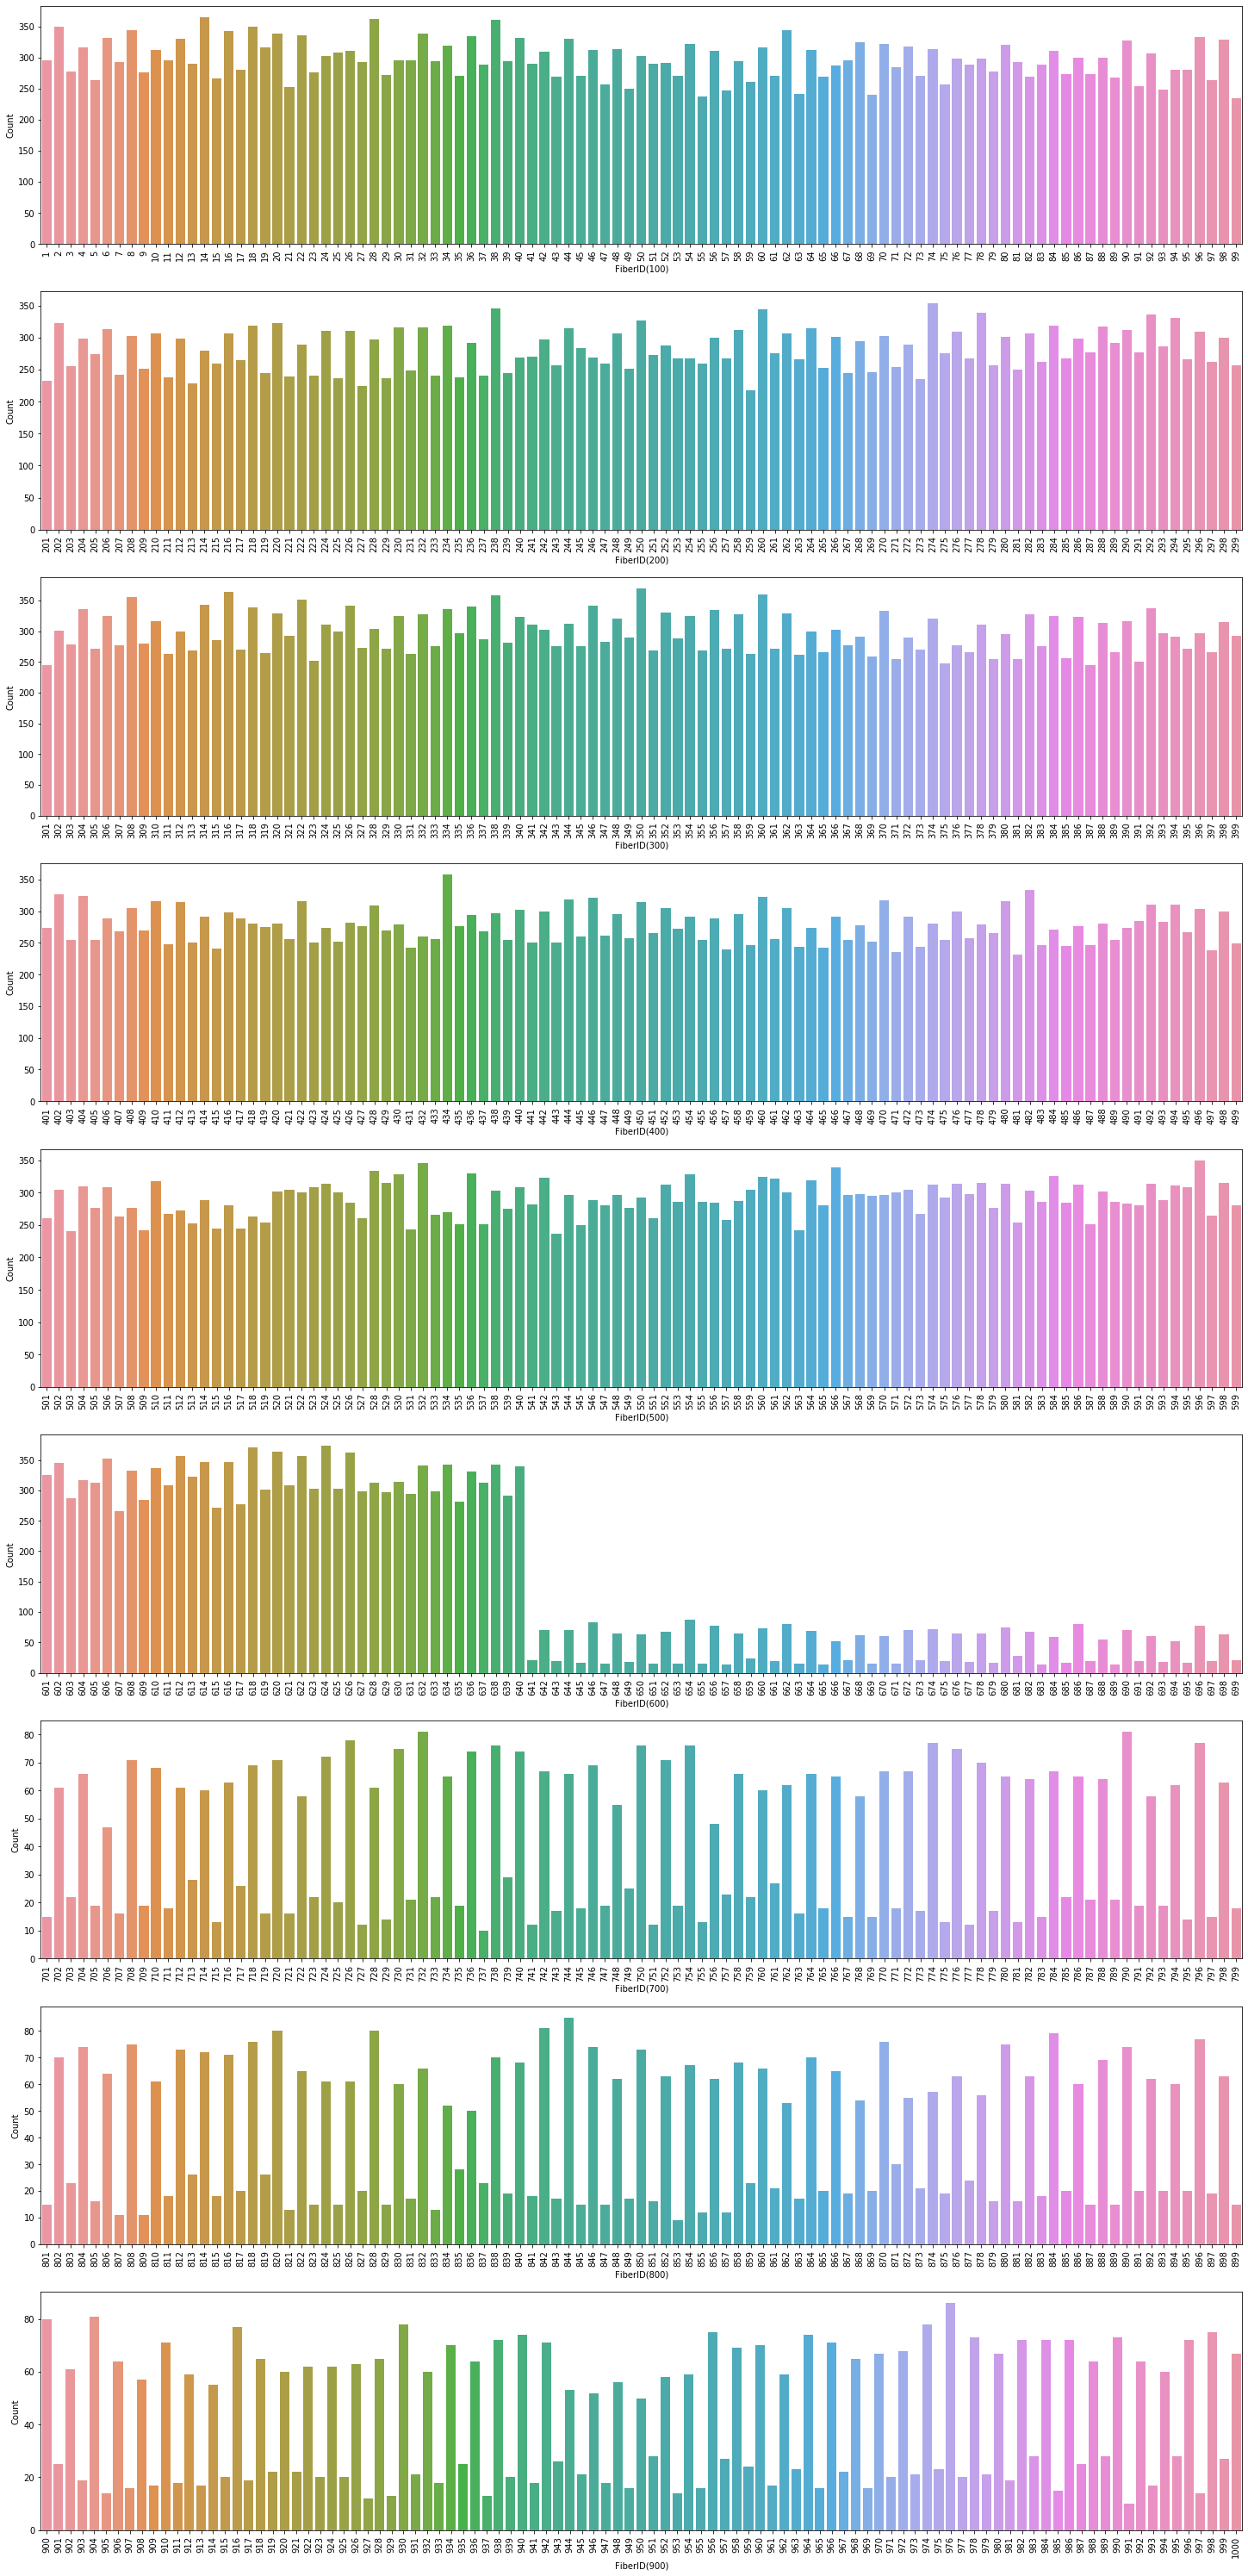

In [52]:
fiberID_unit = [x for x in range(100, 901, 100)]

f = plt.figure(figsize = (25, 60))

for i,j in enumerate(fiberID_unit):
    f.add_subplot(10, 1, i+1)
    
    if j <= 100:
        
        ax = sns.countplot(train['fiberID'].loc[train['fiberID'] < j])
    
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        ax.set_xlabel('FiberID({})'.format(j))
        ax.set_ylabel('Count')
    
    elif (j > 100) & (j < 900):
        
        ax = sns.countplot(train['fiberID'].loc[(train['fiberID'] > j) & (train['fiberID'] < j+100)])
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        ax.set_xlabel('FiberID({})'.format(j))
        ax.set_ylabel('Count')
        
    else:
        ax = sns.countplot(train['fiberID'].loc[(train['fiberID'] >= 900) & (train['fiberID'] < 1001)])
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        ax.set_xlabel('FiberID({})'.format(j))
        ax.set_ylabel('Count')

광섬유 구분자 값이 641 이상인 값은 빈도수가 급격하게 낮아진다는 것을 알 수 있다.

In [53]:
low_frq_train = train.loc[train['fiberID'] > 640]
print("Fiber ID 641 or higher celestial value:", low_frq_train['type'].unique())

Fiber ID 641 or higher celestial value: ['QSO']


실제로, 광섬유 구분자가 641 이상일 경우 천체 유형은 모두 QSO임을 알 수 있다.

## Summary Statistics by Group

광섬유 식별자별 요약통계량을 확인한다. 가정은 다음과 같다.
- 광섬유 식별자가 같고 천체 유형이 동일하다면, 피쳐들의 값이 비슷할 것이다.

In [64]:
fiberID_mean = train.groupby('fiberID').mean()
#fiberID_mean.reset_index(inplace = True)

fiberID_median = train.groupby('fiberID').median()
#fiberID_median.reset_index(inplace = True)

fiberID_std = train.groupby('fiberID').std()
#fiberID_std.reset_index(inplace = True)

In [108]:
def VisFeature(data, method = 'hist', sep = False, scale = None):
    
    
    if method == 'hist':
        data = data.drop(columns = 'fiberID_group')

        f = plt.figure(figsize = (30,30))
        
        for i, col in enumerate(data.columns):
            f.add_subplot(6,4,i+1)
            sns.distplot(data[col])
            plt.title(col, fontsize = 14)
            plt.xlabel(' ')
            plt.ylabel('Density', fontsize = 12)
    
    if method == 'line':
        if sep == False:
            
            data = data.drop(columns = 'fiberID_group')
        
            f = plt.figure(figsize = (30, 30))
        
            for i, col in enumerate(data.columns):
                f.add_subplot(6, 4, i+1)
                plt.plot(data[col])
                plt.title(col, fontsize = 14)
                plt.xlabel('fiberID Index', fontsize = 12)
                plt.ylabel('Value', fontsize = 12)
                
        elif sep == True:
            
            data = data.drop(columns = 'fiberID_group')

            f = plt.figure(figsize = (30,30))
            
            for i, col in enumerate(data):
                f.add_subplot(6, 4, i+1)
                plt.plot(data.iloc[:640][col])
                plt.plot(data.iloc[640:][col])
                plt.title(col, fontsize = 14)
                plt.xlabel('fiberID Index', fontsize = 12)
                plt.ylabel('Value', fontsize = 12)

### Mean

In [74]:
fiberID_mean.describe()

psfMag_u     psfMag_g     psfMag_r     psfMag_i     psfMag_z  \
count   1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean       1.435419    19.420412    19.153648    18.842675    18.501490   
std      600.394295     7.566346     6.343309     5.941323     6.645032   
min   -18963.759559  -113.900339   -78.315962   -69.867424   -80.171973   
25%       20.850155    19.699578    19.088337    18.619894    18.329645   
50%       21.053992    19.889578    19.303373    18.888775    18.625320   
75%       21.786111    21.024109    20.778609    20.631708    20.479587   
max       86.979260    33.558079    31.446965    38.589832    49.657051   

        fiberMag_u   fiberMag_g   fiberMag_r   fiberMag_i   fiberMag_z  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean     14.072444    19.729724    19.730912    19.012972    18.788341  ...   
std     210.154391    33.752638     4.527361     6.338479     7.725977  ...   
min   -6621.251185  -690.292344   -54.698245   -54.218727   -86.362363  ...   
25%      21.039959    19.925231    19.302022    18.818895    18.540133  ...   
50%      21.229306    20.111129    19.520077    19.092002    18.838246  ...   
75%      21.988974    21.308906    21.058167    20.894940    20.709796  ...   
max      24.566845   785.607030    59.968991    47.944691    74.706893  ...   

        petroMag_g   petroMag_r   petroMag_i   petroMag_z   modelMag_u  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     19.270452    19.193939    18.599591    18.621186    20.662241   
std       7.980024     5.324037     7.440184     7.241271     6.219219   
min     -80.680744   -76.099553  -110.772009   -87.686525   -68.983594   
25%      19.400424    18.764845    18.283618    18.055870    20.569922   
50%      19.632201    19.022359    18.615173    18.416091    20.776689   
75%      21.074891    20.822217    20.713214    20.626825    21.808308   
max      73.327010    42.565005    48.340983    84.870152    80.245628   

        modelMag_g   modelMag_r   modelMag_i   modelMag_z  fiberID_group  
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.000000  
mean     19.306961    18.958422    18.562975    18.204621     450.900000  
std       8.244301     6.855221     6.916758     6.829218     287.370443  
min    -112.960041  -102.807182  -120.576923   -73.686686       0.000000  
25%      19.335958    18.694953    18.213303    17.943436     200.000000  
50%      19.553242    18.945453    18.531541    18.282999     500.000000  
75%      21.003029    20.742992    20.588306    20.468824     700.000000  
max      57.358386    62.773693    31.323985    48.681247     900.000000  

[8 rows x 21 columns]

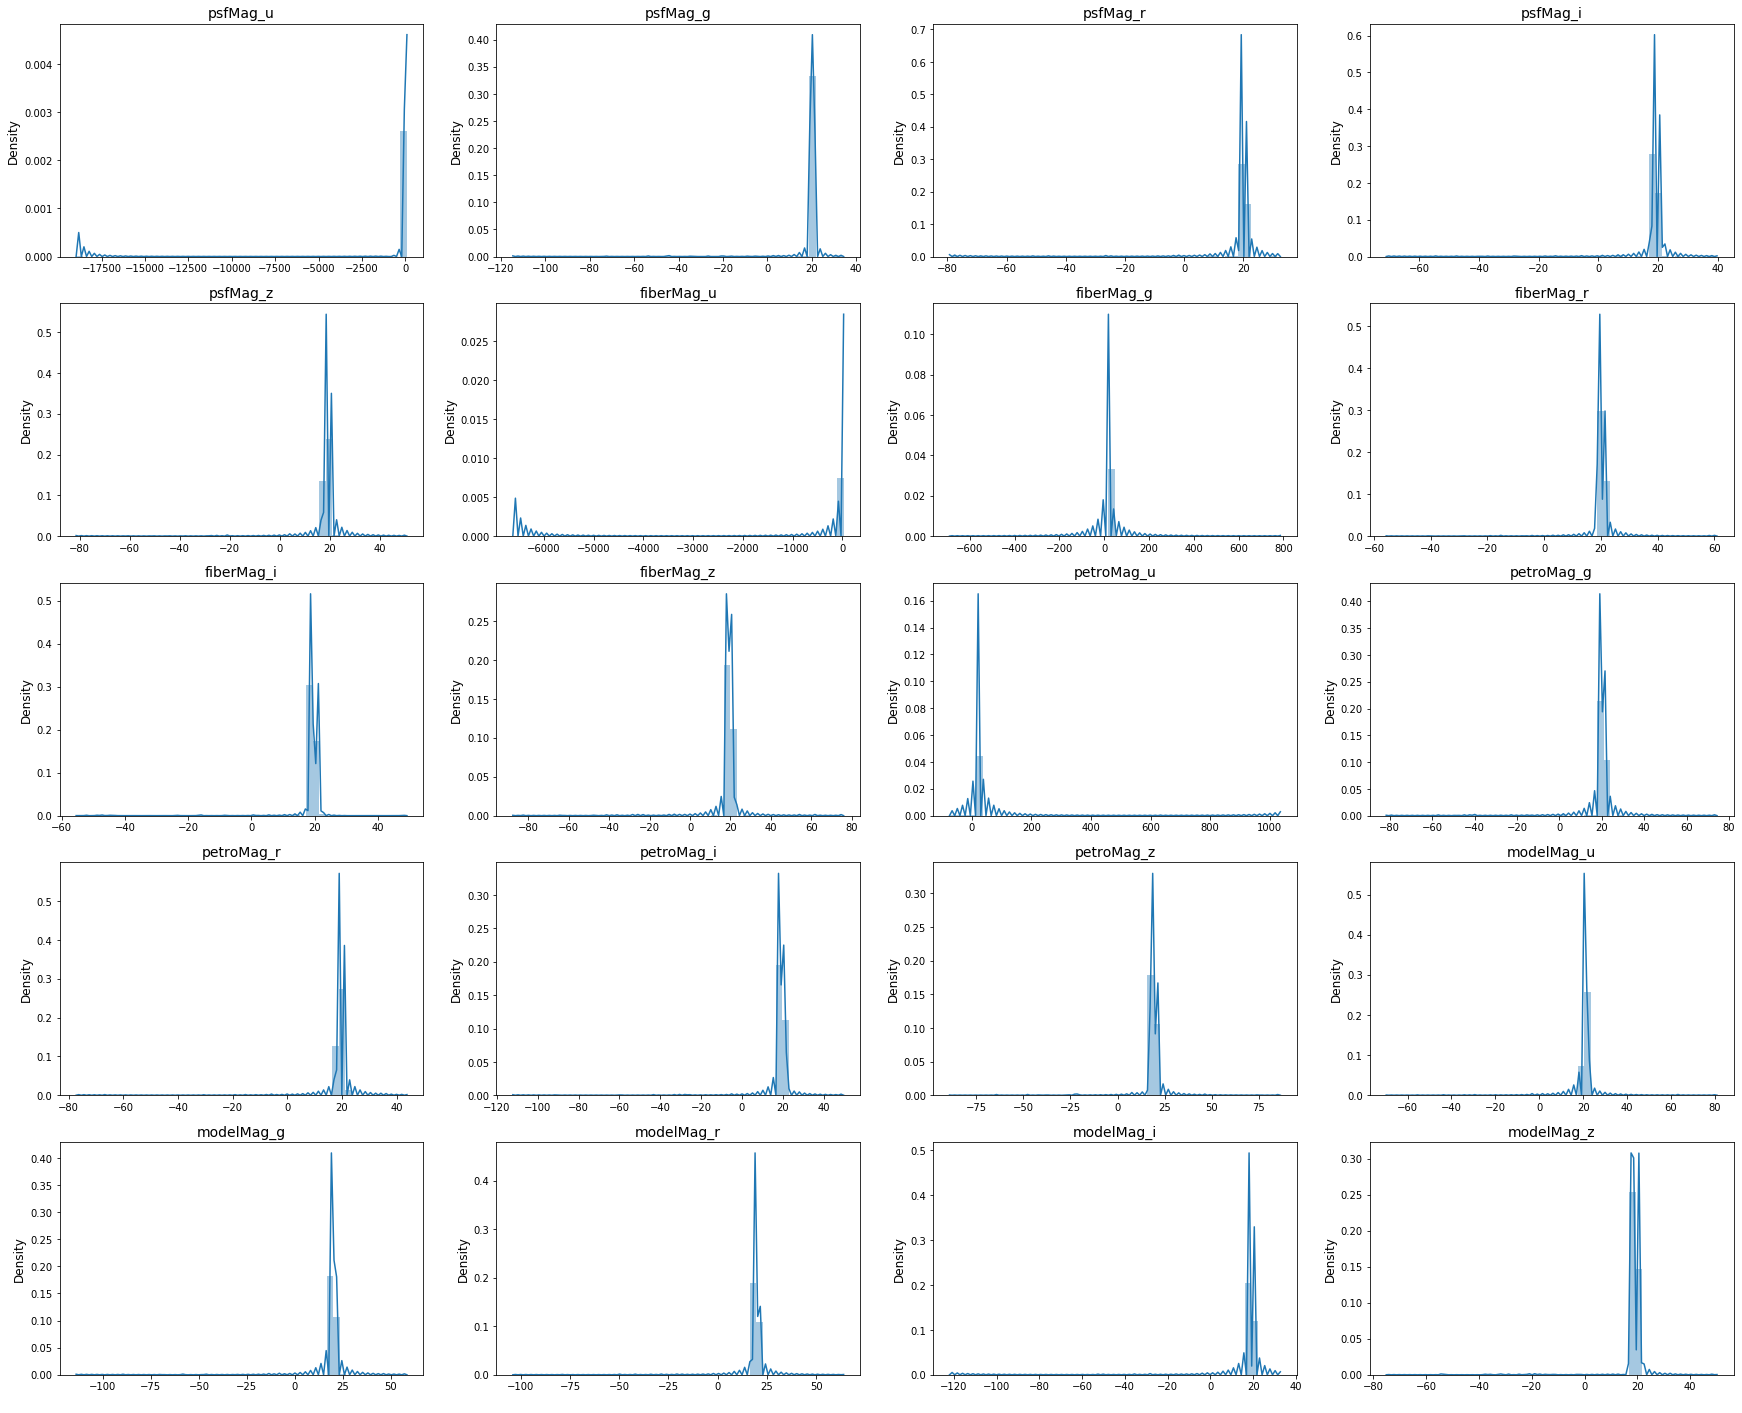

In [70]:
VisFeature(fiberID_mean)

광섬유 구분자별 평균을 취했음에도 불구하고, 극단적으로 낮은 값이 존재한다.

추후 Outlier Detection을 이용하여 이상치로 감지된 관측값을 제외하고 훈련을 수행하는 방법을 생각할 수 있을 것이다.

### Median

In [75]:
fiberID_median.describe()

psfMag_u     psfMag_g     psfMag_r     psfMag_i     psfMag_z  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     21.108593    20.297234    19.895810    19.557428    19.192842   
std       0.526452     0.722123     0.834525     0.954304     1.074881   
min      20.201431    19.335231    18.605444    18.205390    17.839525   
25%      20.678912    19.726638    19.236454    18.792480    18.294542   
50%      20.899159    19.923311    19.467781    19.068463    18.642922   
75%      21.671571    21.132795    20.885538    20.706867    20.506780   
max      22.442052    21.921818    21.650904    21.476386    21.307914   

        fiberMag_u   fiberMag_g   fiberMag_r   fiberMag_i   fiberMag_z  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean     21.328668    20.496163    20.068055    19.720063    19.349845  ...   
std       0.552051     0.777268     0.912558     1.034889     1.114843  ...   
min      20.429339    19.491860    18.734176    18.344081    18.068270  ...   
25%      20.886214    19.864756    19.335068    18.867281    18.428106  ...   
50%      21.074565    20.085665    19.656103    19.204162    18.718706  ...   
75%      21.936514    21.414034    21.147097    20.984531    20.709748  ...   
max      22.854225    22.224955    21.940668    21.747328    21.481734  ...   

        petroMag_g   petroMag_r   petroMag_i   petroMag_z   modelMag_u  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     20.040619    19.588165    19.256544    18.889336    20.810420   
std       0.946859     1.103691     1.213835     1.265546     0.742621   
min      18.556123    17.811408    17.482078    17.270427    19.709314   
25%      19.299374    18.678100    18.228653    17.859824    20.211051   
50%      19.605669    19.207720    18.728129    18.187093    20.424854   
75%      21.162704    20.869987    20.721883    20.415945    21.663623   
max      21.939678    21.676614    21.485669    22.171266    22.433663   

        modelMag_g   modelMag_r   modelMag_i   modelMag_z  fiberID_group  
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.000000  
mean     19.996156    19.547074    19.200052    18.856442     450.900000  
std       0.938291     1.102148     1.212099     1.311572     287.370443  
min      18.513811    17.765608    17.441364    17.208508       0.000000  
25%      19.260206    18.629639    18.177641    17.784044     200.000000  
50%      19.563293    19.171258    18.656075    18.113944     500.000000  
75%      21.103757    20.837444    20.674708    20.498279     700.000000  
max      21.876959    21.561249    21.387173    21.284618     900.000000  

[8 rows x 21 columns]

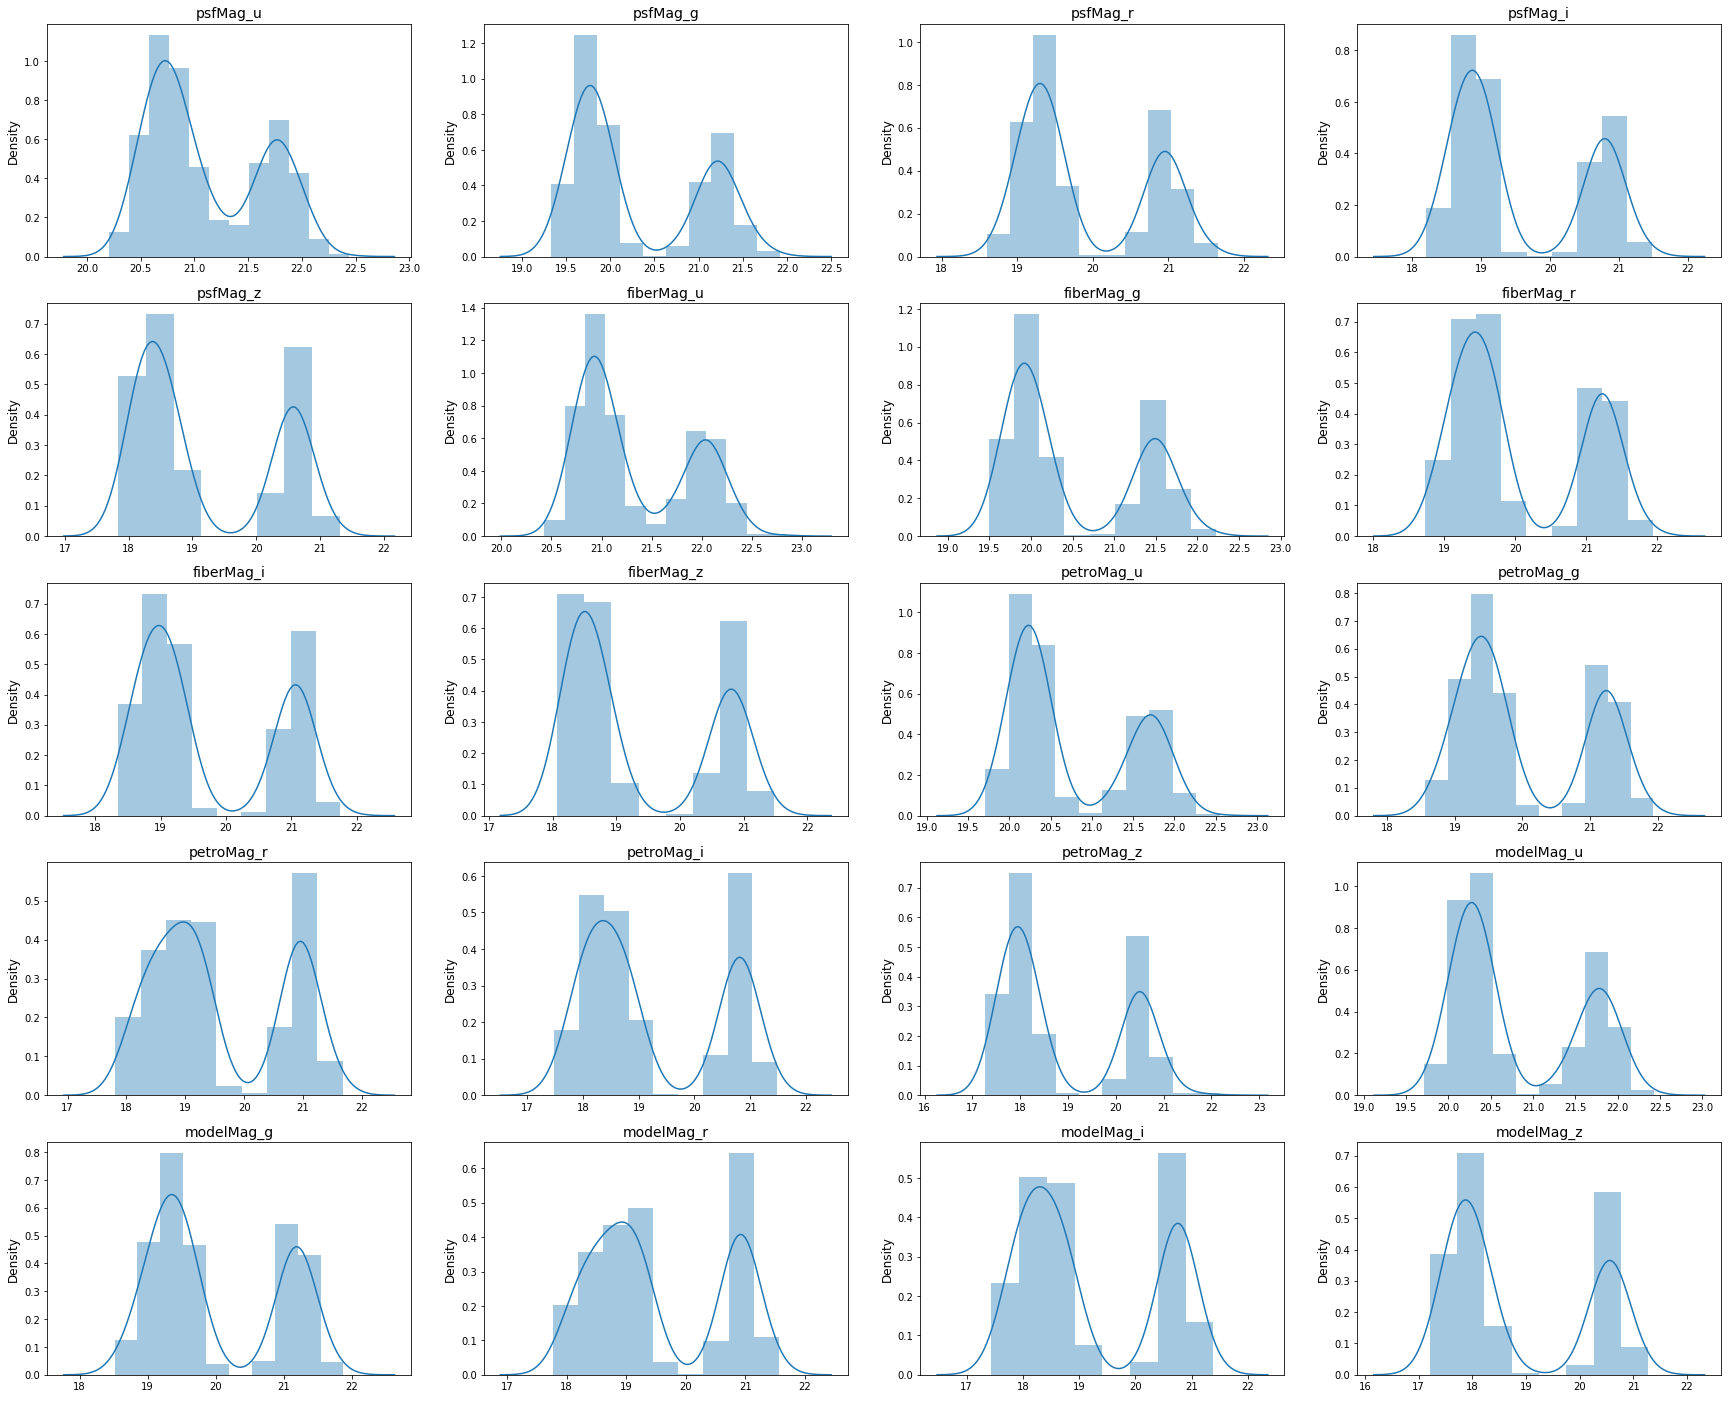

In [71]:
VisFeature(fiberID_median)

구분자별 중앙값을 확인해 본 결과, 모든 피쳐들은 쌍봉 형태의 분포를 보인다는 것을 확인할 수 있다. 구분되는 분포가 어떤 특징을 보이는지 확인해 볼 필요가 있을 것이다. 

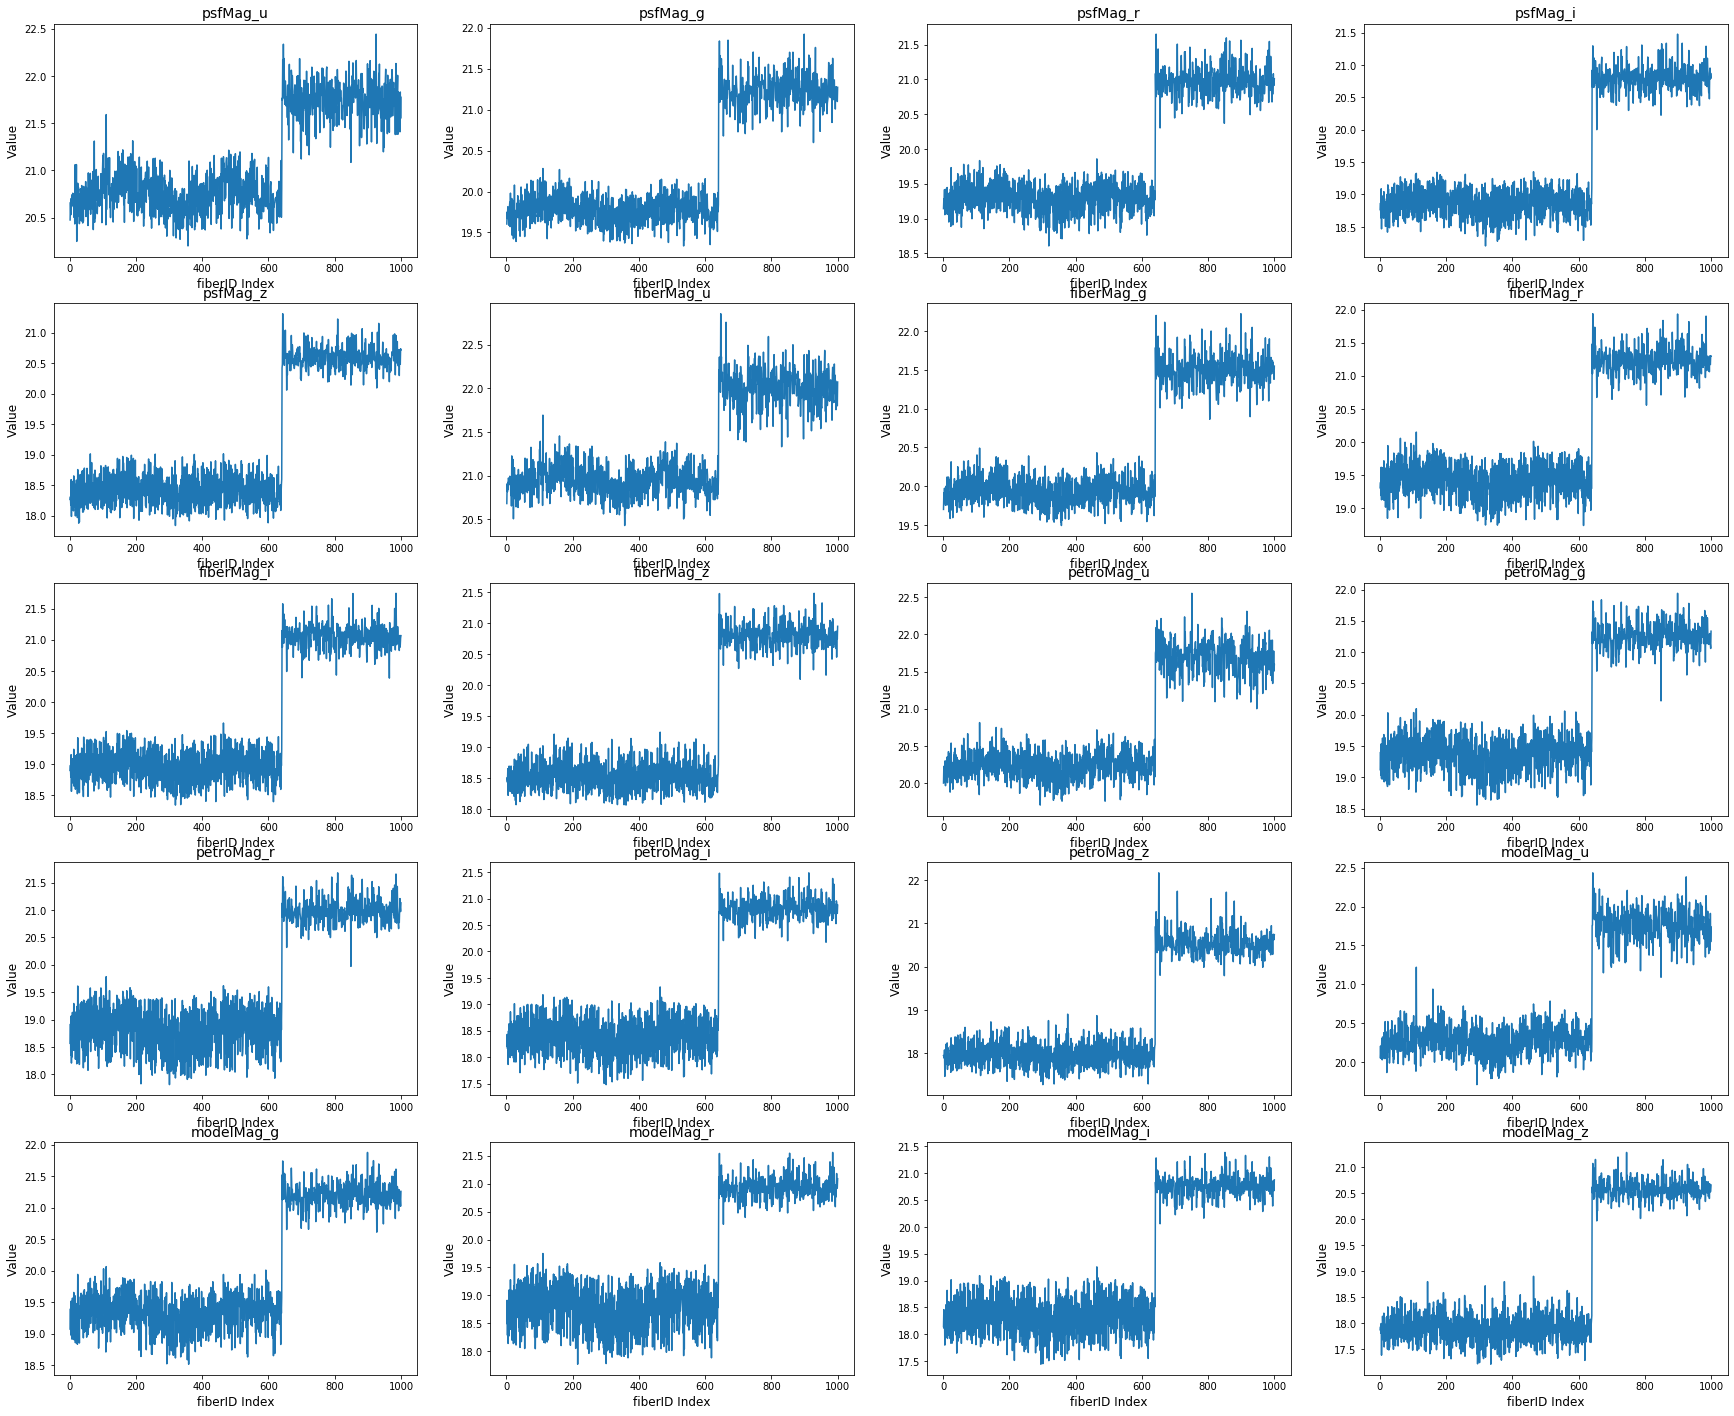

In [83]:
VisFeature(fiberID_median, method = 'line')

모든 피쳐별 중앙값은 광섬유 구분자 600이후 급격하게 증가한다는 것을 알 수 있다. 

이전에 수행한 탐색적 자료 분석을 통해 640이후 라는 것을 예상할 수 있을 것이다.

실제로 그러한지, 다시 시각화를 수행한다.

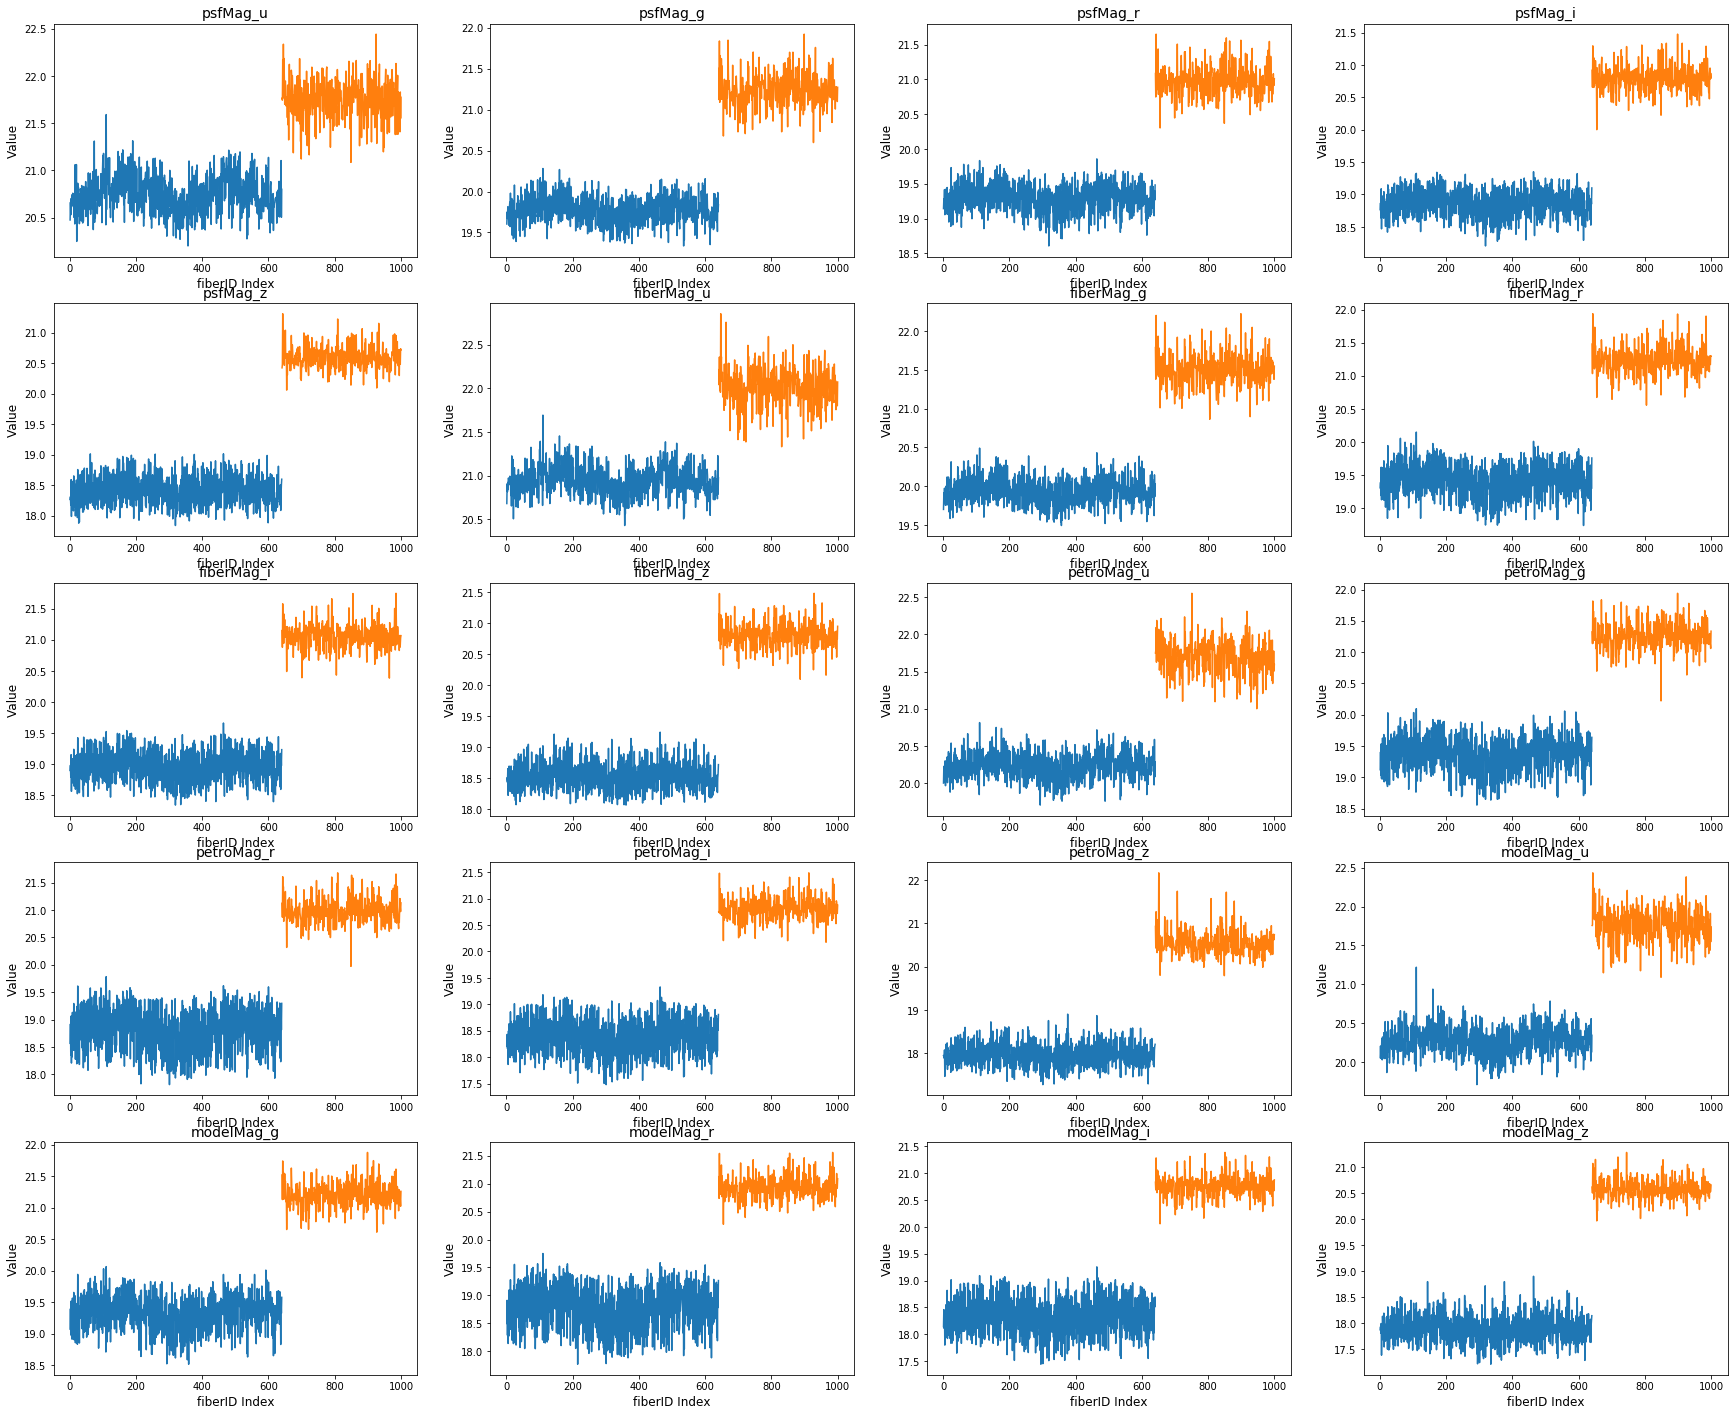

In [109]:
VisFeature(fiberID_median, method = 'line', sep = True)

### Standard Deviation

In [76]:
fiberID_std.describe()

psfMag_u     psfMag_g     psfMag_r     psfMag_i     psfMag_z  \
count    1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      336.017919    15.941264    12.673765    12.110106    14.032174   
std     10036.872487   127.601139   105.326117    97.092340   105.615387   
min         0.676695     0.413346     0.440204     0.426956     0.525997   
25%         1.407764     0.887430     0.902656     0.905391     1.018839   
50%         2.038938     1.818775     1.632769     1.495651     1.533343   
75%         2.140615     1.913483     1.716786     1.598652     1.655336   
max    317381.452371  2315.717533  1628.660739  1537.471804  1565.265682   

          fiberMag_u    fiberMag_g   fiberMag_r   fiberMag_i   fiberMag_z  \
count    1000.000000   1000.000000  1000.000000  1000.000000  1000.000000   
mean      125.561269     41.450410     9.091205    13.043189    16.636949   
std      3525.586257    596.428652    74.315659   102.725102   123.812146   
min         0.623041      0.446238     0.456752     0.440464     0.324747   
25%         1.272393      0.883051     0.907665     0.956747     1.025970   
50%         1.923823      1.793561     1.624698     1.479813     1.520665   
75%         2.031127      1.881329     1.699344     1.590795     1.640377   
max    111443.799325  13780.973223  1272.696888  1190.826319  1667.555187   

       ...   petroMag_g   petroMag_r   petroMag_i   petroMag_z   modelMag_u  \
count  ...  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean   ...    18.338107    11.148206    14.310675    16.691324    13.535370   
std    ...   130.013157    83.495298   121.432074   118.273281   102.258456   
min    ...     0.393482     0.466196     0.461400     0.583952     0.679973   
25%    ...     0.941028     0.963579     1.124847     1.595533     1.449356   
50%    ...     1.985463     1.817672     1.674528     1.819616     2.131912   
75%    ...     2.127062     1.935684     1.849780     2.014182     2.236265   
max    ...  1611.087747  1506.807395  2286.746723  1785.454132  1536.606459   

        modelMag_g   modelMag_r   modelMag_i   modelMag_z  fiberID_group  
count  1000.000000  1000.000000  1000.000000  1000.000000         1000.0  
mean     16.644736    12.437104    12.460869    15.738686            0.0  
std     135.605602   112.166853   111.362161   111.044074            0.0  
min       0.452045     0.411013     0.470973     0.465581            0.0  
25%       0.876323     0.889678     0.901377     1.005700            0.0  
50%       1.904283     1.772726     1.628083     1.677328            0.0  
75%       1.984542     1.849169     1.762729     1.822782            0.0  
max    2210.449821  2108.465805  2329.984288  1546.900712            0.0  

[8 rows x 21 columns]

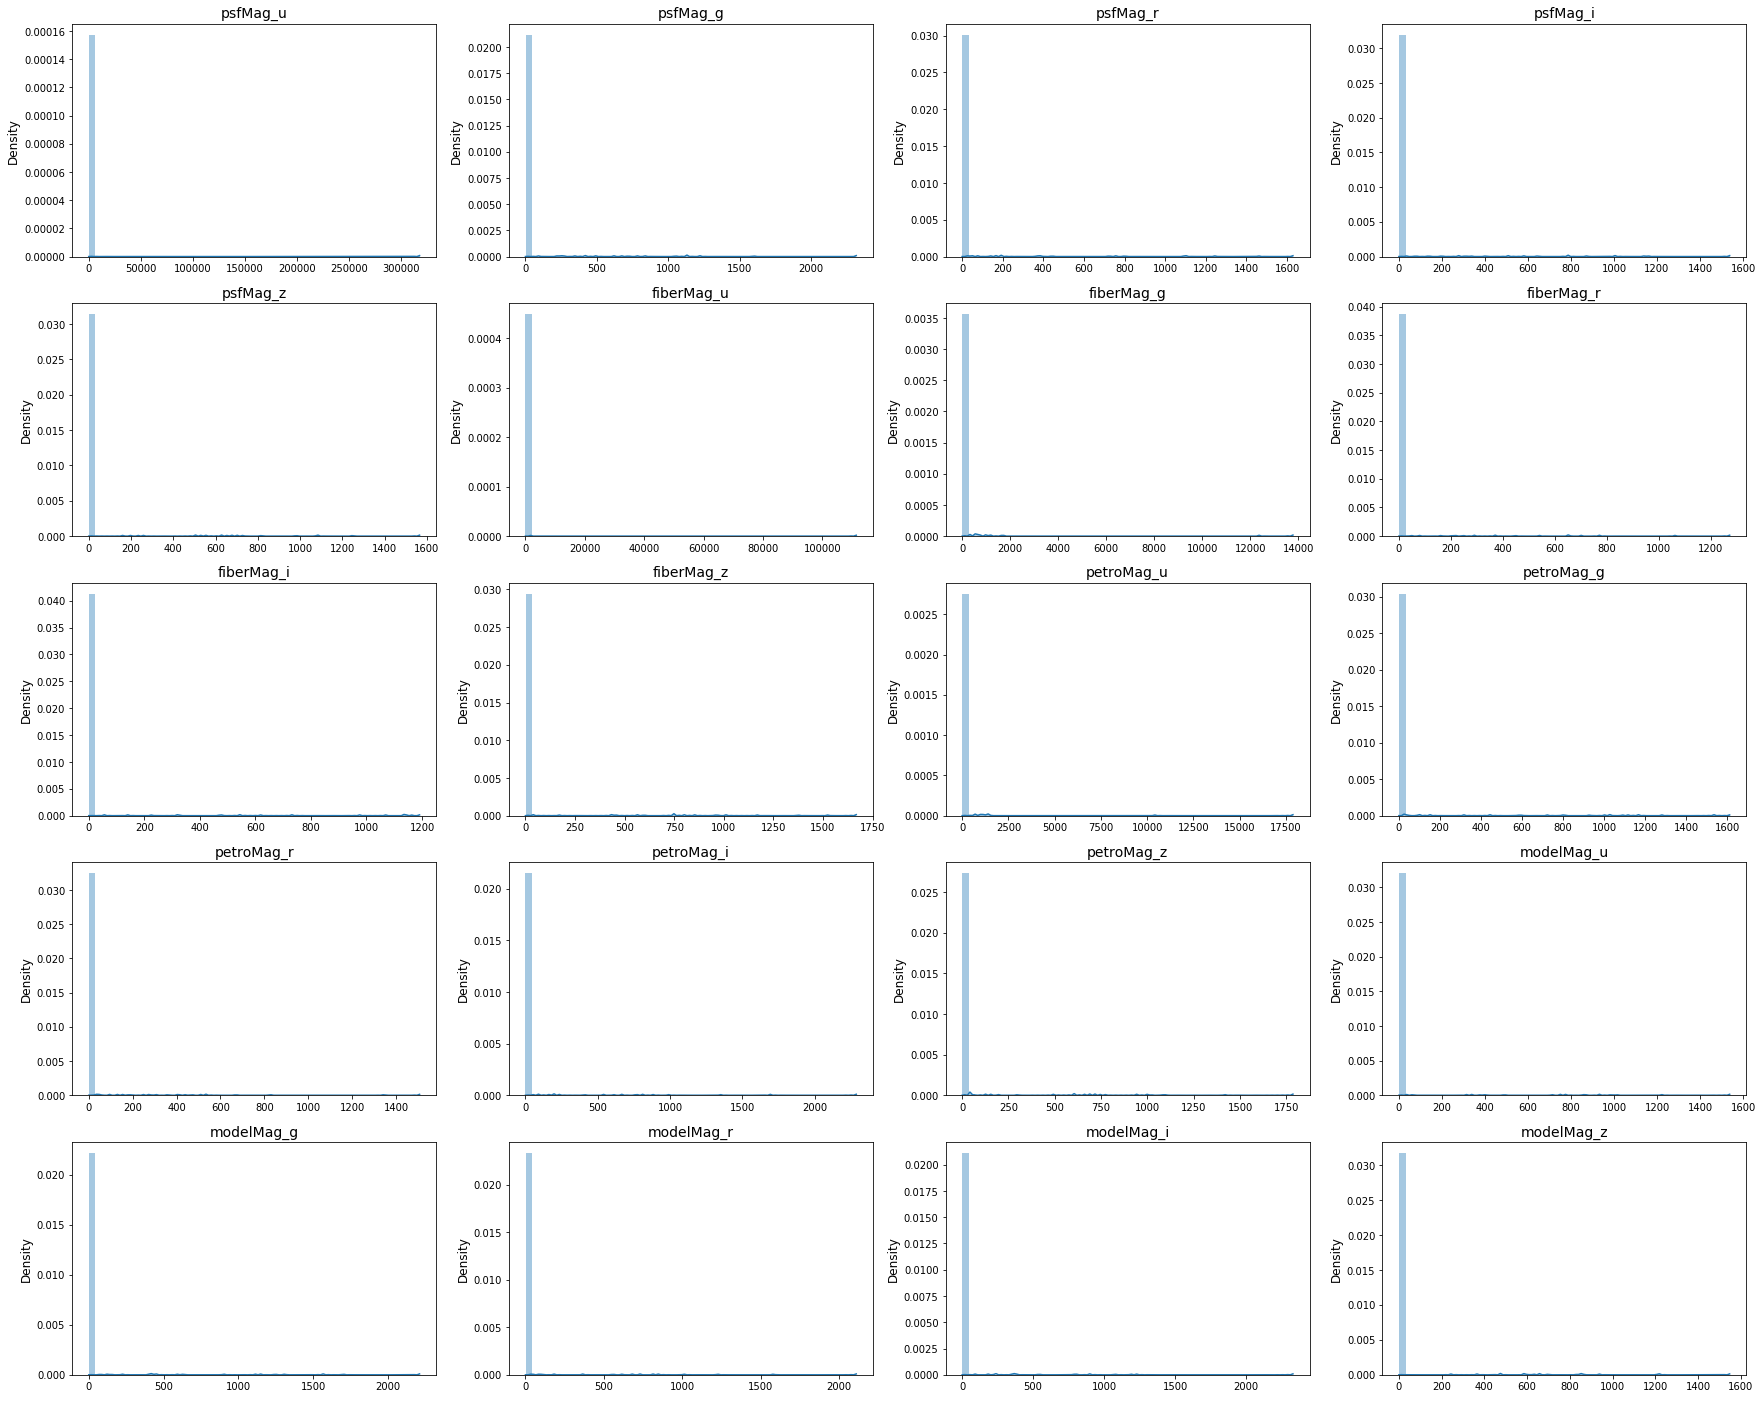

In [72]:
VisFeature(fiberID_std)

평균에서 확인했다시피, 극단적인 값로 인하여 표준 편차가 매우 큰 피쳐들이 존재한다.

## Embedding fiberID
데이터 확인을 통해 fiberID는 Categorical Feature라는 것을 알 수 있었다. 일반적으로 머신러닝에서 Categorical Feature를 처리하는 방법은 다음과 같다. 

- One-Hot Encoding
- Dummy Coding

위 두 가지 방법은 차원의 저주(The Curse of Demensionality)가 발생할 수 있다는 점과 데이터가 매우 Sparse되어 분석 결과가 왜곡될 수 있다는 점이 존재한다.

이를 보완하기 위해 Kaggle에서 Word2Vec를 응용한 <b>Cat2Vec</b>을 사용하여 Categorical Feature를 Embedding할 것이다.

In [227]:
input_fiberID = [[x] for x in np.sort(list(train['fiberID']))]

In [228]:
train['fiberID'] = train['fiberID'].astype('str')
input_fiberID = [[x] for x in list(train['fiberID'])]

embedding_model = Word2Vec(input_fiberID, size = 10,
                          iter = 100, min_count = 1)

In [229]:
X = embedding_model[embedding_model.wv.vocab]

df_X = pd.DataFrame(X)

for i,j in enumerate(df_X):
    df_X = df_X.rename(columns = {i : "fiberID_embedding{}".format(j+1)})

df_X['fiberID'] = embedding_model.wv.vocab

train['fiberID'] = train['fiberID'].astype('str')
train = pd.merge(train, df_X, on = 'fiberID', how = 'left')
train.drop(columns = 'fiberID', inplace = True)

In [230]:
test['fiberID'] = test['fiberID'].astype('str')
test = pd.merge(test, df_X, on = 'fiberID', how = 'left')
test.drop(columns = 'fiberID', inplace = True)

In [231]:
train.to_csv('../dataset/embedding_train.csv')
test.to_csv('../dataset/embedding_test.csv')